<a href="https://colab.research.google.com/github/nurulshifaside/Data-Science-Tasks/blob/main/Analisis%20Pola%20Musiman%20dan%20Prediksi%20Suhu%20sebagai%20Strategi%20Kesiapsiagaan%20Masyarakat%20terhadap%20Pergantian%20Musim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Library Dasar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split

# Library Metric Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Library Rf
from sklearn.ensemble import RandomForestRegressor

# Library XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# Library LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Import ARIMA & SARIMA
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

# Import Prophet
from prophet import Prophet

# Import & Examine The Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tim 7A Final Project Drive/Dataset/train.csv')
df

id                 date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0          0  2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340   
1          1  2016-07-01 00:15:00   5.760  2.076  1.492  0.426  4.264  1.401   
2          2  2016-07-01 00:30:00   5.760  1.942  1.492  0.391  4.234  1.310   
3          3  2016-07-01 00:45:00   5.760  1.942  1.492  0.426  4.234  1.310   
4          4  2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371   
...      ...                  ...     ...    ...    ...    ...    ...    ...   
64315  64315  2018-05-01 22:45:00  12.458  1.407  7.889 -0.746  4.843  1.523   
64316  64316  2018-05-01 23:00:00  14.200  1.541  9.310  0.284  4.752  1.249   
64317  64317  2018-05-01 23:15:00  12.659  1.474  7.924 -0.959  4.569  1.310   
64318  64318  2018-05-01 23:30:00  13.329  1.541  8.671 -0.533  4.630  1.371   
64319  64319  2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   

       Temperature  
0        30.531000  
1        30.459999  
2        30.038000  
3        27.013000  
4        27.787001  
...            ...  
64315    10.622000  
64316    10.482000  
64317    10.271000  
64318    10.341000  
64319    10.833000  

[64320 rows x 9 columns]

**Data Descriptions**

* date: timestamp yang menunjukkan tanggal dan waktu
observasi.

* Iws: Kecepatan angin kumulatif selama periode menjelang
setiap pengamatan.

* Ir: Intensitas curah hujan yang diukur pada setiap waktu pengamatan.

* Pm2.5: Konsentrasi materi partikulat halus (PM2.5) di udara.

* PRES: Tekanan atmosfer dicatat pada setiap titik waktu.

* Cbwd: Gabungan arah angin yang diukur di lokasi pengamatan.

* DEWP: Suhu titik embun, mewakili suhu saat udara menjadi jenuh dengan uap air.

* Temperature: Suhu udara (dalam derajat Celcius) sekitar yang dicatat pada setiap waktu, berfungsi sebagai fokus utama analisis dan prediksi.

# Data Preprocessing

## Data Preparation

###Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           64320 non-null  int64  
 1   date         64320 non-null  object 
 2   Iws          64320 non-null  float64
 3   Ir           64320 non-null  float64
 4   pm2.5        64320 non-null  float64
 5   PRES         64320 non-null  float64
 6   cbwd         64320 non-null  float64
 7   DEWP         64320 non-null  float64
 8   Temperature  64320 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.4+ MB


In [ ]:
missing_data = pd.DataFrame({'Missing Data':df.isnull().sum(),
                             'Data Percent (%)':((df.isnull().sum()/df.shape[0])*100).round(2)})

missing_data

Missing Data  Data Percent (%)
id                      0               0.0
date                    0               0.0
Iws                     0               0.0
Ir                      0               0.0
pm2.5                   0               0.0
PRES                    0               0.0
cbwd                    0               0.0
DEWP                    0               0.0
Temperature             0               0.0

In [ ]:
kolom_khusus = ['Iws', 'Ir', 'pm2.5', 'PRES', 'cbwd', 'DEWP', 'Temperature']

rows_khusus_all_zero = df[(df[kolom_khusus] == 0).all(axis=1)]

jumlah_missing_value_khusus_all_zero = rows_khusus_all_zero.shape[0]

print(f"Jumlah baris dengan semua nilai pada kolom-kolom tertentu = {jumlah_missing_value_khusus_all_zero}")
rows_khusus_all_zero

Jumlah baris dengan semua nilai pada kolom-kolom tertentu = 33


id                 date  Iws   Ir  pm2.5  PRES  cbwd  DEWP  \
15169  15169  2016-12-06 00:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15170  15170  2016-12-06 00:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15171  15171  2016-12-06 00:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15172  15172  2016-12-06 01:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15173  15173  2016-12-06 01:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15174  15174  2016-12-06 01:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15175  15175  2016-12-06 01:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15209  15209  2016-12-06 10:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15210  15210  2016-12-06 10:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15213  15213  2016-12-06 11:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15214  15214  2016-12-06 11:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15215  15215  2016-12-06 11:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15216  15216  2016-12-06 12:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15217  15217  2016-12-06 12:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15218  15218  2016-12-06 12:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15219  15219  2016-12-06 12:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15220  15220  2016-12-06 13:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15221  15221  2016-12-06 13:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15222  15222  2016-12-06 13:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15223  15223  2016-12-06 13:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15224  15224  2016-12-06 14:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15225  15225  2016-12-06 14:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15226  15226  2016-12-06 14:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15227  15227  2016-12-06 14:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15228  15228  2016-12-06 15:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15229  15229  2016-12-06 15:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15230  15230  2016-12-06 15:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15231  15231  2016-12-06 15:45:00  0.0  0.0    0.0   0.0   0.0   0.0   
15232  15232  2016-12-06 16:00:00  0.0  0.0    0.0   0.0   0.0   0.0   
15233  15233  2016-12-06 16:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15237  15237  2016-12-06 17:15:00  0.0  0.0    0.0   0.0   0.0   0.0   
15238  15238  2016-12-06 17:30:00  0.0  0.0    0.0   0.0   0.0   0.0   
15304  15304  2016-12-07 10:00:00  0.0  0.0    0.0   0.0   0.0   0.0   

       Temperature  
15169          0.0  
15170          0.0  
15171          0.0  
15172          0.0  
15173          0.0  
15174          0.0  
15175          0.0  
15209          0.0  
15210          0.0  
15213          0.0  
15214          0.0  
15215          0.0  
15216          0.0  
15217          0.0  
15218          0.0  
15219          0.0  
15220          0.0  
15221          0.0  
15222          0.0  
15223          0.0  
15224          0.0  
15225          0.0  
15226          0.0  
15227          0.0  
15228          0.0  
15229          0.0  
15230          0.0  
15231          0.0  
15232          0.0  
15233          0.0  
15237          0.0  
15238          0.0  
15304          0.0

Terdapat beberapa baris yang memiliki nilai 0 pada setiap kolom (kecuali kolom id), yang berarti itu merupakan missing value. Maka kami menghandlenya dengan metode ffill.

In [ ]:
df.loc[df['Temperature'] == 0, 'Temperature'] = pd.NA

df['Temperature'] = df['Temperature'].fillna(method='ffill')

In [ ]:
rows_khusus_all_zero = df[(df[kolom_khusus] == 0).all(axis=1)]

jumlah_missing_value_khusus_all_zero = rows_khusus_all_zero.shape[0]

print(f"Jumlah baris dengan semua nilai pada kolom-kolom tertentu = {jumlah_missing_value_khusus_all_zero}")
rows_khusus_all_zero

Jumlah baris dengan semua nilai pada kolom-kolom tertentu = 0


Empty DataFrame
Columns: [id, date, Iws, Ir, pm2.5, PRES, cbwd, DEWP, Temperature]
Index: []

In [ ]:
temperature_zero = df[df['Temperature'] == 0]

jumlah_missing_value = temperature_zero.shape[0]

print(f"Jumlah baris dengan nilai Temperature = 0: {jumlah_missing_value}")
print(temperature_zero)

Jumlah baris dengan nilai Temperature = 0: 0
Empty DataFrame
Columns: [id, date, Iws, Ir, pm2.5, PRES, cbwd, DEWP, Temperature]
Index: []


Dengan dihandlenya missing value tadi dataframe sudah tidak memiliki nilai yang hilang (missing values) lagi pada setiap barisnya.

###Duplicate Values

In [ ]:
duplicate_values = df.duplicated().sum()
print(f'There are {duplicate_values} duplicate values')

There are 0 duplicate values


Dari hasil pengecekan dapat diketahui bahwa tidak terdapat data duplikat pada dataframe tersebut.

###Outliers

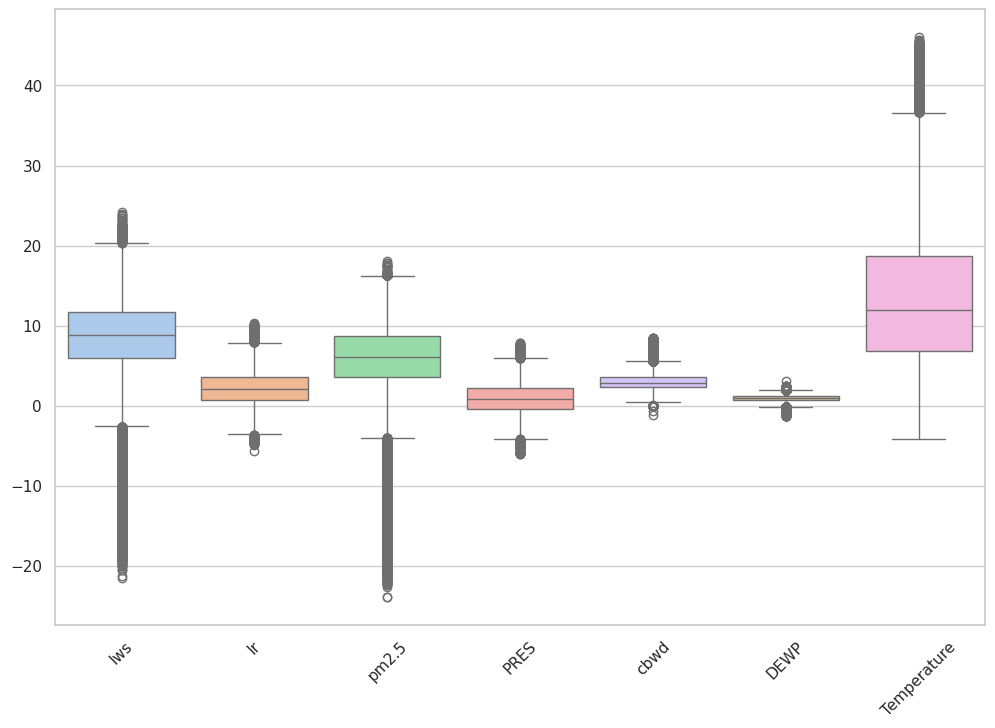

In [ ]:
df_selected = df.drop(columns=['id'])

sns.set(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(df_selected)
plt.xticks(rotation=45)
plt.show()

Setelah mengevaluasi, kami menemukan adanya data yang berbeda secara signifikan (outliers). Meskipun demikian, tim kami memutuskan untuk tidak mengubah data tersebut karena nilai-nilai tersebut tetap penting dalam konteks suhu. Sehingga, kami akan memfilter data tersebut untuk  divisualisasikan dalam dashboard.

**Mengubah tipe data 'Date' menjadi datetime**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           64320 non-null  int64  
 1   date         64320 non-null  object 
 2   Iws          64320 non-null  float64
 3   Ir           64320 non-null  float64
 4   pm2.5        64320 non-null  float64
 5   PRES         64320 non-null  float64
 6   cbwd         64320 non-null  float64
 7   DEWP         64320 non-null  float64
 8   Temperature  64320 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.4+ MB


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           64320 non-null  int64         
 1   date         64320 non-null  datetime64[ns]
 2   Iws          64320 non-null  float64       
 3   Ir           64320 non-null  float64       
 4   pm2.5        64320 non-null  float64       
 5   PRES         64320 non-null  float64       
 6   cbwd         64320 non-null  float64       
 7   DEWP         64320 non-null  float64       
 8   Temperature  64320 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 4.4 MB


**Mengubah 'Date' menjadi index**

In [ ]:
df7a = df.drop('id', axis=1).set_index('date')
df7a.head()

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature
date                                                                      
2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340    30.531000
2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401    30.459999
2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310    30.038000
2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310    27.013000
2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371    27.787001

Tipe data 'date' dari yang asalnya **object** sudah diubah menjadi **datetime** agar memudahkan proses plotting.

## EDA

In [ ]:
df7a

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature
date                                                                       
2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340    30.531000
2016-07-01 00:15:00   5.760  2.076  1.492  0.426  4.264  1.401    30.459999
2016-07-01 00:30:00   5.760  1.942  1.492  0.391  4.234  1.310    30.038000
2016-07-01 00:45:00   5.760  1.942  1.492  0.426  4.234  1.310    27.013000
2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371    27.787001
...                     ...    ...    ...    ...    ...    ...          ...
2018-05-01 22:45:00  12.458  1.407  7.889 -0.746  4.843  1.523    10.622000
2018-05-01 23:00:00  14.200  1.541  9.310  0.284  4.752  1.249    10.482000
2018-05-01 23:15:00  12.659  1.474  7.924 -0.959  4.569  1.310    10.271000
2018-05-01 23:30:00  13.329  1.541  8.671 -0.533  4.630  1.371    10.341000
2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310    10.833000

[64320 rows x 7 columns]

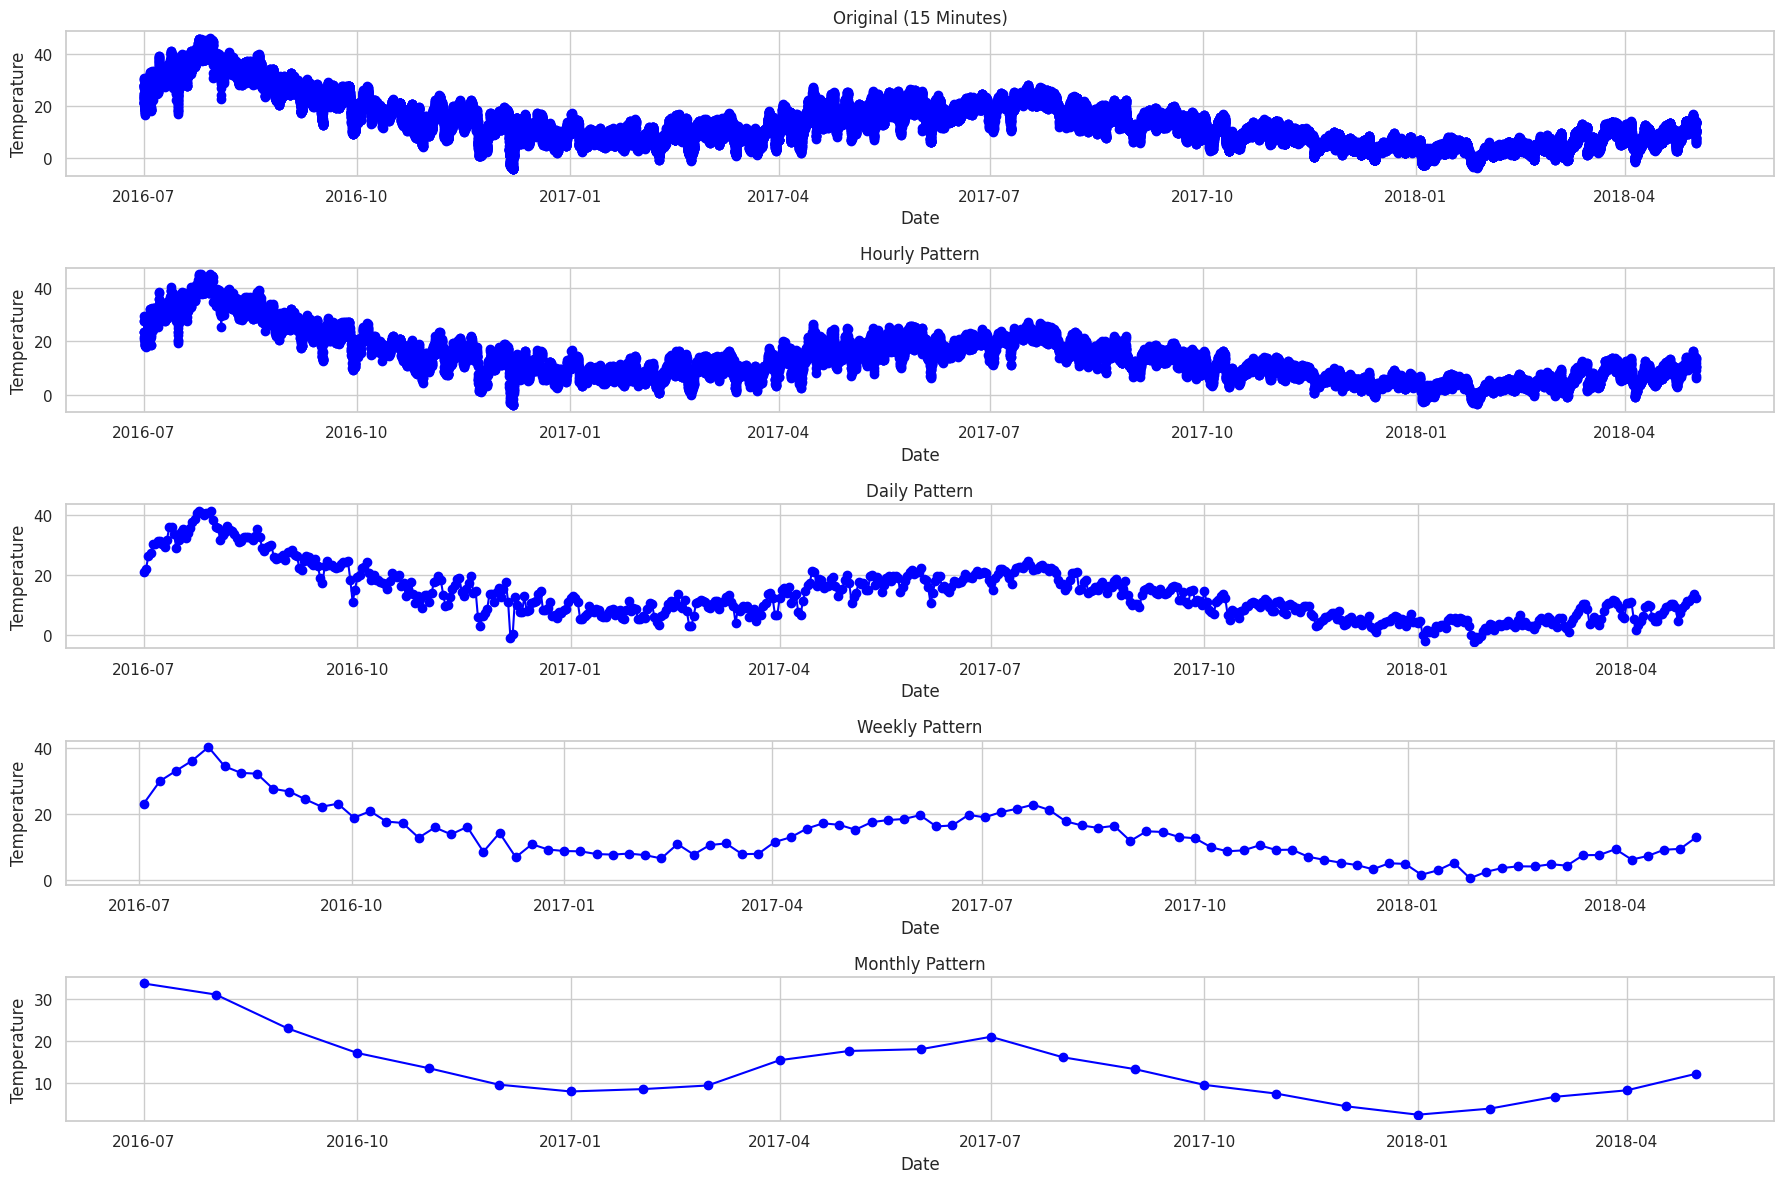

In [ ]:
# Melihat pola dataset 4
fig, axs = plt.subplots(5, figsize=(18,12))

axs[0].set_title('Original (15 Minutes)')
axs[0].plot(df7a.index, df7a['Temperature'], label='suhu', marker='o', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')

df_hour = df7a.resample('H').mean()
axs[1].set_title('Hourly Pattern')
axs[1].plot(df_hour.index, df_hour['Temperature'], label='suhu', marker='o', color='blue')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')

df_day = df7a.resample('D').mean()
axs[2].set_title('Daily Pattern')
axs[2].plot(df_day.index, df_day['Temperature'], label='suhu', marker='o', color='blue')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')

df_week = df7a.resample('w').mean()
axs[3].set_title('Weekly Pattern')
axs[3].plot(df_week.index, df_week['Temperature'], label='suhu', marker='o', color='blue')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Temperature')

df_month = df7a.resample('MS').mean()
axs[4].set_title('Monthly Pattern')
axs[4].plot(df_month.index, df_month['Temperature'], label='suhu', marker='o', color='blue')
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Temperature')

plt.tight_layout()
plt.show()

Dari hasil plotting tersebut, kami membreakdown sebanyak 5 pola berdasarkan kategori original (semua data), per jam, hari, week, bulan.
Dari kurva yg dihasilkan tidak jauh berbeda bentuknya. Namun dalam judul project yg kami buat, kami memutuskan untuk mengambil plot monthly yg berguna untuk prediksi musim dan relevan dengan arah kesehatan masyarakat.

In [ ]:
# Calculates basic statistics for each numeric column
df7a.describe().transpose()

count       mean       std        min    25%     50%     75%  \
Iws          64320.0   7.522545  6.914888 -21.568001  5.961   8.841  11.721   
Ir           64320.0   2.142897  2.023449  -5.693000  0.670   2.076   3.550   
pm2.5        64320.0   4.478698  6.669074 -23.986000  3.553   6.041   8.635   
PRES         64320.0   0.820356  1.818778  -6.041000 -0.391   0.853   2.132   
cbwd         64320.0   3.042537  1.169700  -1.188000  2.284   2.802   3.594   
DEWP         64320.0   0.819362  0.602287  -1.371000  0.640   0.944   1.157   
Temperature  64320.0  13.612187  8.825239  -4.221000  6.753  11.959  18.712   

                max  
Iws          24.180  
Ir           10.315  
pm2.5        18.087  
PRES          7.853  
cbwd          8.498  
DEWP          3.046  
Temperature  46.007

In [ ]:
df7a['Temperature'].describe()

count    64320.000000
mean        13.612187
std          8.825239
min         -4.221000
25%          6.753000
50%         11.959000
75%         18.712000
max         46.007000
Name: Temperature, dtype: float64

Berdasarkan hasil tersebut, kita ketahui bahwa nilai rata-rata suhu dalam dataframe adalah **13 derajat** dengan nilai minimum suhu **-4 derajat** dan nilai maksimum suhu **46 derajat**.

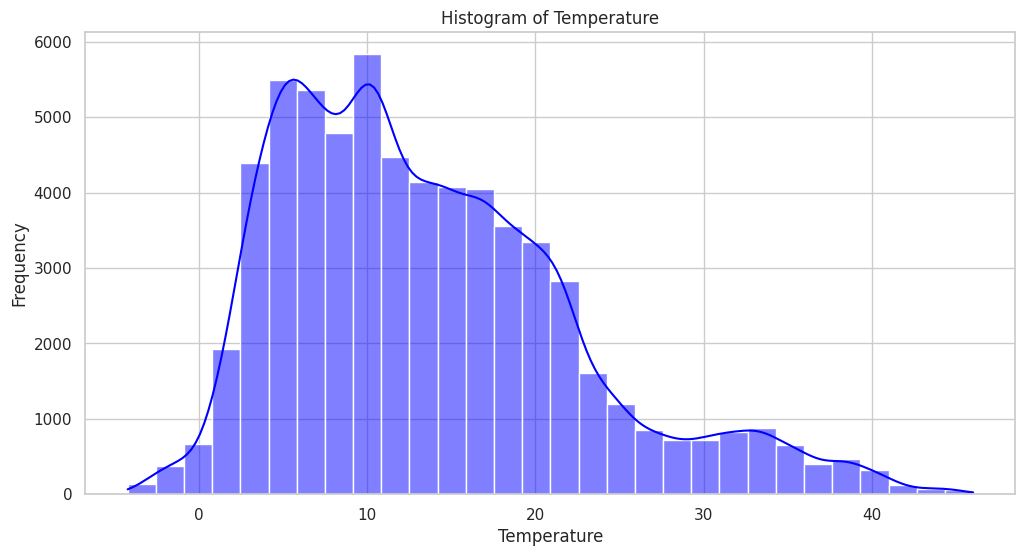

In [ ]:
# Describe the data distribution for each numeric column using a histogram or density plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df7a, x='Temperature', bins=30, kde=True, color='blue')
plt.title('Histogram of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

Dari visualisasi di atas bisa dilihat bahwa suhu dalam dataframe itu kebanyakan berkisar pada **6-18 derajat**

## Feature Engineering

In [ ]:
# Membuat fitur untuk menghitung Water Vapour Pressure yang digunakan untuk kelembapan
def hitung_tekanan_uapair(DEWP):
  # Hitung tekanan uap air (E) berdasarkan suhu titik embun (DEWP)
  E = 6.112 * np.exp((17.62 * DEWP) / (243.12 + DEWP))
  return E

df7a['WVP'] = hitung_tekanan_uapair(df7a['DEWP'])
df7a.head()

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature  \
date                                                                         
2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340    30.531000   
2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401    30.459999   
2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310    30.038000   
2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310    27.013000   
2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371    27.787001   

                          WVP  
date                           
2016-07-01 00:00:00  6.731766  
2016-07-01 00:15:00  6.761259  
2016-07-01 00:30:00  6.717304  
2016-07-01 00:45:00  6.717304  
2016-07-01 01:00:00  6.746740

In [ ]:
# Membuat fitur untuk menghitung suhu yang dirasakan manusia
def calculate_feels_like(Ta, Iws, WVP):
    # Menghitung Suhu Feels Like
    AT = Ta + 0.33 * WVP - 0.7 * Iws - 4
    return AT

df7a['Feels Like'] = calculate_feels_like(df7a['Temperature'], df7a['Iws'], df7a['WVP'])
df7a

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature  \
date                                                                          
2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340    30.531000   
2016-07-01 00:15:00   5.760  2.076  1.492  0.426  4.264  1.401    30.459999   
2016-07-01 00:30:00   5.760  1.942  1.492  0.391  4.234  1.310    30.038000   
2016-07-01 00:45:00   5.760  1.942  1.492  0.426  4.234  1.310    27.013000   
2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371    27.787001   
...                     ...    ...    ...    ...    ...    ...          ...   
2018-05-01 22:45:00  12.458  1.407  7.889 -0.746  4.843  1.523    10.622000   
2018-05-01 23:00:00  14.200  1.541  9.310  0.284  4.752  1.249    10.482000   
2018-05-01 23:15:00  12.659  1.474  7.924 -0.959  4.569  1.310    10.271000   
2018-05-01 23:30:00  13.329  1.541  8.671 -0.533  4.630  1.371    10.341000   
2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310    10.833000   

                          WVP  Feels Like  
date                                       
2016-07-01 00:00:00  6.731766   24.673583  
2016-07-01 00:15:00  6.761259   24.659214  
2016-07-01 00:30:00  6.717304   24.222710  
2016-07-01 00:45:00  6.717304   21.197710  
2016-07-01 01:00:00  6.746740   22.028325  
...                       ...         ...  
2018-05-01 22:45:00  6.820587    0.152193  
2018-05-01 23:00:00  6.687981   -1.250966  
2018-05-01 23:15:00  6.717304   -0.373590  
2018-05-01 23:30:00  6.746740   -0.762877  
2018-05-01 23:45:00  6.717304    0.938110  

[64320 rows x 9 columns]

## Visualisasi

### Iws vs Temperature

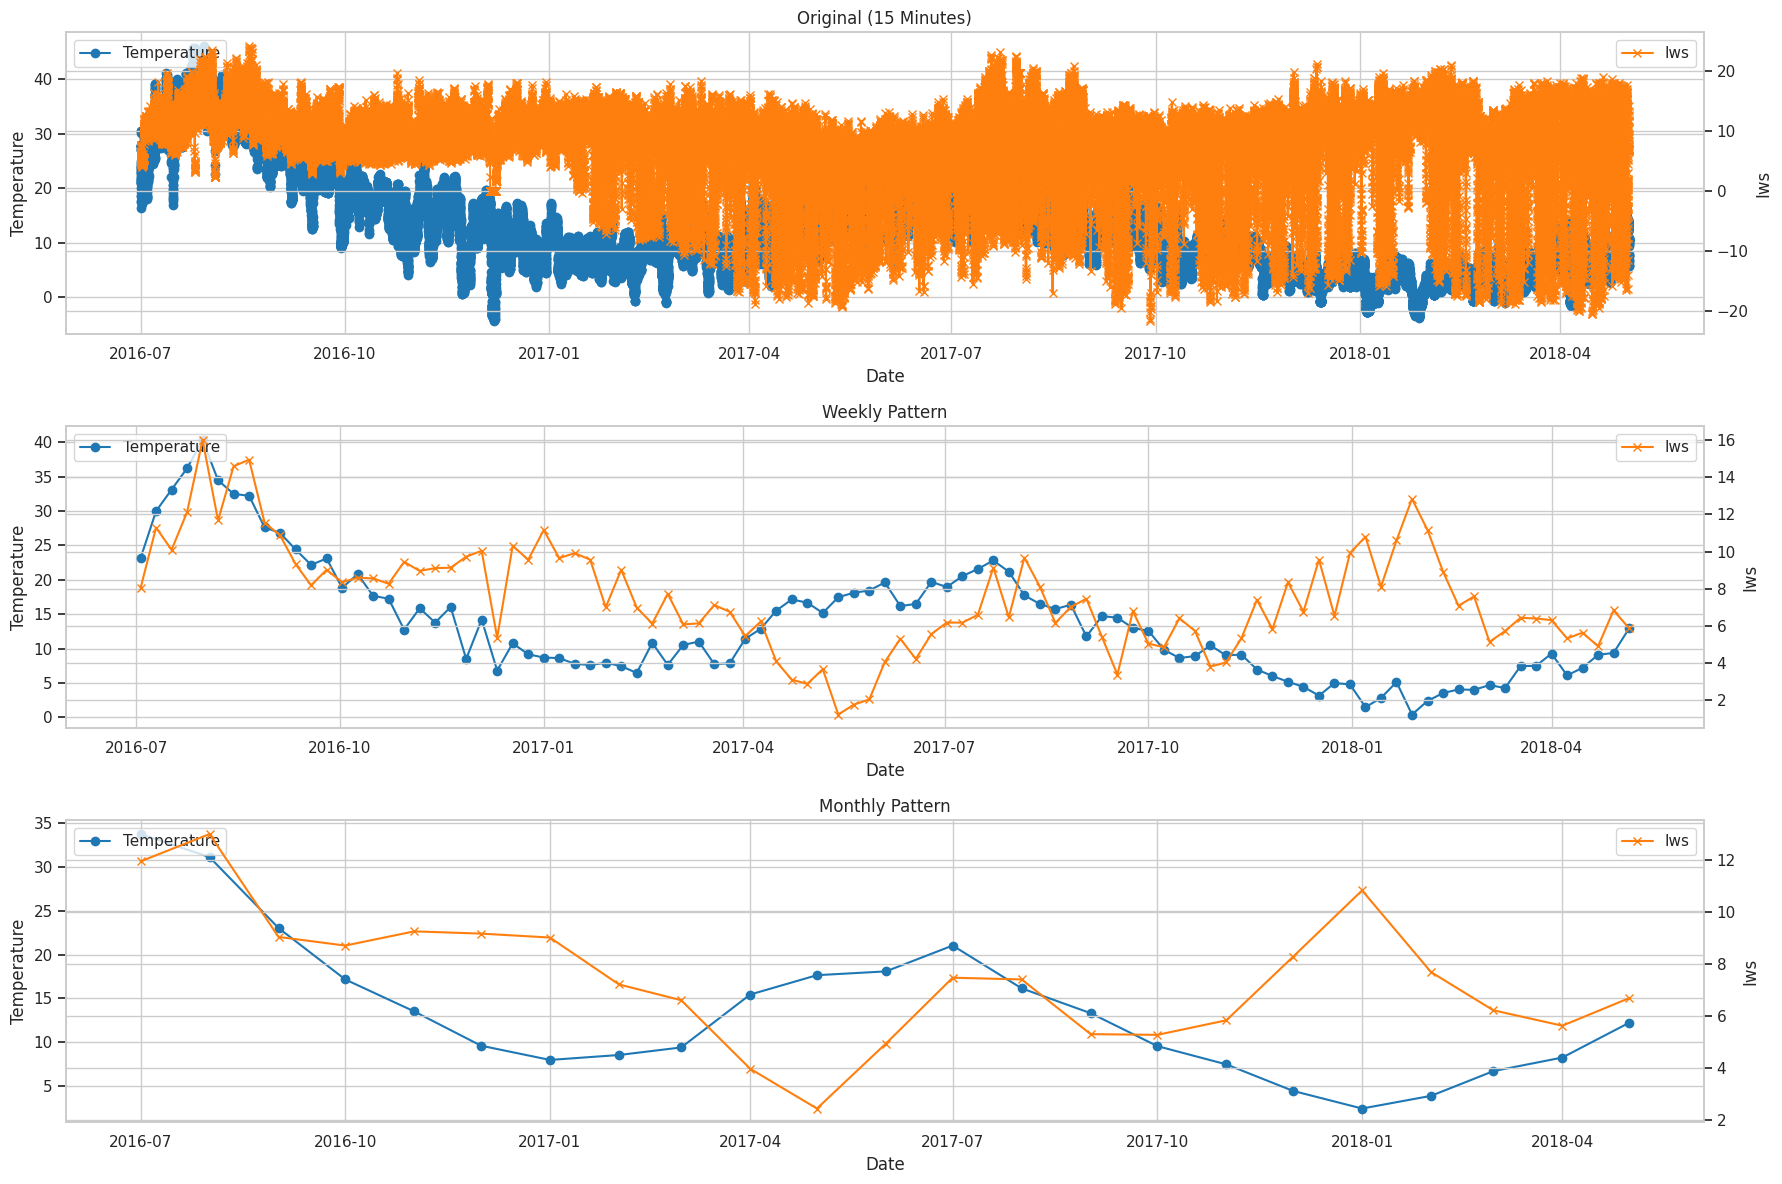

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['Iws'], label='Iws', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('Iws')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['Iws'], label='Iws', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('Iws')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['Iws'], label='Iws', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('Iws')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, terlihat adanya pola hubungan antara **Iws** dan **Temperature**. Peningkatan Temperature akan mengakibatkan penurunan Iws, begitupun sebaliknya.

### Ir vs Temperature

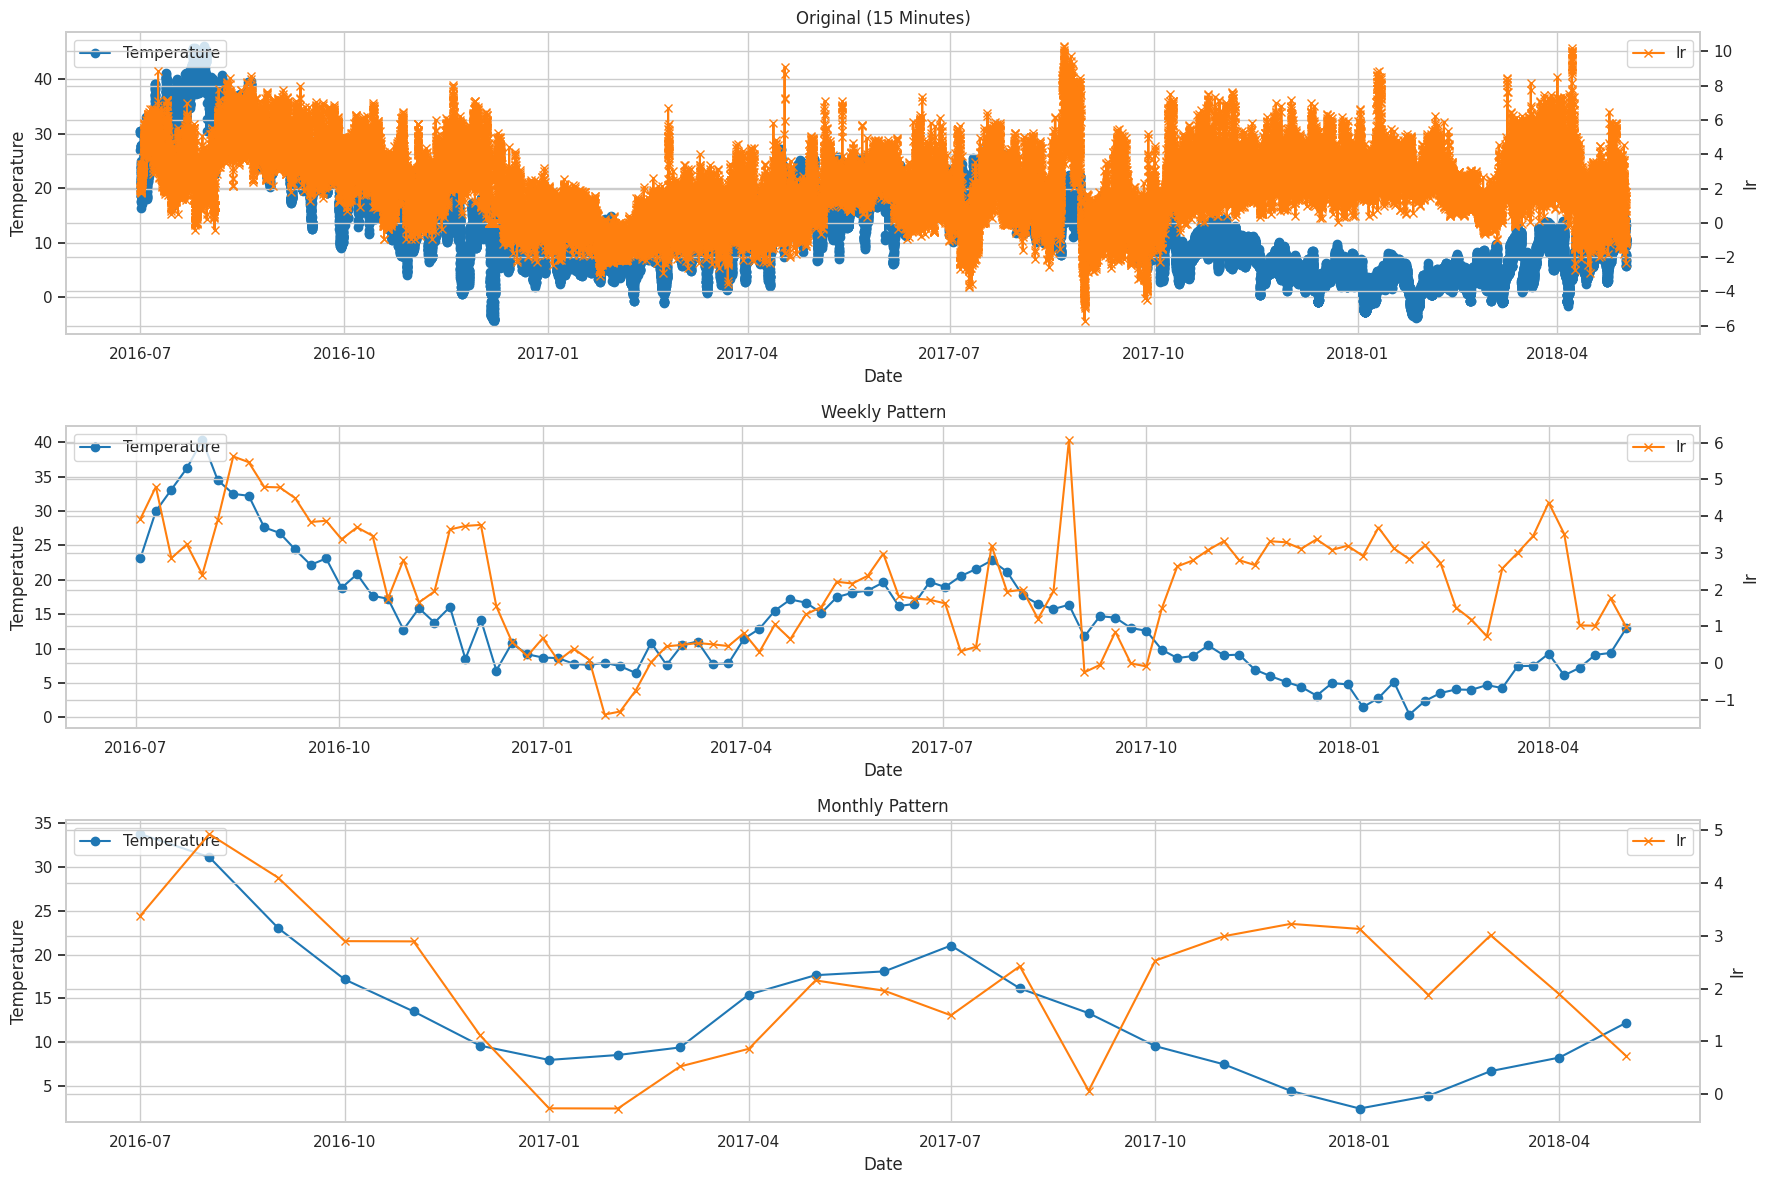

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['Ir'], label='Ir', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('Ir')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['Ir'], label='Ir', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('Ir')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['Ir'], label='Ir', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('Ir')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, tidak terlihat pola untuk **Ir** ketika **Temperature** mengalami fluktuasi.

### pm2.5 vs Temperatur

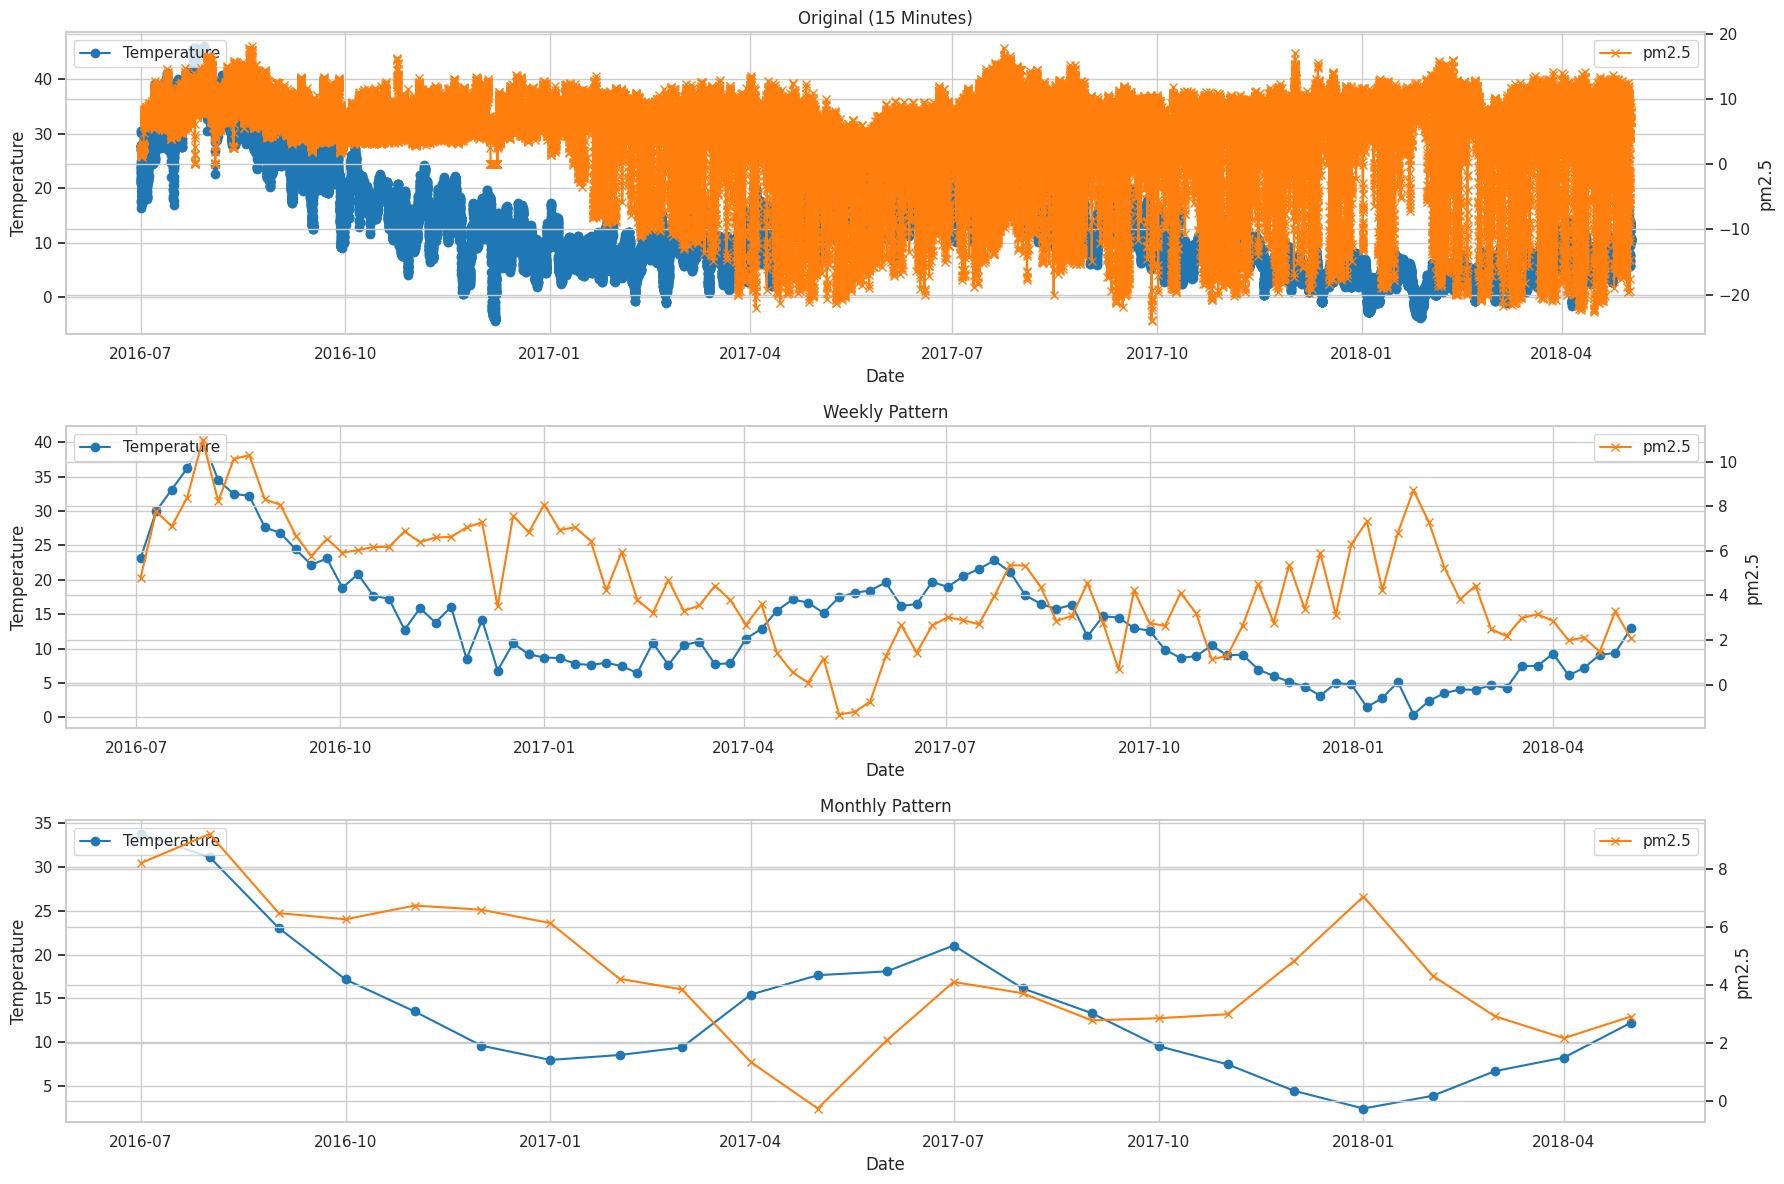

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['pm2.5'], label='pm2.5', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('pm2.5')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['pm2.5'], label='pm2.5', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('pm2.5')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['pm2.5'], label='pm2.5', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('pm2.5')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, terlihat adanya pola hubungan antara **pm2.5** dan **Temperature**. Peningkatan Temperature akan mengakibatkan penurunan pm2.5, begitupun sebaliknya.

### PRES vs Temperature

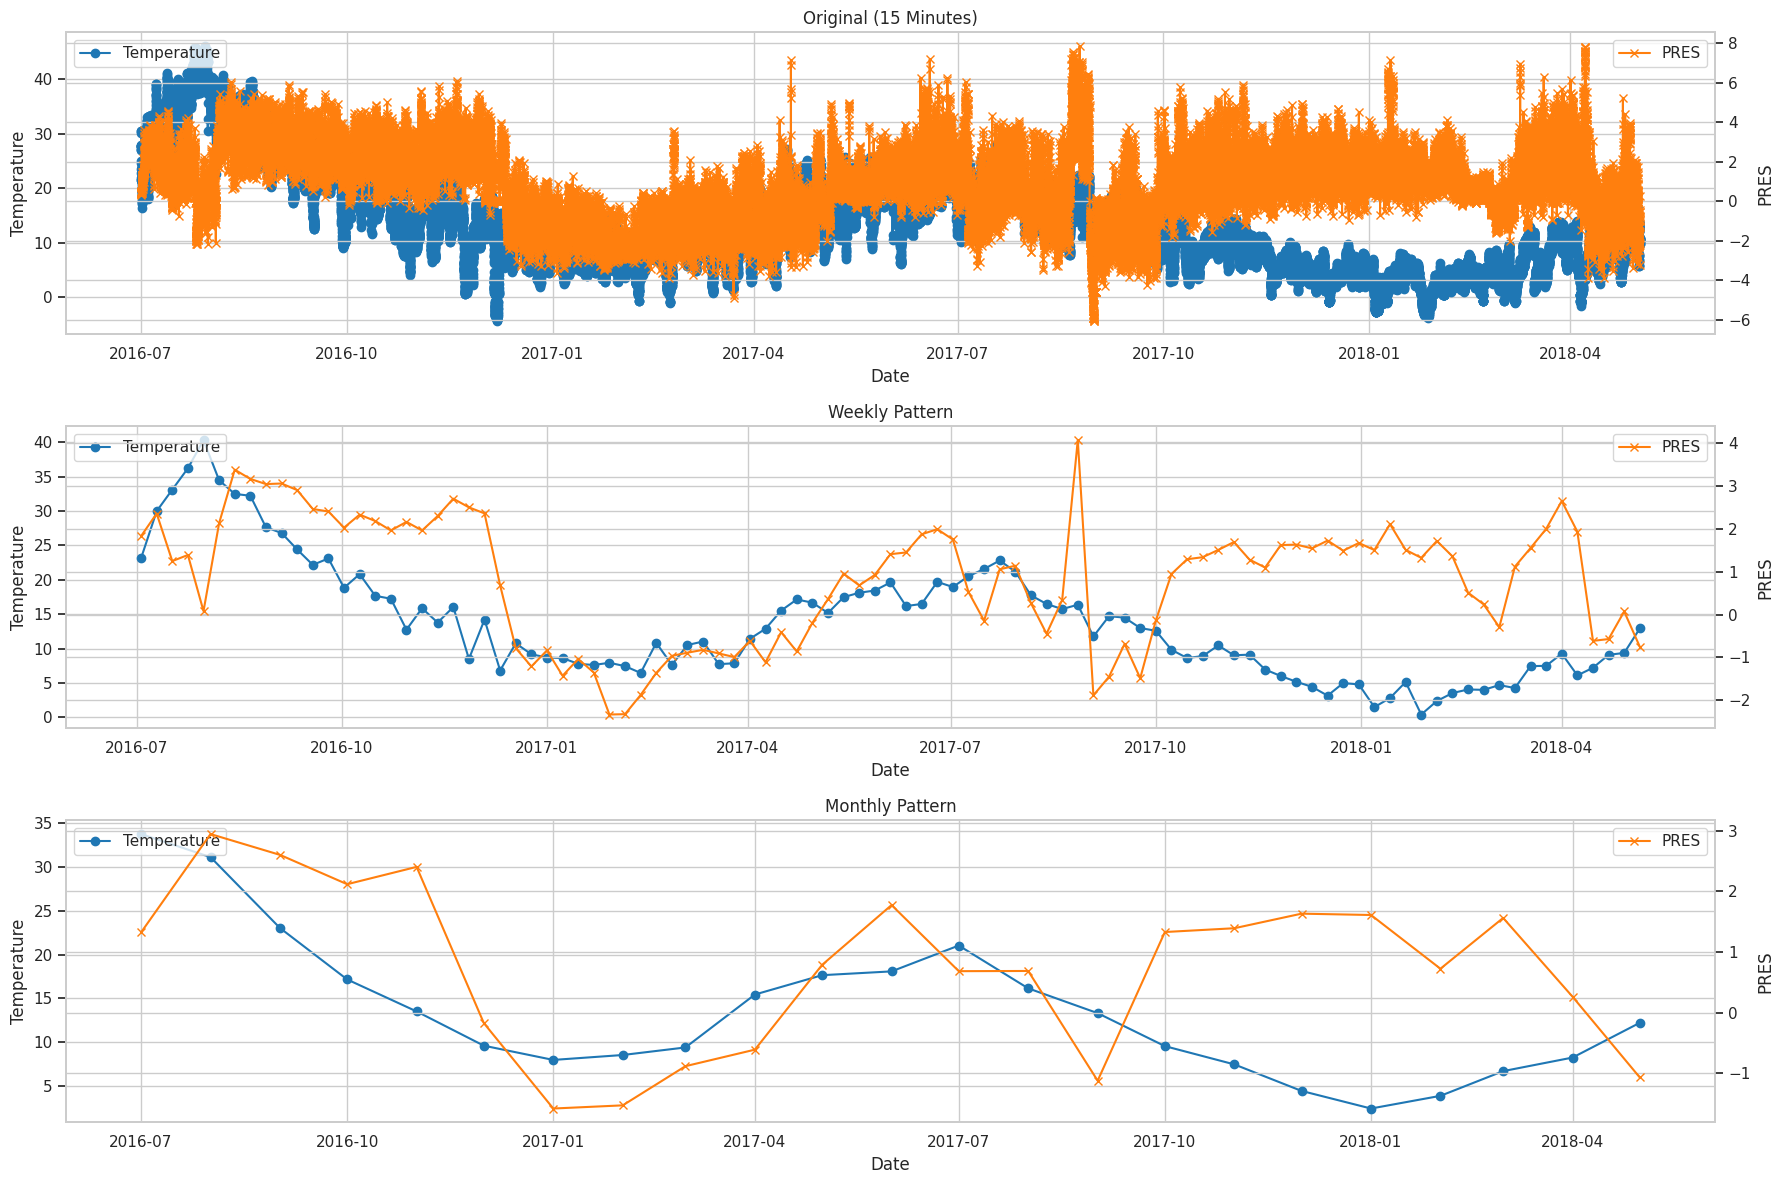

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['PRES'], label='PRES', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('PRES')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['PRES'], label='PRES', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('PRES')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['PRES'], label='PRES', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('PRES')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, tidak terlihat pola untuk **PRES** ketika **Temperature** mengalami fluktuasi.

### cbwd vs Temperature

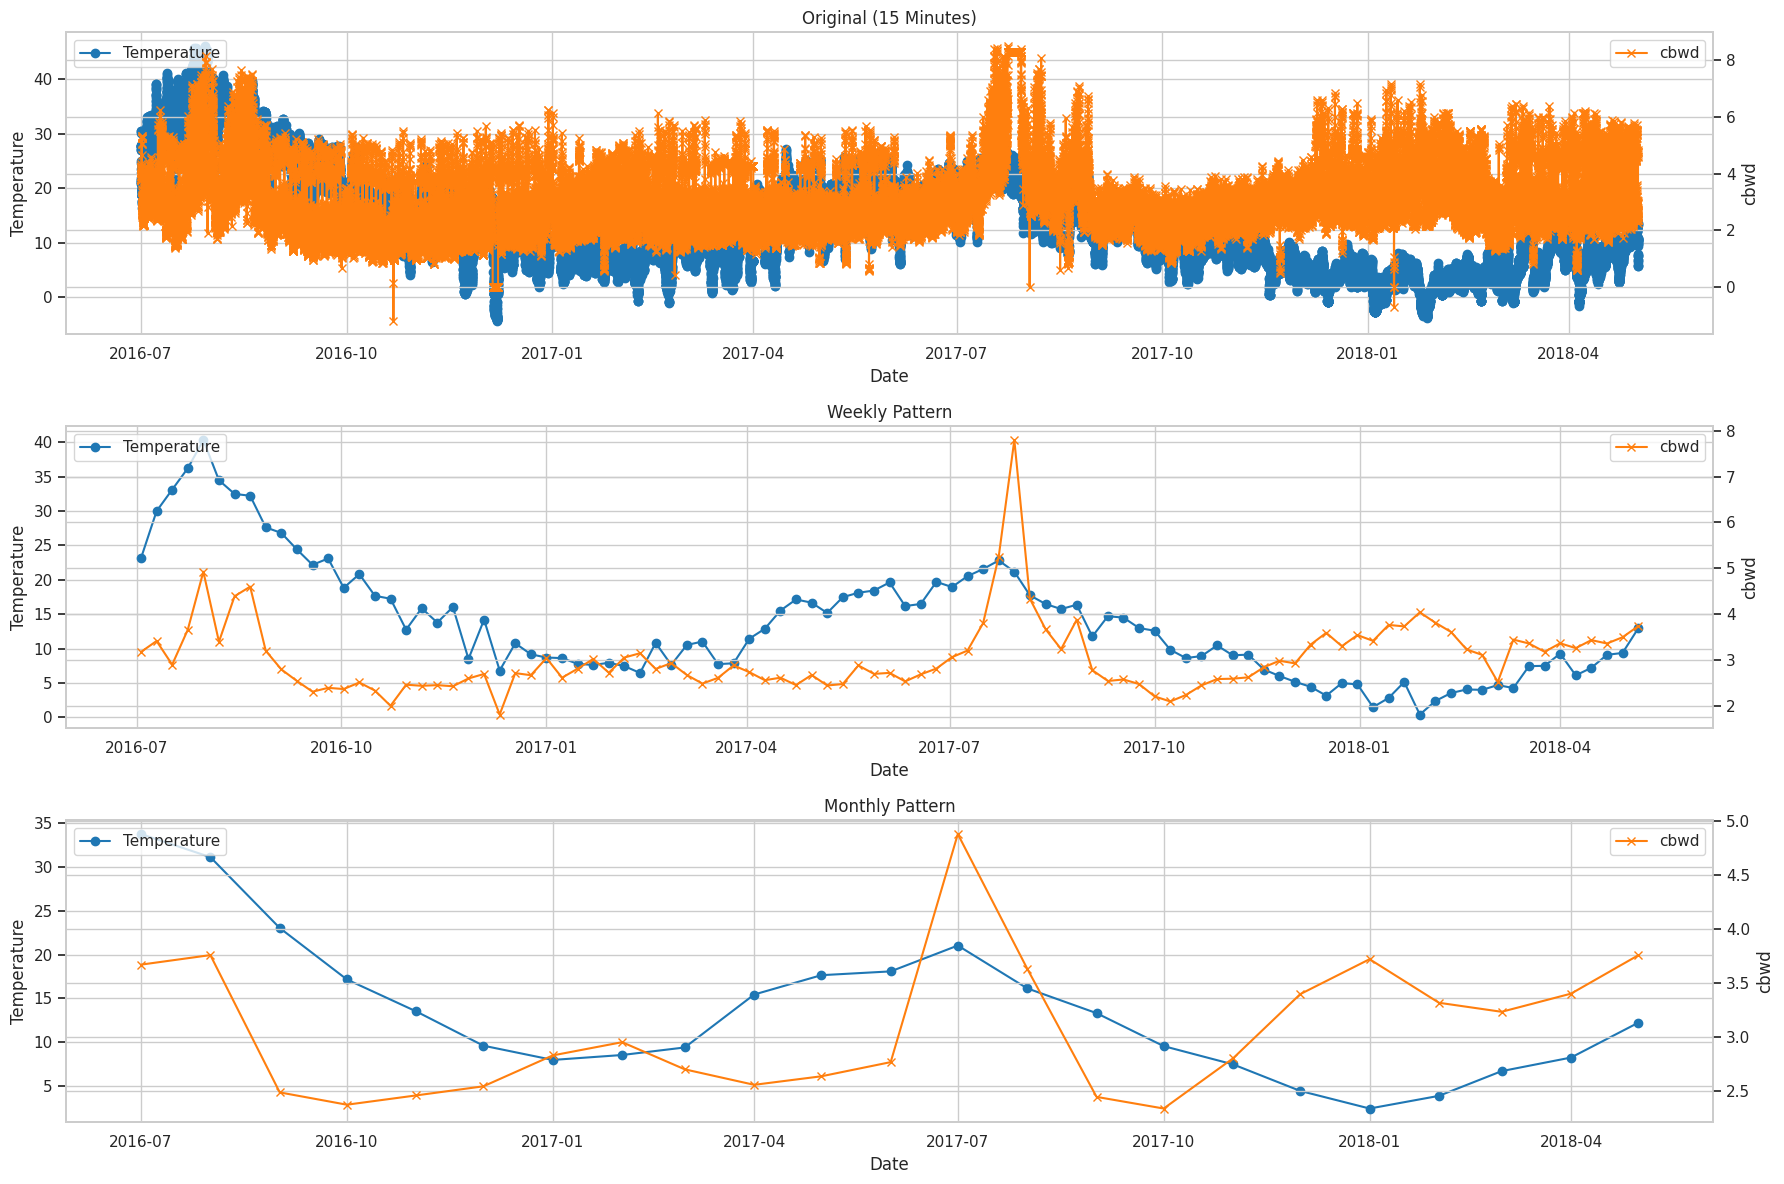

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['cbwd'], label='cbwd', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('cbwd')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['cbwd'], label='cbwd', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('cbwd')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['cbwd'], label='cbwd', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('cbwd')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, tidak terlihat pola untuk **cbwd** ketika **Temperature** mengalami fluktuasi.

### DEWP vs Temperature

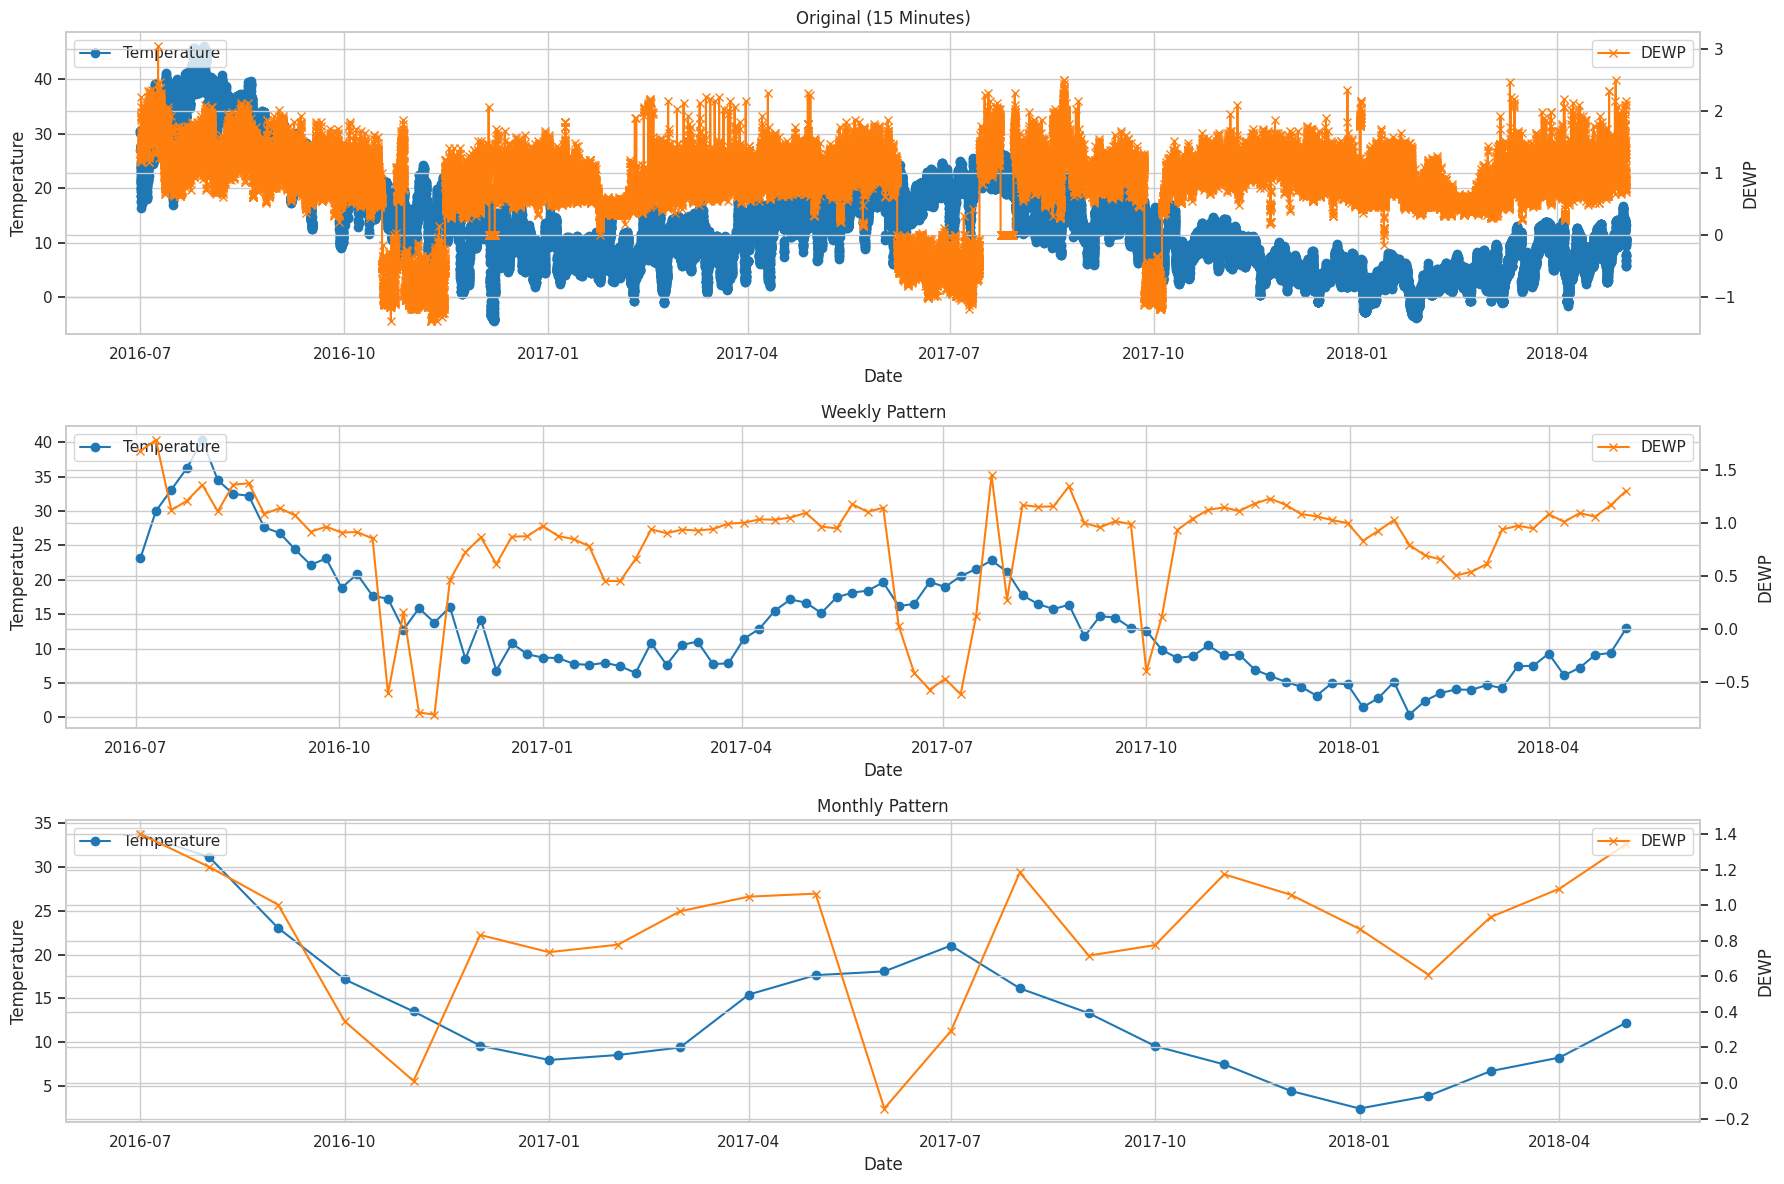

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['DEWP'], label='DEWP', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('DEWP')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['DEWP'], label='DEWP', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('DEWP')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['DEWP'], label='DEWP', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('DEWP')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, tidak terlihat pola untuk **DEWP** ketika **Temperature** mengalami fluktuasi.

### WVP vs Temperature

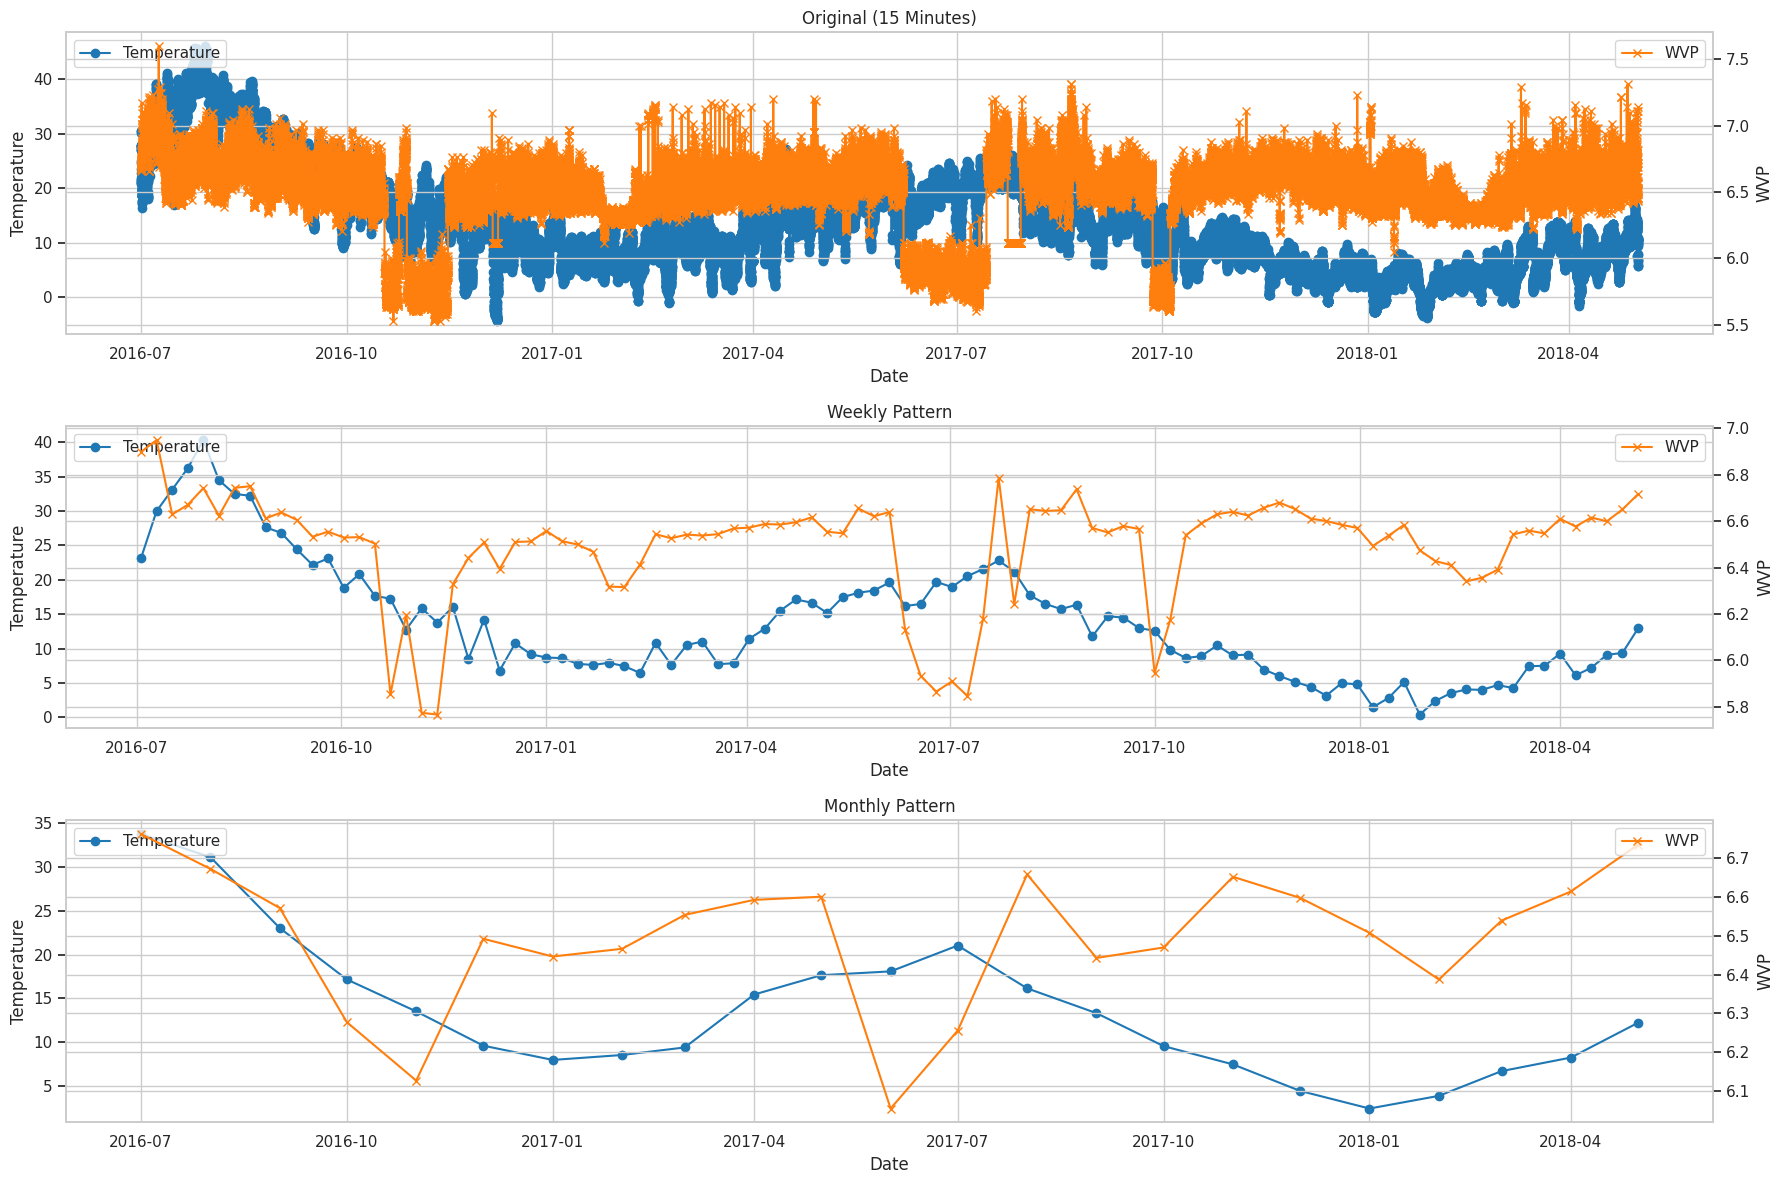

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(18,12))

# Original (15 Minutes) plot
axs[0].set_title('Original (15 Minutes)')
ax2_0 = axs[0].twinx()
axs[0].plot(df7a.index, df7a['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_0.plot(df7a.index, df7a['WVP'], label='WVP', marker='x', color='tab:orange')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature')
ax2_0.set_ylabel('WVP')
axs[0].legend(loc='upper left')
ax2_0.legend(loc='upper right')

# Weekly Pattern plot
df_week = df7a.resample('w').mean()
axs[1].set_title('Weekly Pattern')
ax2_1 = axs[1].twinx()
axs[1].plot(df_week.index, df_week['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_1.plot(df_week.index, df_week['WVP'], label='WVP', marker='x', color='tab:orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature')
ax2_1.set_ylabel('WVP')
axs[1].legend(loc='upper left')
ax2_1.legend(loc='upper right')

# Monthly Pattern plot
df_month = df7a.resample('MS').mean()
axs[2].set_title('Monthly Pattern')
ax2_2 = axs[2].twinx()
axs[2].plot(df_month.index, df_month['Temperature'], label='Temperature', marker='o', color='tab:blue')
ax2_2.plot(df_month.index, df_month['WVP'], label='WVP', marker='x', color='tab:orange')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature')
ax2_2.set_ylabel('WVP')
axs[2].legend(loc='upper left')
ax2_2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Dari visualisasi di atas, tidak terlihat pola untuk **WVP** ketika **Temperature** mengalami fluktuasi.

### Heatmap Korelasi Antar Kolom

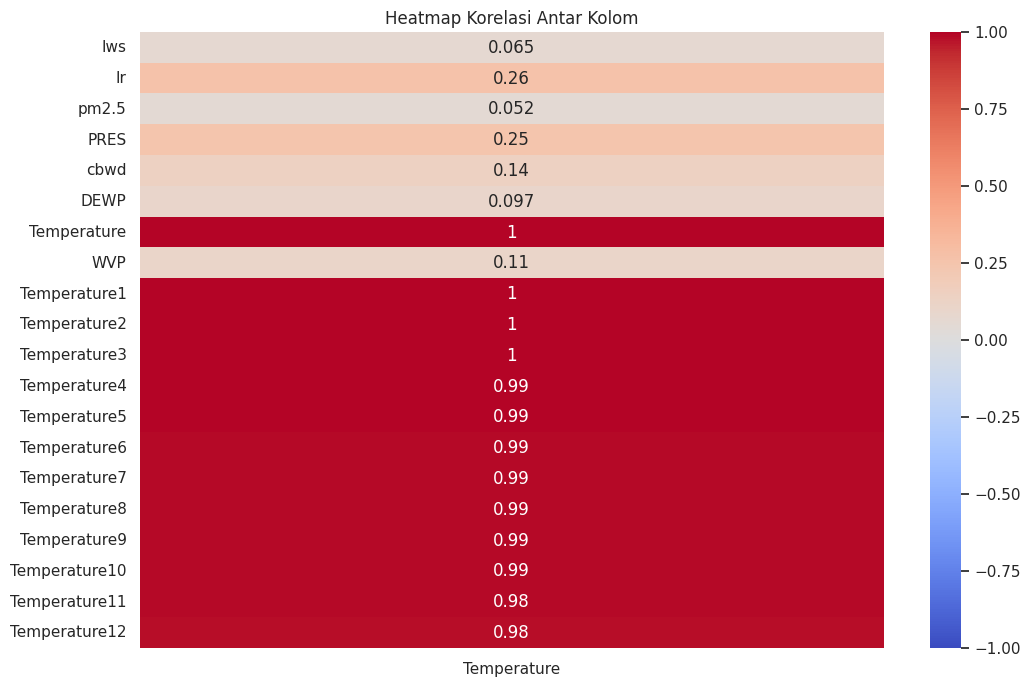

In [ ]:
df_corr = df7a.drop(columns=['Feels Like'])
for i in range(1,13):
    df_corr[f'Temperature{i}'] = df_corr[f'Temperature'].shift(i)

# Menghitung matriks korelasi
corr_matrix = df_corr.corr()['Temperature']
corr_matrix = pd.DataFrame(corr_matrix)

# Membuat heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap Korelasi Antar Kolom')
plt.show()

### Time Lagging

In [ ]:
for i in range(1,13):
    df7a[f'Temperature{i}'] = df7a[f'Temperature'].shift(i)

df7a

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature  \
date                                                                          
2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340    30.531000   
2016-07-01 00:15:00   5.760  2.076  1.492  0.426  4.264  1.401    30.459999   
2016-07-01 00:30:00   5.760  1.942  1.492  0.391  4.234  1.310    30.038000   
2016-07-01 00:45:00   5.760  1.942  1.492  0.426  4.234  1.310    27.013000   
2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371    27.787001   
...                     ...    ...    ...    ...    ...    ...          ...   
2018-05-01 22:45:00  12.458  1.407  7.889 -0.746  4.843  1.523    10.622000   
2018-05-01 23:00:00  14.200  1.541  9.310  0.284  4.752  1.249    10.482000   
2018-05-01 23:15:00  12.659  1.474  7.924 -0.959  4.569  1.310    10.271000   
2018-05-01 23:30:00  13.329  1.541  8.671 -0.533  4.630  1.371    10.341000   
2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310    10.833000   

                          WVP  Feels Like  Temperature1  ...  Temperature3  \
date                                                     ...                 
2016-07-01 00:00:00  6.731766   24.673583           NaN  ...           NaN   
2016-07-01 00:15:00  6.761259   24.659214     30.531000  ...           NaN   
2016-07-01 00:30:00  6.717304   24.222710     30.459999  ...           NaN   
2016-07-01 00:45:00  6.717304   21.197710     30.038000  ...     30.531000   
2016-07-01 01:00:00  6.746740   22.028325     27.013000  ...     30.459999   
...                       ...         ...           ...  ...           ...   
2018-05-01 22:45:00  6.820587    0.152193     10.482000  ...     10.833000   
2018-05-01 23:00:00  6.687981   -1.250966     10.622000  ...     10.693000   
2018-05-01 23:15:00  6.717304   -0.373590     10.482000  ...     10.482000   
2018-05-01 23:30:00  6.746740   -0.762877     10.271000  ...     10.622000   
2018-05-01 23:45:00  6.717304    0.938110     10.341000  ...     10.482000   

                     Temperature4  Temperature5  Temperature6  Temperature7  \
date                                                                          
2016-07-01 00:00:00           NaN           NaN           NaN           NaN   
2016-07-01 00:15:00           NaN           NaN           NaN           NaN   
2016-07-01 00:30:00           NaN           NaN           NaN           NaN   
2016-07-01 00:45:00           NaN           NaN           NaN           NaN   
2016-07-01 01:00:00        30.531           NaN           NaN           NaN   
...                           ...           ...           ...           ...   
2018-05-01 22:45:00        10.763        10.552        10.271         9.778   
2018-05-01 23:00:00        10.833        10.763        10.552        10.271   
2018-05-01 23:15:00        10.693        10.833        10.763        10.552   
2018-05-01 23:30:00        10.482        10.693        10.833        10.763   
2018-05-01 23:45:00        10.622        10.482        10.693        10.833   

                     Temperature8  Temperature9  Temperature10  Temperature11  \
date                                                                            
2016-07-01 00:00:00           NaN           NaN            NaN            NaN   
2016-07-01 00:15:00           NaN           NaN            NaN            NaN   
2016-07-01 00:30:00           NaN           NaN            NaN            NaN   
2016-07-01 00:45:00           NaN           NaN            NaN            NaN   
2016-07-01 01:00:00           NaN           NaN            NaN            NaN   
...                           ...           ...            ...            ...   
2018-05-01 22:45:00         9.849         9.919          9.426          8.020   
2018-05-01 23:00:00         9.778         9.849          9.919          9.426   
2018-05-01 23:15:00        10.271         9.778          9.849          9.919   
2018-05-01 23:30:00        10.552        10.271          9.778

# Train / Test Split

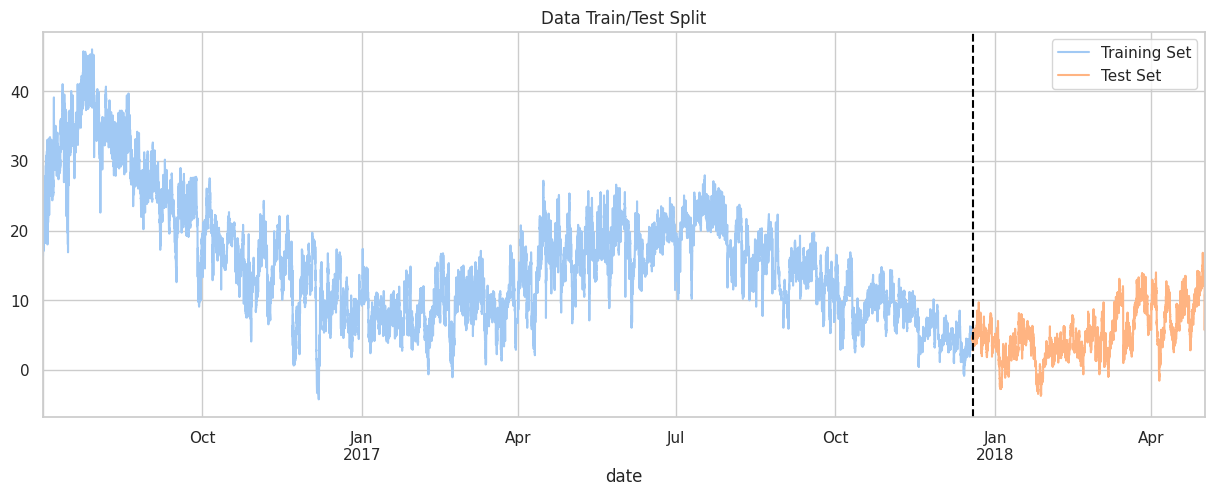

In [ ]:
train = df7a[df7a.index < '19-12-2017']
test = df7a[df7a.index >= '19-12-2017']
train = train.dropna()

fig, ax = plt.subplots(figsize=(15, 5))
train[['Temperature']].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[['Temperature']].plot(ax=ax, label='Test Set')
ax.axvline('19-12-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
FEATURES_ML = ['Iws', 'Ir', 'pm2.5', 'PRES', 'cbwd', 'DEWP', 'WVP'] + [f'Temperature{i}' for i in range(1, 11)] # Feels like dihapus, karena dia adalah nilai dari temperature
FEATURES_DL = ['Temperature', 'Iws', 'Ir', 'pm2.5', 'PRES', 'cbwd', 'DEWP', 'WVP']
TARGET = 'Temperature'

X_train_ML = train[FEATURES_ML]
y_train_ML = train[TARGET]

X_test_ML = test[FEATURES_ML]
y_test_ML = test[TARGET]

X_train_DL = train[FEATURES_DL]
y_train_DL = train[TARGET]

X_test_DL = test[FEATURES_DL]
y_test_DL = test[TARGET]

# Modelling

## 1. Random Forest

In [ ]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train_ML, y_train_ML)
forecast_rf = model_rf.predict(X_test_ML)

model_rf_path = '/content/drive/My Drive/models/rf_model.pkl'

joblib.dump(model_rf, model_rf_path)

['/content/drive/My Drive/models/rf_model.pkl']

In [ ]:
model_rf_path = '/content/drive/My Drive/models/rf_model.pkl'

model_rf_loaded = joblib.load(model_rf_path)

forecast_rf = model_rf_loaded.predict(X_test_ML)

### Random Forest Random Search CV

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=10)]
max_depths = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 4, 6]
max_features = ['sqrt','auto']

random_grid = {'n_estimators' : n_estimators,
               'max_depth' : max_depths,
               'min_samples_split' : min_samples_splits,
               'min_samples_leaf' : min_samples_leafs,
               'max_features' : max_features}

random_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 6],
 'max_features': ['sqrt', 'auto']}

In [ ]:
rf_randomcv = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                 n_iter = 100,
                                 param_distributions = random_grid,
                                 cv=4,
                                 verbose=2,
                                 random_state=42)

In [ ]:
rf_randomcv.fit(X_train_ML, y_train_ML)

randomcv_path = '/content/drive/My Drive/models/rf_randomcv.pkl'

joblib.dump(rf_randomcv, randomcv_path)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time=  31.0s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time=  31.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time=  31.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time=  31.2s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=450; total time=  40.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=450; total time=  40.8s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=450; total time=  41.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_esti

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.1min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  49.5s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.2s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.7s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=500; total time=  38.1s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=500; total time=  38.7s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=500; total time=  39.0s
[CV] END max_depth=90, max_features=sqrt

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  52.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  53.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  53.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  53.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   9.9s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.0s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  10.0s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  41.0s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  41.6s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  41.9s
[CV] END max_depth=60, max_features=

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.2s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=  38.3s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=  39.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=  39.5s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=  39.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.4s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.3min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=450; total time= 2.4min
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.8s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150; total time=  47.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150; total time=  47.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150; total time=  47.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=150; total time=  47.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time= 1.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  38.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.4s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  27.0s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  27.4s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  27.5s
[CV] END max_depth=60, max_features=s

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time= 1.8min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.8s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time= 2.4min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=250; total time=  19.2s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=250; total time=  19.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=250; total time=  19.6s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=250; total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=450; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time= 1.0min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=  44.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=  45.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=  45.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=  45.0s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  26.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  26.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=  26.8s
[CV] END max_depth=50, max_features=sqrt

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.7min
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=150; total time=  11.5s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=150; total time=  11.7s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=150; total time=  11.8s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=150; total time=  11.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=  24.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=  24.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=250; total time=  24.6s
[CV] END max_depth=40, max_features=sqr

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.7min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time=  19.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time=  19.7s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time=  19.8s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=250; total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  47.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  47.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  47.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  47.4s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  11.6s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  11.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  11.9s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=150; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  42.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  43.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=200; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  50.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  50.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  50.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  51.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time= 1.0min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  14.3s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  14.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  14.5s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  14.4s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  26.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  27.2s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=350; total time=  27.4s
[CV] END max_depth=100, max_f

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  17.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  16.7s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.0s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.1s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  17.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  31.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  31.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  31.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=  31.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  15.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  17.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  17.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  17.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  17.7s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=  30.7s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=  31.2s
[CV] END max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=  31.4s
[CV] END max_depth=80, max_features=sqrt,

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 2.6min
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  44.6s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  45.3s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  45.6s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  45.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time= 1.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=  31.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=  31.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=  31.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100; total time=  31.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=300; total time=  22.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=300; total time=  23.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=300; total time=  23.4s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=300; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time= 1.4min
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  42.7s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  43.0s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  43.4s
[CV] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=  43.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  40.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  39.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  40.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  39.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=70, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500; total time= 1.8min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  14.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  14.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  14.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  14.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  35.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  36.2s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=  36.5s
[CV] END max_depth=100, max_featu

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  41.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  42.9s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  38.8s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  39.1s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  31.3s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  31.6s
[CV] END max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  31.9s
[CV] END max_depth=70, max_features=sqr

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=400; total time= 1.4min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time= 1.1min
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.2s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  25.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  25.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  25.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  25.7s
[CV] END max_depth=30, max_features=sqrt

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 1.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time= 2.7min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  35.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  35.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  35.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  35.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, m

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  41.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  42.7s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  42.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  43.0s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450; total time=  37.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450; total time=  38.3s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=450; total time=  38.6s
[CV] END max_depth=100, max_features=

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=  15.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=90, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50; total time=  15.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time= 2.1min
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.8s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  34.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  34.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  34.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  34.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.7s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.8s
[CV] END max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


['/content/drive/My Drive/models/rf_randomcv.pkl']

In [ ]:
randomcv_path = '/content/drive/My Drive/models/rf_randomcv.pkl'

rf_randomcv_loaded = joblib.load(randomcv_path)

rf_randomcv_loaded.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [ ]:
y_test_rf_random = rf_randomcv_loaded.predict(X_test_ML)

rscore_rf_random = r2_score(y_test_ML, y_test_rf_random)
mae_rf_random = mean_absolute_error(y_test_ML, y_test_rf_random)
mse_rf_random = mean_squared_error(y_test_ML, y_test_rf_random)
rmse_rf_random = mean_squared_error(y_test_ML, y_test_rf_random, squared=False)

print('Random Forest Random Search CV')
print(f'Mean Squared Error                  : {mse_rf_random:,.2f}')
print(f'Root Mean Squared Error             : {rmse_rf_random:,.2f}')
print(f'Mean Absolute Error                 : {mae_rf_random:,.2f}')
print(f'R-squared                           : {rscore_rf_random:.2f}')

Random Forest Random Search CV
Mean Squared Error                  : 0.11
Root Mean Squared Error             : 0.33
Mean Absolute Error                 : 0.23
R-squared                           : 0.99


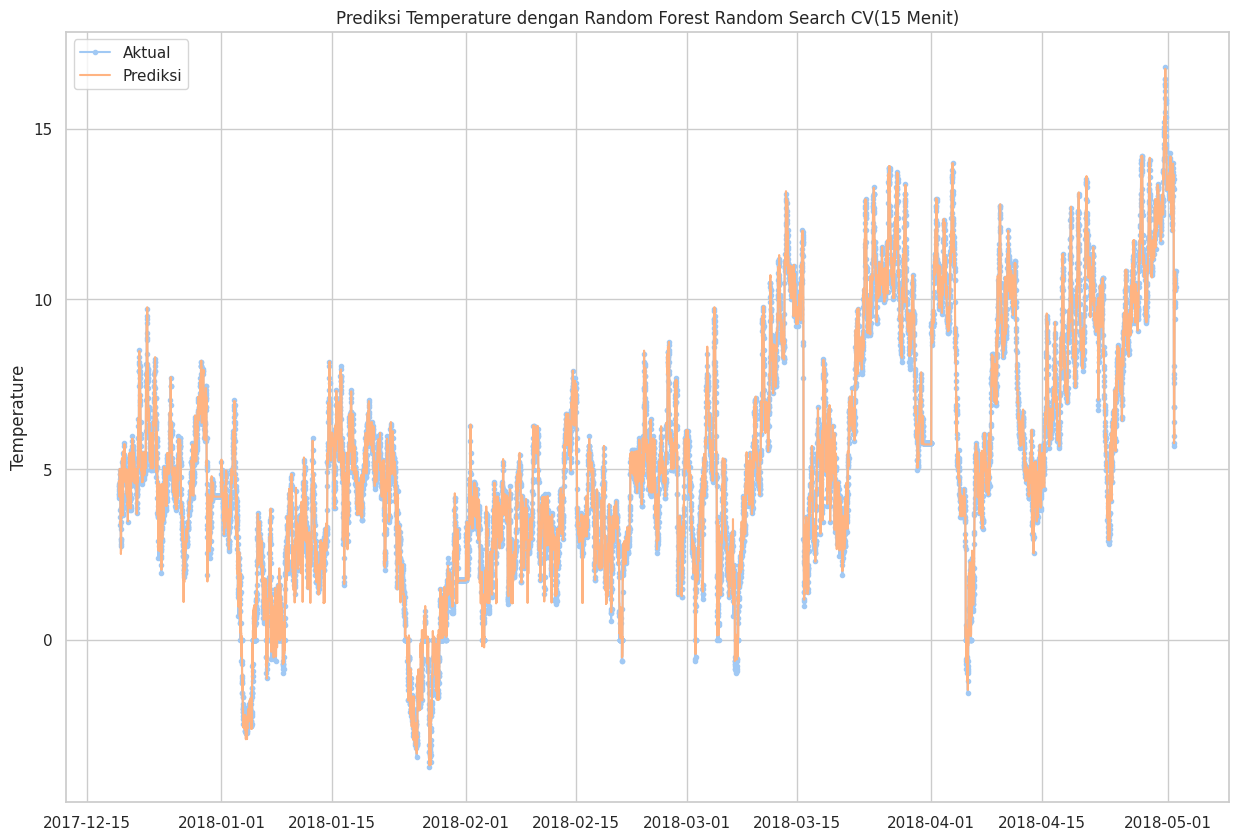

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y_test_ML.index, y_test_ML, marker='.', label="Aktual")
plt.plot(y_test_ML.index, y_test_rf_random, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Random Search CV(15 Menit)')
plt.legend()
plt.show()

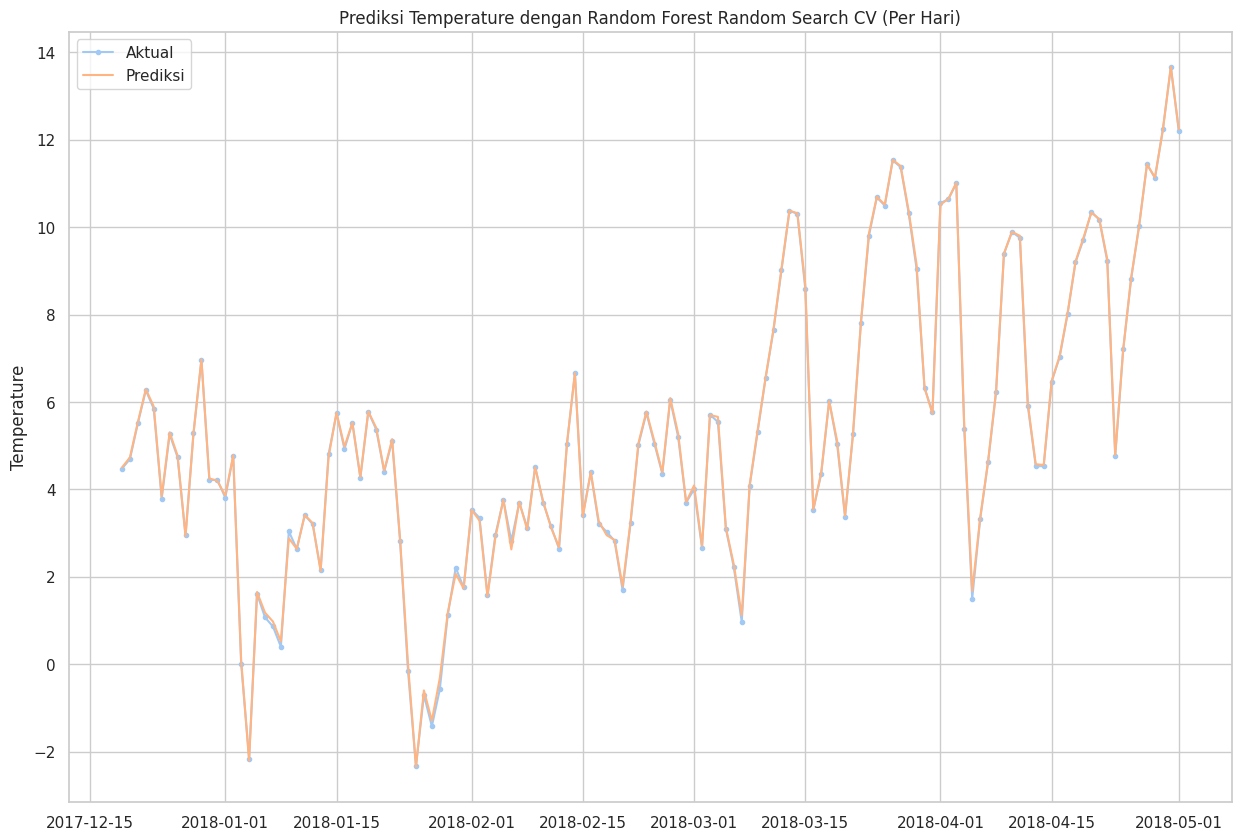

In [ ]:
# Resample data to daily frequency
y_test_daily = y_test_ML.resample('D').mean()
y_test_rf_random_daily = pd.Series(y_test_rf_random, index=y_test_ML.index).resample('D').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_daily.index, y_test_daily, marker='.', label="Aktual")
plt.plot(y_test_daily.index, y_test_rf_random_daily, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Random Search CV (Per Hari)')
plt.legend()
plt.show()

### Random Forest Grid Search CV

In [ ]:
param_grid = {
    'max_depth' : [10, 20],
    'n_estimators' : [250, 350, 450],
    'max_features' : ['sqrt', 'auto'],
    'min_samples_leaf' : [1, 6],
    'min_samples_split' : [2, 5]
}

rf_gridcv = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = param_grid,
    cv = 4,
    verbose=2,
    n_jobs=-1
)

rf_gridcv.fit(X_train_ML, y_train_ML)

gridcv_path = '/content/drive/My Drive/models/rf_gridcv.pkl'

joblib.dump(rf_gridcv, gridcv_path)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


['/content/drive/My Drive/models/rf_gridcv.pkl']

In [ ]:
gridcv_path = '/content/drive/My Drive/models/rf_gridcv.pkl'

loaded_rf_gridcv = joblib.load(gridcv_path)

loaded_rf_gridcv.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 350}

In [ ]:
y_test_rf_grid = loaded_rf_gridcv.predict(X_test_ML)

rscore_rf_grid = r2_score(y_test_ML, y_test_rf_grid)
mae_rf_grid = mean_absolute_error(y_test_ML, y_test_rf_grid)
mse_rf_grid = mean_squared_error(y_test_ML, y_test_rf_grid)
rmse_rf_grid = mean_squared_error(y_test_ML, y_test_rf_grid, squared=False)

print('Random Forest Grid Search CV')
print(f'Mean Squared Error                  : {mse_rf_grid:,.2f}')
print(f'Root Mean Squared Error             : {rmse_rf_grid:,.2f}')
print(f'Mean Absolute Error                 : {mae_rf_grid:,.2f}')
print(f'R-squared                           : {rscore_rf_grid:.2f}')

Random Forest Grid Search CV
Mean Squared Error                  : 0.11
Root Mean Squared Error             : 0.34
Mean Absolute Error                 : 0.23
R-squared                           : 0.99


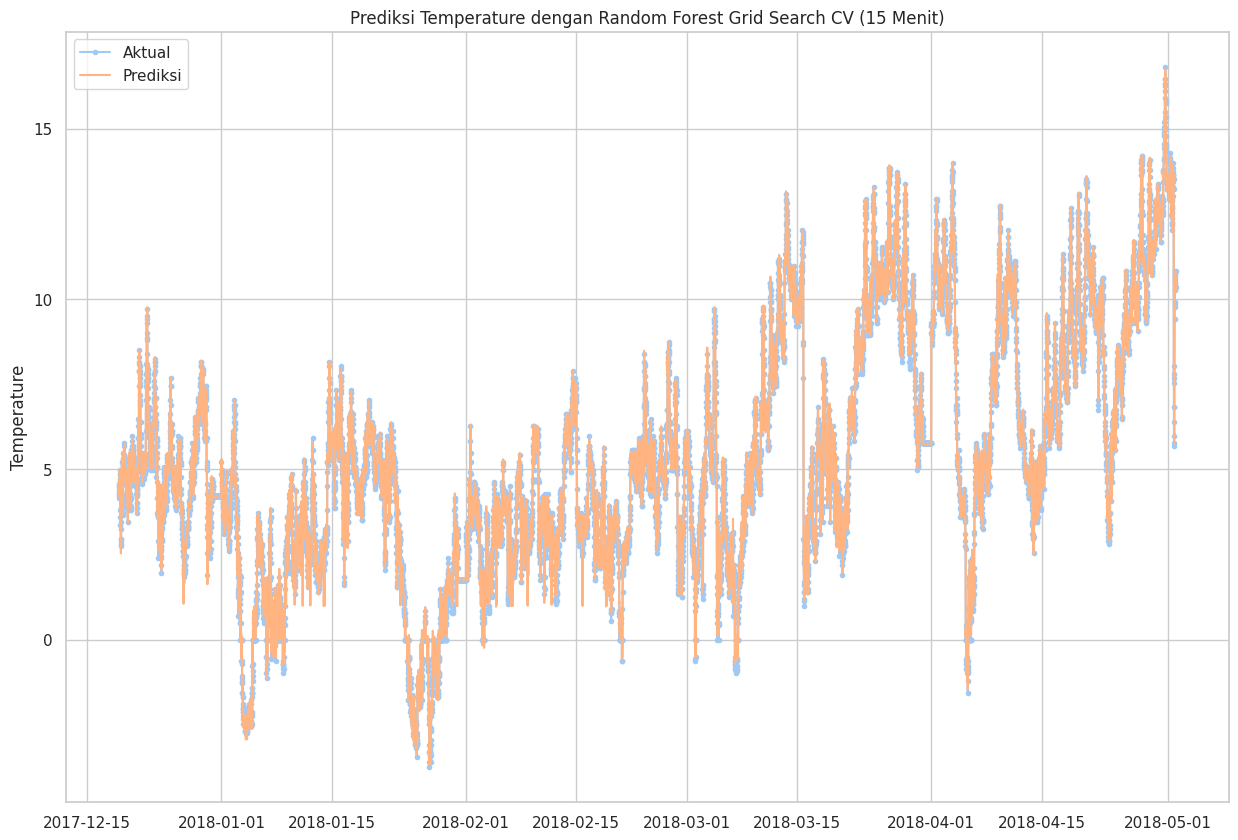

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y_test_ML.index, y_test_ML, marker='.', label="Aktual") # plt.plot(X_test_ML.index, y_test, marker='.', label="Aktual")
plt.plot(y_test_ML.index, y_test_rf_grid, label="Prediksi") # plt.plot(X_test_ML.index, y_test_rf_grid, marker='.', label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Grid Search CV (15 Menit)')
plt.legend()
plt.show()

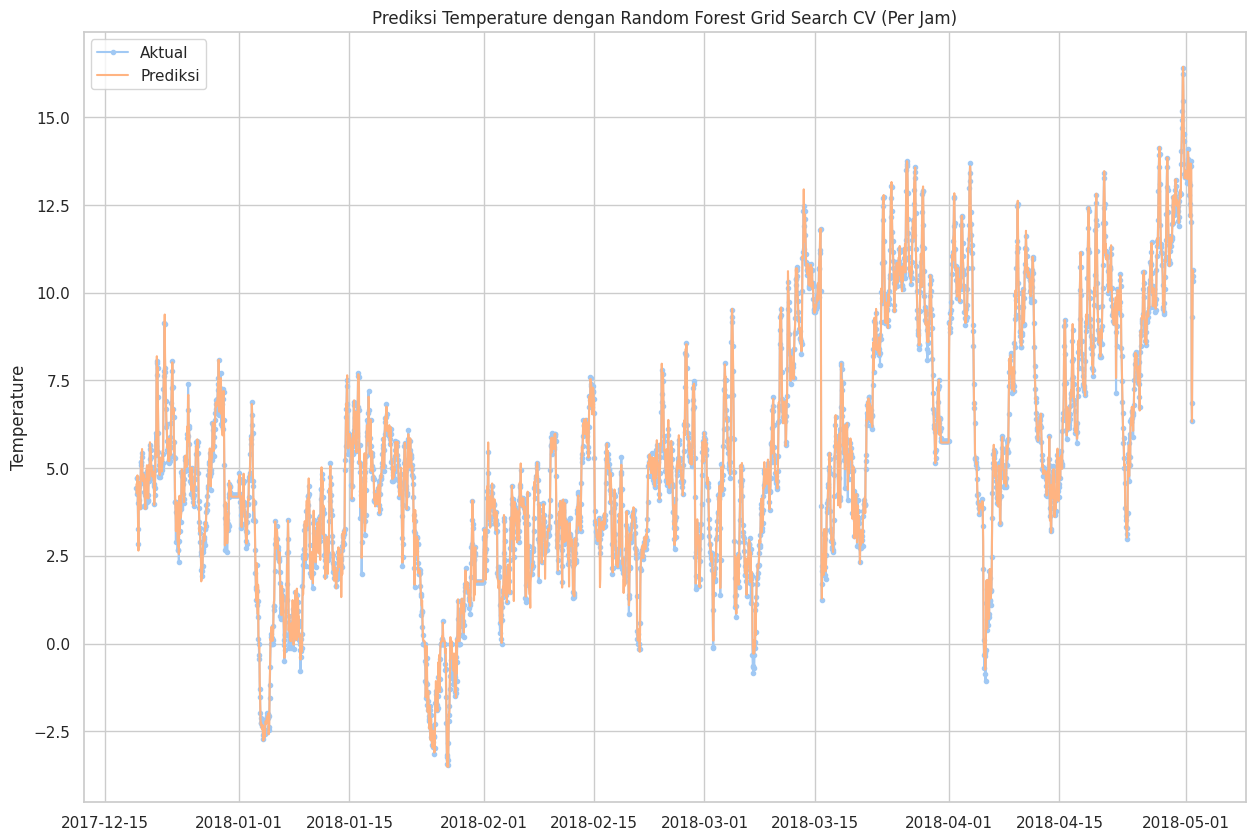

In [ ]:
# Resample data to hourly frequency
y_test_hourly = y_test_ML.resample('H').mean()
y_test_rf_grid_hourly = pd.Series(y_test_rf_grid, index=y_test_ML.index).resample('H').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_hourly.index, y_test_hourly, marker='.', label="Aktual")
plt.plot(y_test_hourly.index, y_test_rf_grid_hourly, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Grid Search CV (Per Jam)')
plt.legend()
plt.show()

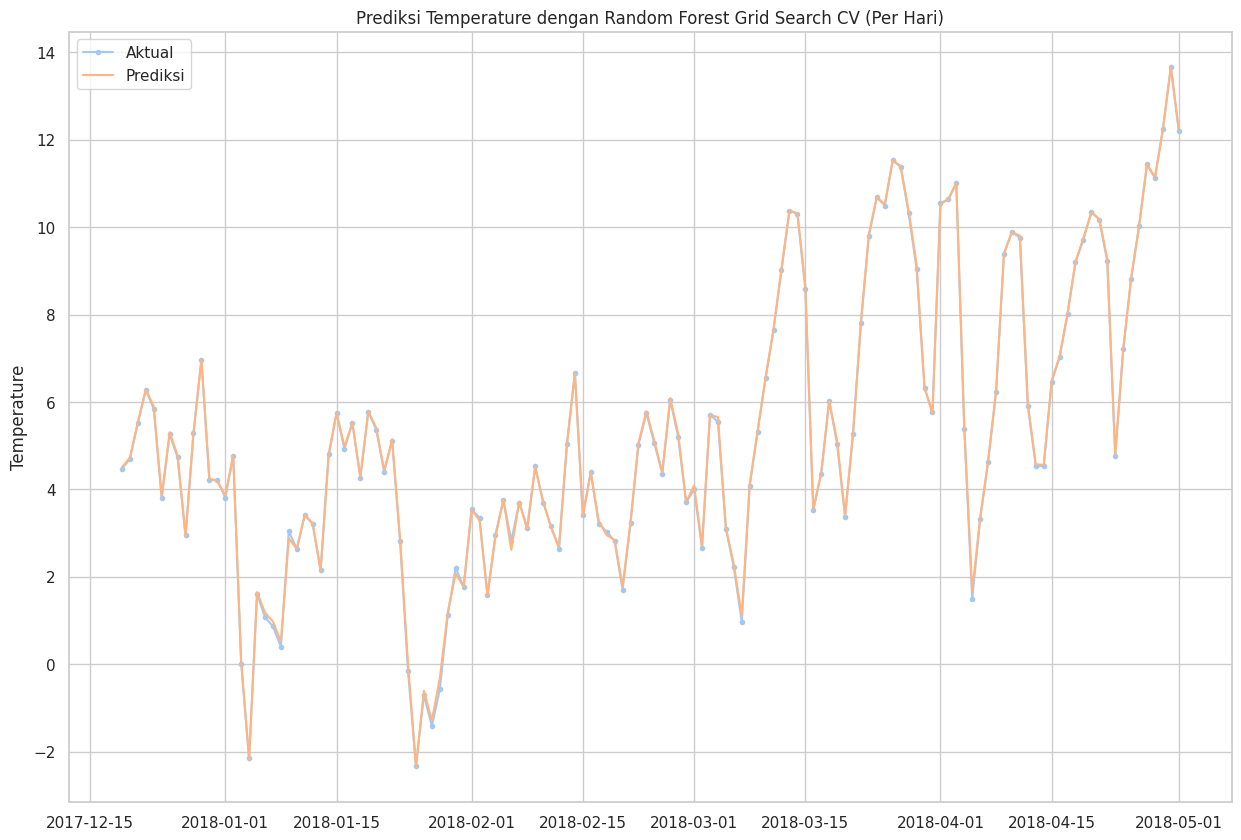

In [ ]:
# Resample data to daily frequency
y_test_daily = y_test_ML.resample('D').mean()
y_test_rf_grid_daily = pd.Series(y_test_rf_grid, index=y_test_ML.index).resample('D').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_daily.index, y_test_daily, marker='.', label="Aktual")
plt.plot(y_test_daily.index, y_test_rf_grid_daily, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Grid Search CV (Per Hari)')
plt.legend()
plt.show()

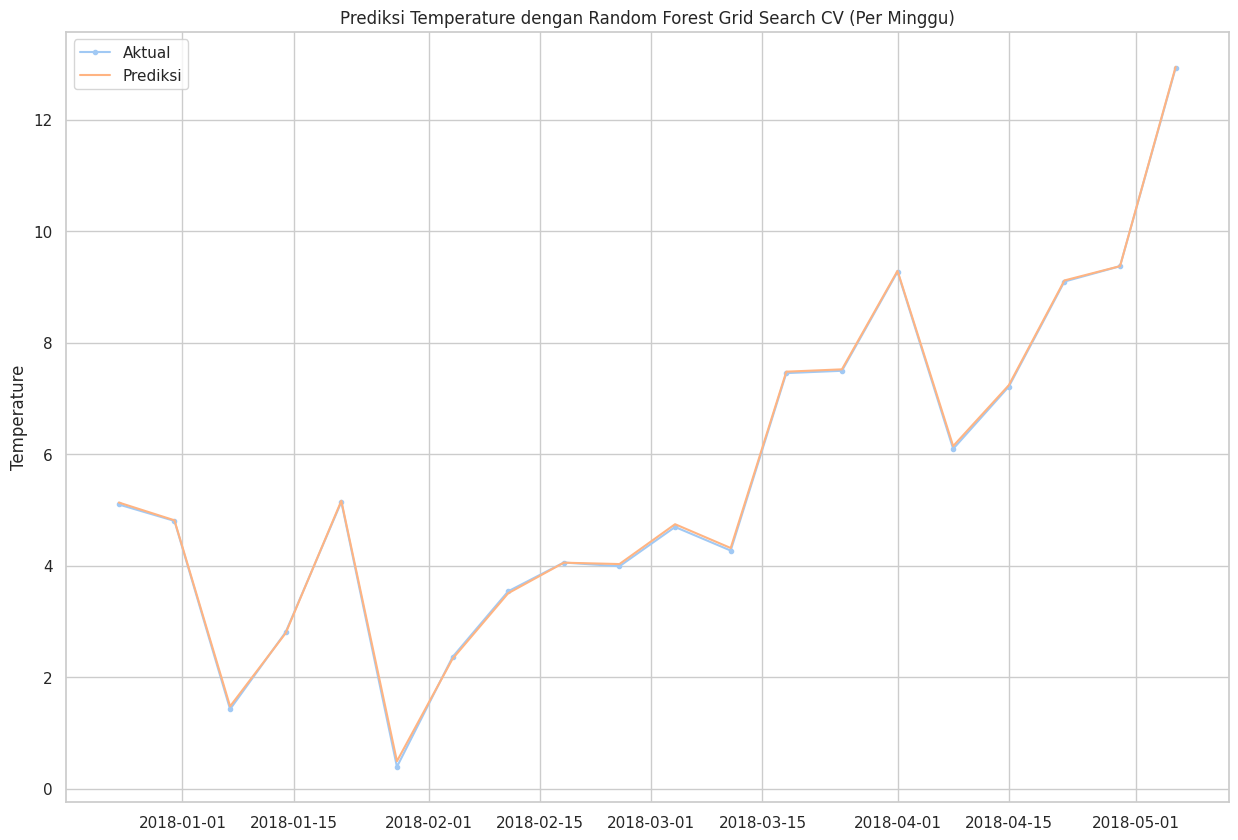

In [ ]:
# Resample data to weekly frequency
y_test_weekly = y_test_ML.resample('W').mean()
y_test_rf_grid_weekly = pd.Series(y_test_rf_grid, index=y_test_ML.index).resample('W').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_weekly.index, y_test_weekly, marker='.', label="Aktual")
plt.plot(y_test_weekly.index, y_test_rf_grid_weekly, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Grid Search CV (Per Minggu)')
plt.legend()
plt.show()

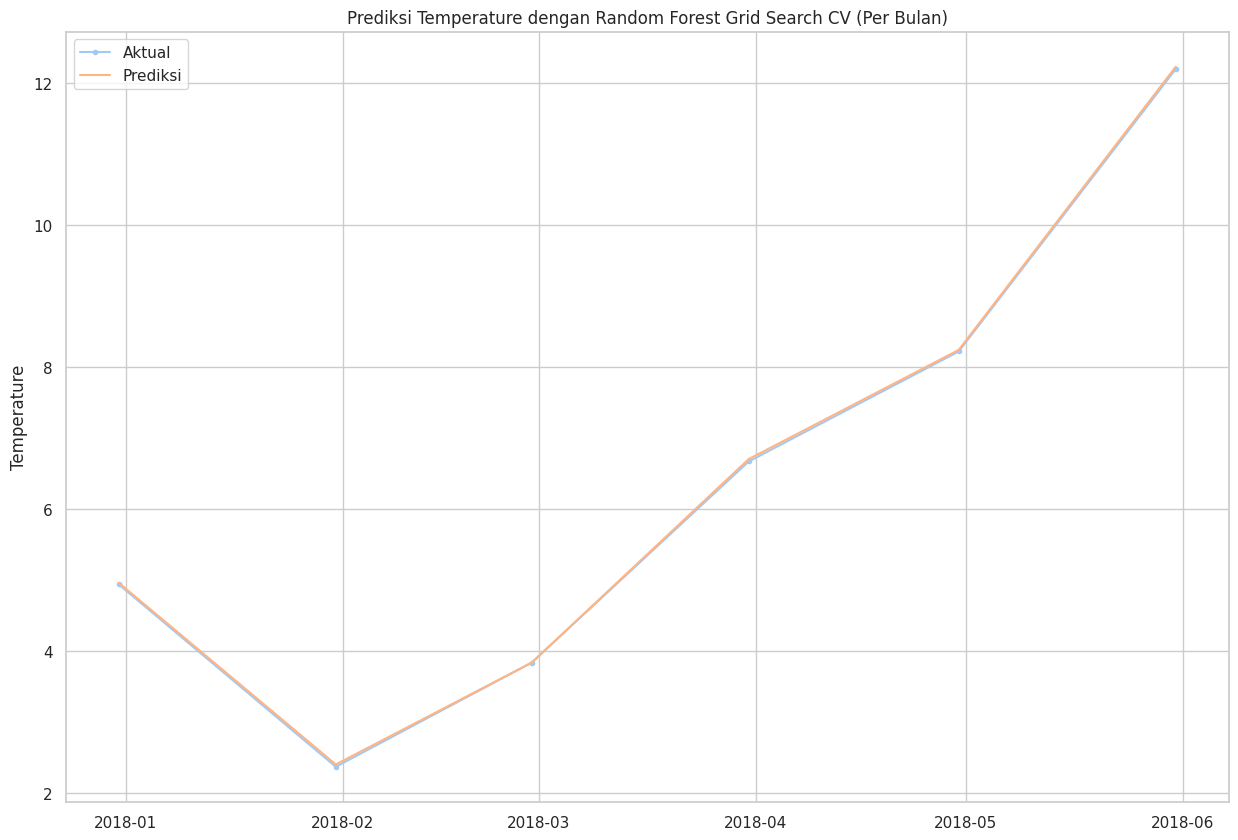

In [ ]:
# Resample data to monthly frequency
y_test_monthly = y_test_ML.resample('M').mean()
y_test_rf_grid_monthly = pd.Series(y_test_rf_grid, index=y_test_ML.index).resample('M').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_monthly.index, y_test_monthly, marker='.', label="Aktual")
plt.plot(y_test_monthly.index, y_test_rf_grid_monthly, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan Random Forest Grid Search CV (Per Bulan)')
plt.legend()
plt.show()

## 2. XGBoost

In [ ]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_ML, y_train_ML)
forecast_xgb = model_xgb.predict(X_test_ML)

model_xgb_path = '/content/drive/My Drive/models/xgb_model.pkl'

joblib.dump(model_xgb, model_xgb_path)

model_xgb.save_model('/content/drive/My Drive/models/xgb_model.json')

In [ ]:
model_xgb_path = '/content/drive/My Drive/models/xgb_model.pkl'

model_xgb_loaded = joblib.load(model_xgb_path)

forecast_xgb = model_xgb_loaded.predict(X_test_ML)

### XGBoost Random Search CV

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=10)]
max_depths = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
learning_rates = [0.01, 0.05, 0.1, 0.2]
subsamples = [0.6, 0.8, 1.0]
colsample_bytrees = [0.6, 0.8, 1.0]
min_child_weights = [1, 3, 5]

random_xgb_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depths,
    'learning_rate': learning_rates,
    'subsample': subsamples,
    'colsample_bytree': colsample_bytrees,
    'min_child_weight': min_child_weights}

random_xgb_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'learning_rate': [0.01, 0.05, 0.1, 0.2],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'min_child_weight': [1, 3, 5]}

In [ ]:
xgb_randomcv = RandomizedSearchCV(estimator=XGBRegressor(),
                                 n_iter=100,
                                 param_distributions=random_xgb_grid,
                                 cv=5,
                                 verbose=2,
                                 random_state=42,
                                 n_jobs=-1)

xgb_randomcv.fit(X_train_ML, y_train_ML)

xgbrandomcv_path = '/content/drive/My Drive/models/xgb_randomcv.pkl'

joblib.dump(xgb_randomcv, xgbrandomcv_path)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


['/content/drive/My Drive/models/xgb_randomcv.pkl']

In [ ]:
xgbrandomcv_path = '/content/drive/My Drive/models/xgb_randomcv.pkl'

xgb_randomcv_loaded = joblib.load(xgbrandomcv_path)

xgb_randomcv_loaded.best_params_

{'subsample': 1.0,
 'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 70,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8}

In [ ]:
y_test_xgb_random = xgb_randomcv_loaded.predict(X_test_ML)

rscore_xgb_random = r2_score(y_test_ML, y_test_xgb_random)
mae_xgb_random = mean_absolute_error(y_test_ML, y_test_xgb_random)
mse_xgb_random = mean_squared_error(y_test_ML, y_test_xgb_random)
rmse_xgb_random = mean_squared_error(y_test_ML, y_test_xgb_random, squared=False)

print('XGBoost Random Search CV')
print(f'Mean Squared Error                  : {mse_xgb_random:,.2f}')
print(f'Root Mean Squared Error             : {rmse_xgb_random:,.2f}')
print(f'Mean Absolute Error                 : {mae_xgb_random:,.2f}')
print(f'R-squared                           : {rscore_xgb_random:.2f}')

XGBoost Random Search CV
Mean Squared Error                  : 0.24
Root Mean Squared Error             : 0.49
Mean Absolute Error                 : 0.32
R-squared                           : 0.98


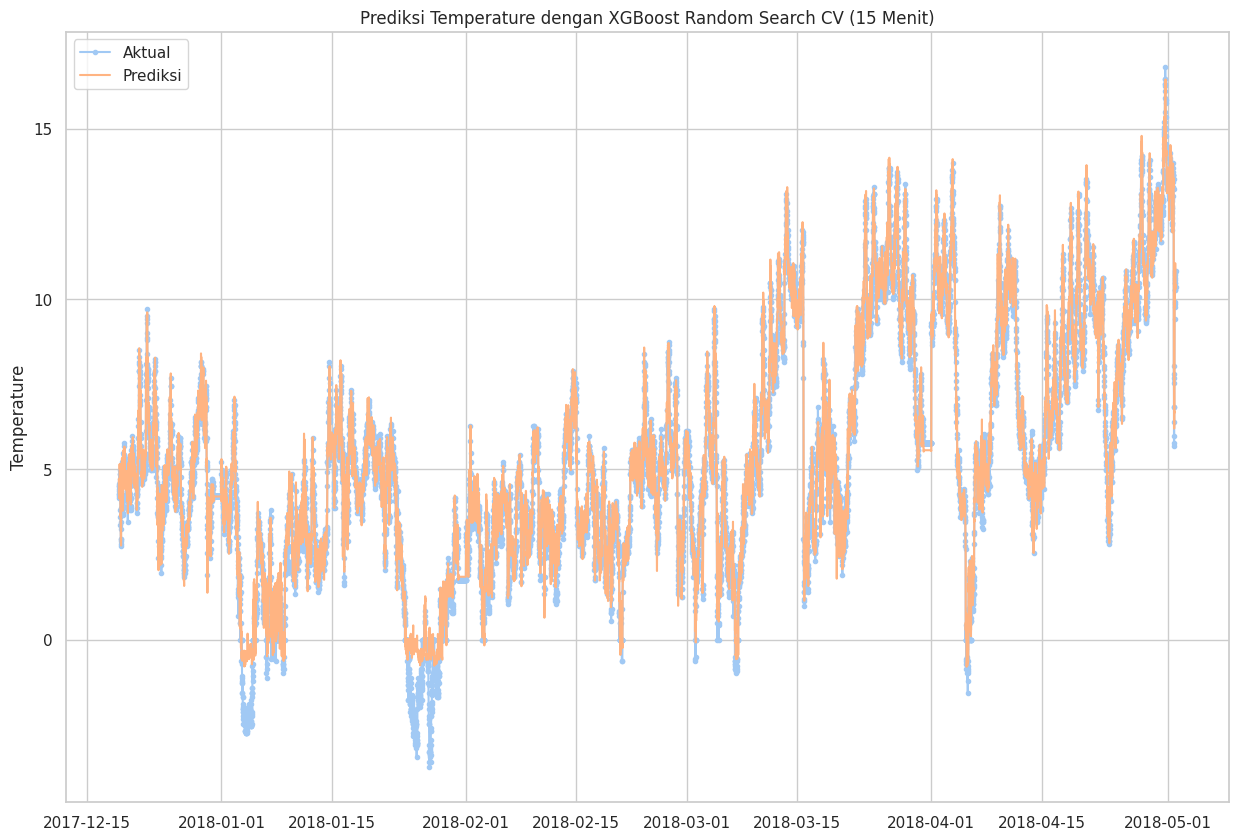

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y_test_ML.index, y_test_ML, marker='.', label="Aktual")
plt.plot(y_test_ML.index, y_test_xgb_random, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan XGBoost Random Search CV (15 Menit)')
plt.legend()
plt.show()

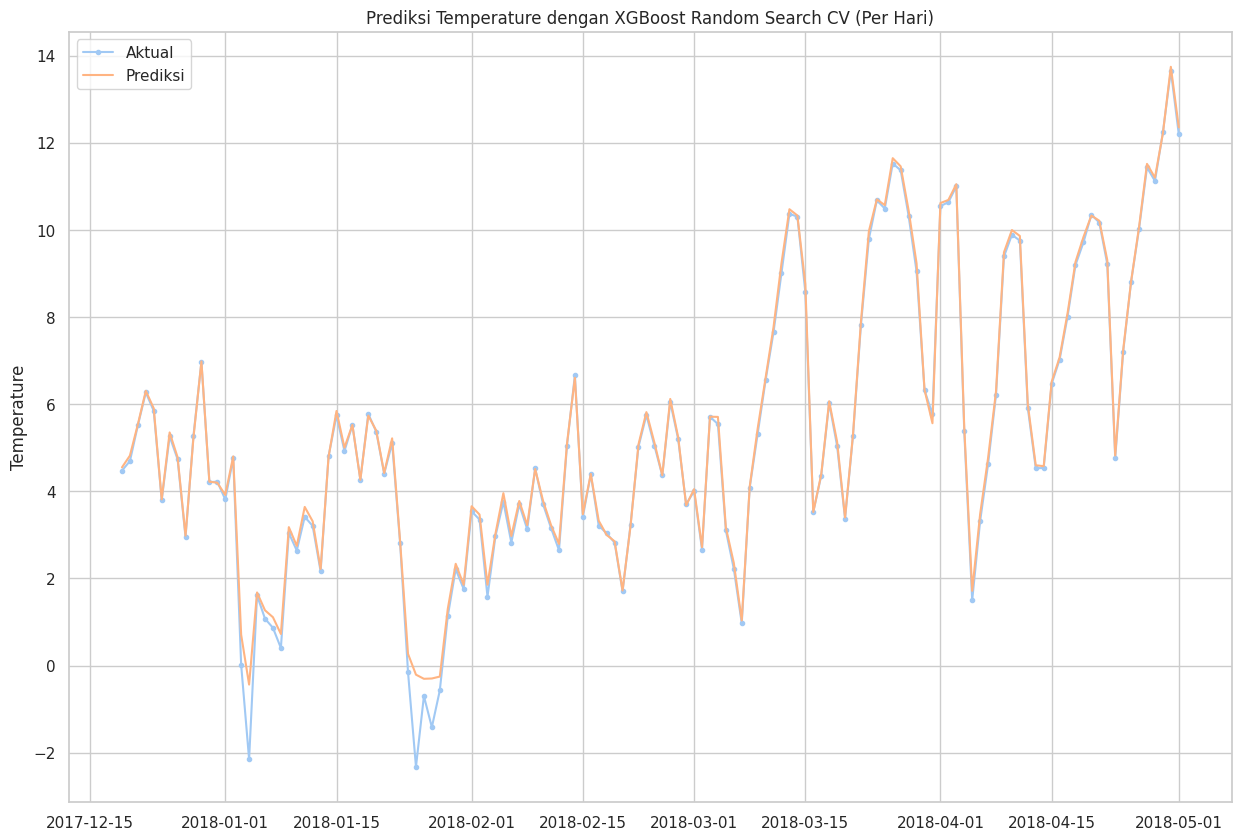

In [ ]:
# Resample data to daily frequency
y_test_daily = y_test_ML.resample('D').mean()
y_test_xgb_random_daily = pd.Series(y_test_xgb_random, index=y_test_ML.index).resample('D').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_daily.index, y_test_daily, marker='.', label="Aktual")
plt.plot(y_test_daily.index, y_test_xgb_random_daily, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan XGBoost Random Search CV (Per Hari)')
plt.legend()
plt.show()

### XGBoost Grid Search CV

In [ ]:
param_xgb = {
    'subsample' : [0.8, 1.0],
    'n_estimators' : [300, 400, 500],
    'min_child_weight' : [1, 3],
    'max_depth' : [70, 80],
    'learning_rate' : [0.1, 0.2],
    'colsample_bytree': [0.8, 1.0]
}

xgb_gridcv = GridSearchCV(
    estimator = XGBRegressor(),
    param_grid = param_xgb,
    cv = 4,
    verbose=10,
    n_jobs=-1
)

xgb_gridcv.fit(X_train_ML, y_train_ML)

gridxgb_path = '/content/drive/My Drive/models/xgb_gridcv.pkl'

joblib.dump(xgb_gridcv, gridxgb_path)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


['/content/drive/My Drive/models/xgb_gridcv.pkl']

In [ ]:
gridxgb_path = '/content/drive/My Drive/models/xgb_gridcv.pkl'

xgb_gridcv_loaded = joblib.load(gridxgb_path)

xgb_gridcv_loaded.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 70,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.8}

In [ ]:
y_test_xgb_grid = xgb_gridcv_loaded.predict(X_test_ML)

rscore_xgb_grid = r2_score(y_test_ML, y_test_xgb_grid)
mae_xgb_grid = mean_absolute_error(y_test_ML, y_test_xgb_grid)
mse_xgb_grid = mean_squared_error(y_test_ML, y_test_xgb_grid)
rmse_xgb_grid = mean_squared_error(y_test_ML, y_test_xgb_grid, squared=False)

print('XGBoost Grid Search CV')
print(f'Mean Squared Error                  : {mse_xgb_grid:,.2f}')
print(f'Root Mean Squared Error             : {rmse_xgb_grid:,.2f}')
print(f'Mean Absolute Error                 : {mae_xgb_grid:,.2f}')
print(f'R-squared                           : {rscore_xgb_grid:.2f}')

XGBoost Grid Search CV
Mean Squared Error                  : 0.24
Root Mean Squared Error             : 0.49
Mean Absolute Error                 : 0.33
R-squared                           : 0.98


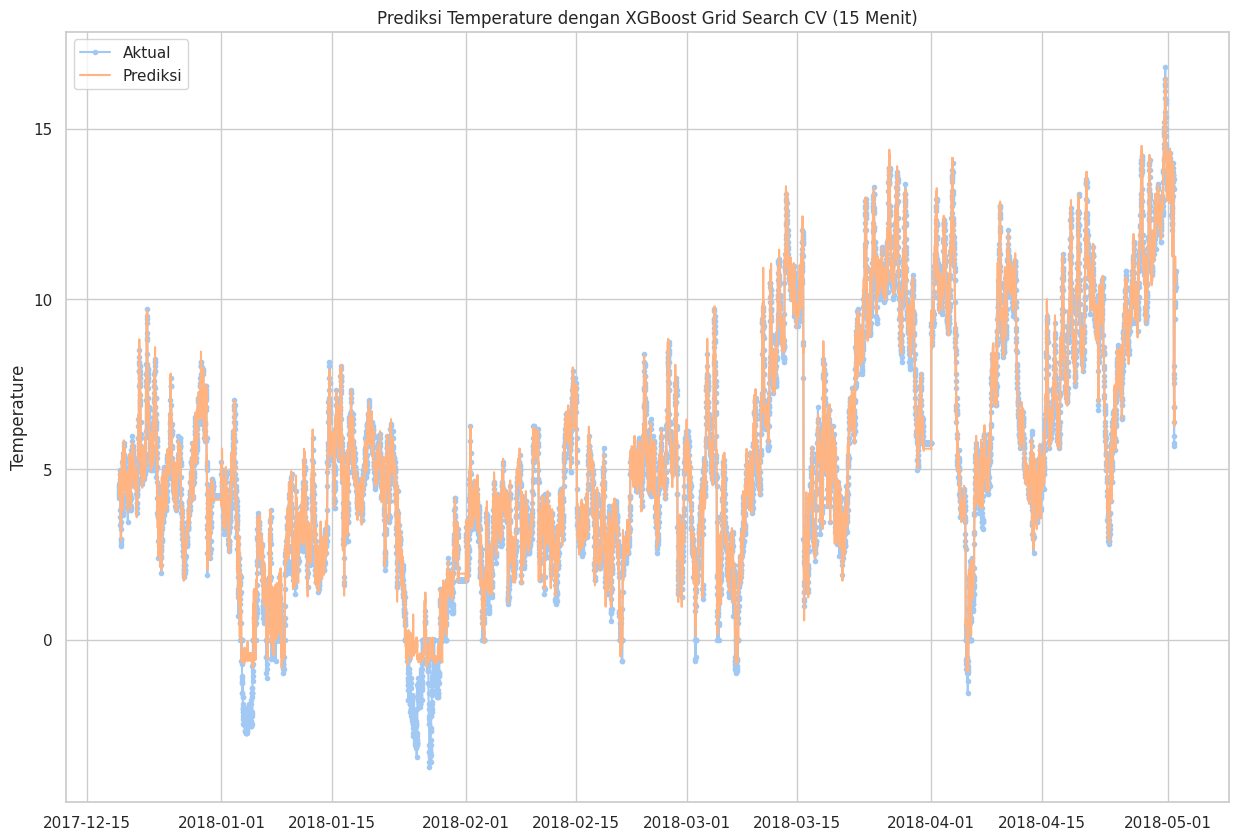

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(y_test_ML.index, y_test_ML, marker='.', label="Aktual")
plt.plot(y_test_ML.index, y_test_xgb_grid, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan XGBoost Grid Search CV (15 Menit)')
plt.legend()
plt.show()

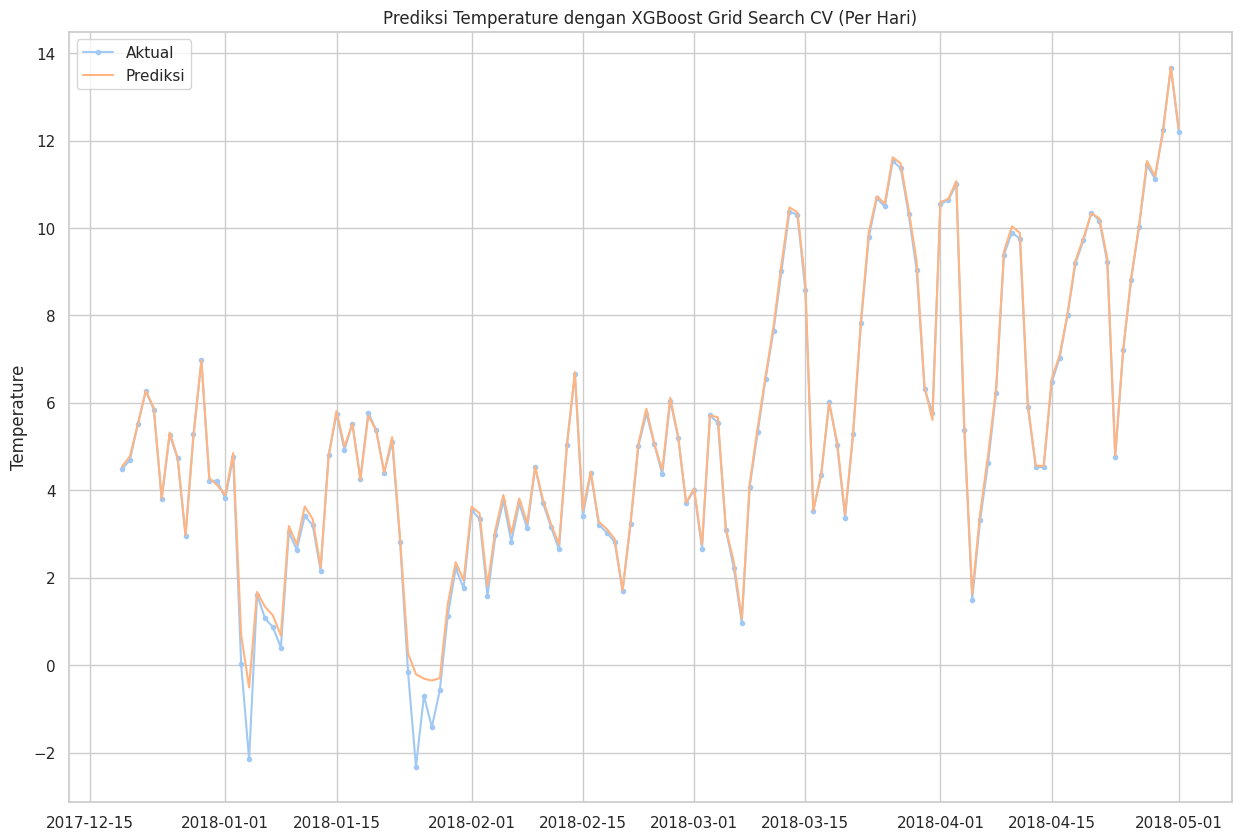

In [ ]:
# Resample data to daily frequency
y_test_daily = y_test_ML.resample('D').mean()
y_test_xgb_grid_daily = pd.Series(y_test_xgb_grid, index=y_test_ML.index).resample('D').mean()

plt.figure(figsize=(15, 10))
plt.plot(y_test_daily.index, y_test_daily, marker='.', label="Aktual")
plt.plot(y_test_daily.index, y_test_xgb_grid_daily, label="Prediksi")
plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan XGBoost Grid Search CV (Per Hari)')
plt.legend()
plt.show()

## 3. LSTM

In [ ]:
def create_sequences(X,y, seq_length):
   Xs, ys = [], []
   for i in range(len(X) - seq_length):)
       Xs.append(X[i:i+seq_length])
       ys.append(y[i+seq_length])
   return np.array(Xs), np.array(ys)

lookback = 12
Xs_train, ys_train = create_sequences(X_train_DL, y_train_DL, lookback)
Xs_test, ys_test = create_sequences(X_test_DL, y_test_DL, lookback)

model_lstm = Sequential()
model_lstm.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(Xs_train.shape[1], Xs_train.shape[2])))
model_lstm.add(LSTM(256, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model_lstm.fit(
    Xs_train, ys_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

model_lstm_path = '/content/drive/My Drive/models/lstm_model.keras'

model_lstm.save(model_lstm_path)

Epoch 1/100
1286/1286 [==============================] - 156s 121ms/step - loss: 0.4507 - val_loss: 0.2997
Epoch 2/100
1286/1286 [==============================] - 149s 116ms/step - loss: 0.4187 - val_loss: 0.4227
Epoch 3/100
1286/1286 [==============================] - 143s 111ms/step - loss: 0.4097 - val_loss: 0.5301
Epoch 4/100
1286/1286 [==============================] - 142s 111ms/step - loss: 0.4764 - val_loss: 0.5001
Epoch 5/100
1286/1286 [==============================] - 142s 110ms/step - loss: 0.3964 - val_loss: 0.4931
Epoch 6/100
1286/1286 [==============================] - 143s 111ms/step - loss: 0.4261 - val_loss: 0.7208
Epoch 7/100
1286/1286 [==============================] - 141s 110ms/step - loss: 0.3893 - val_loss: 0.7082
Epoch 8/100
1286/1286 [==============================] - 142s 111ms/step - loss: 0.3915 - val_loss: 0.7291
Epoch 9/100
1286/1286 [==============================] - 141s 109ms/step - loss: 0.3545 - val_loss: 0.6726
Epoch 10/100
1286/1286 [=============

In [ ]:
model_lstm_path = '/content/drive/My Drive/models/lstm_model.keras'

model_lstm_load = load_model(model_lstm_path)

y_pred_lstm = model_lstm_load.predict(Xs_test)

rscore_lstm = r2_score(ys_test, y_pred_lstm)
mae_lstm = mean_absolute_error(ys_test, y_pred_lstm)
mse_lstm = mean_squared_error(ys_test, y_pred_lstm)
rmse_lstm = mean_squared_error(ys_test, y_pred_lstm, squared=False)

print('LSTM')
print(f'Mean Squared Error                  : {mse_lstm:,.2f}')
print(f'Root Mean Squared Error             : {rmse_lstm:,.2f}')
print(f'Mean Absolute Error                 : {mae_lstm:,.2f}')
print(f'R-squared                           : {rscore_lstm:.2f}')

402/402 [==============================] - 12s 29ms/step
LSTM
Mean Squared Error                  : 0.47
Root Mean Squared Error             : 0.69
Mean Absolute Error                 : 0.53
R-squared                           : 0.96


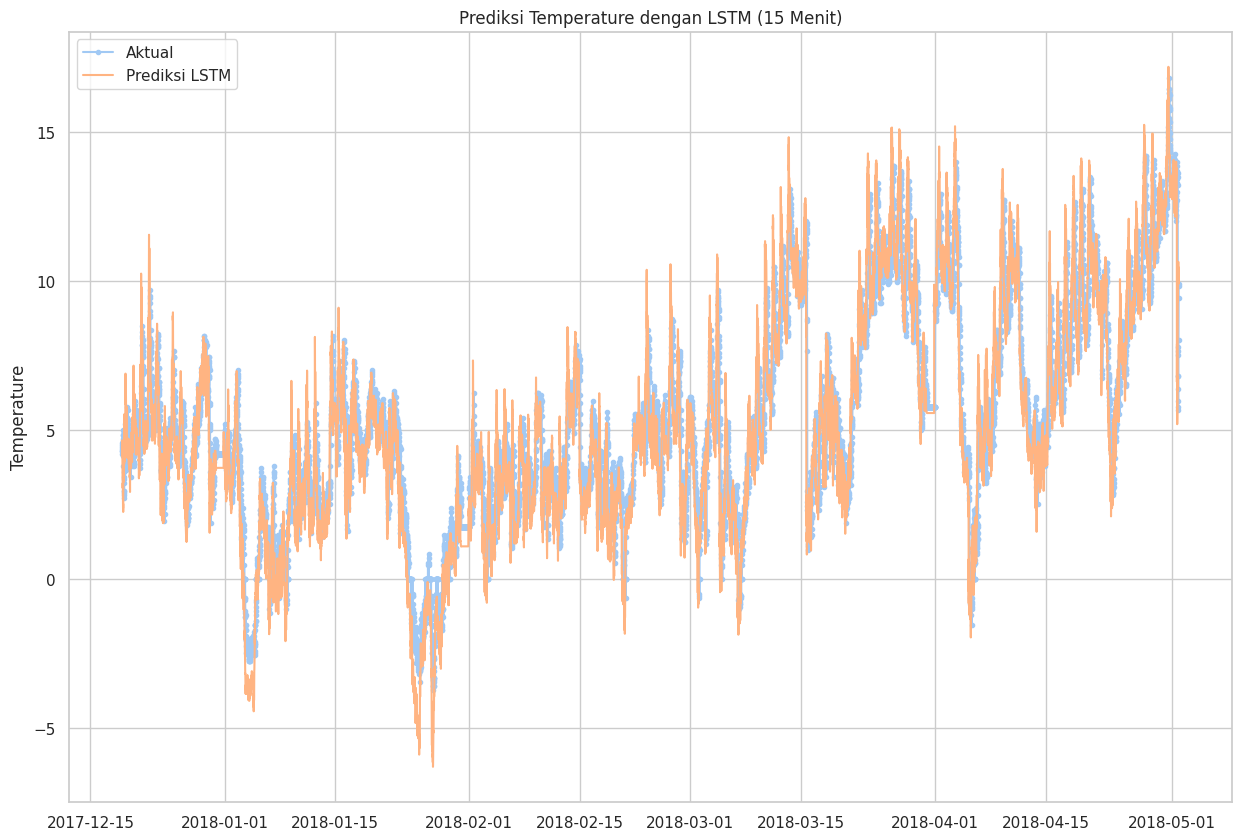

In [ ]:
y_test_trimmed = y_test_DL.iloc[:len(y_pred_lstm)]

plt.figure(figsize=(15, 10))

plt.plot(y_test_trimmed.index, y_test_trimmed, marker='.', label="Aktual")

plt.plot(y_test_trimmed.index, y_pred_lstm, label="Prediksi LSTM")

plt.ylabel('Temperature')
plt.title('Prediksi Temperature dengan LSTM (15 Menit)')
plt.legend()

plt.show()

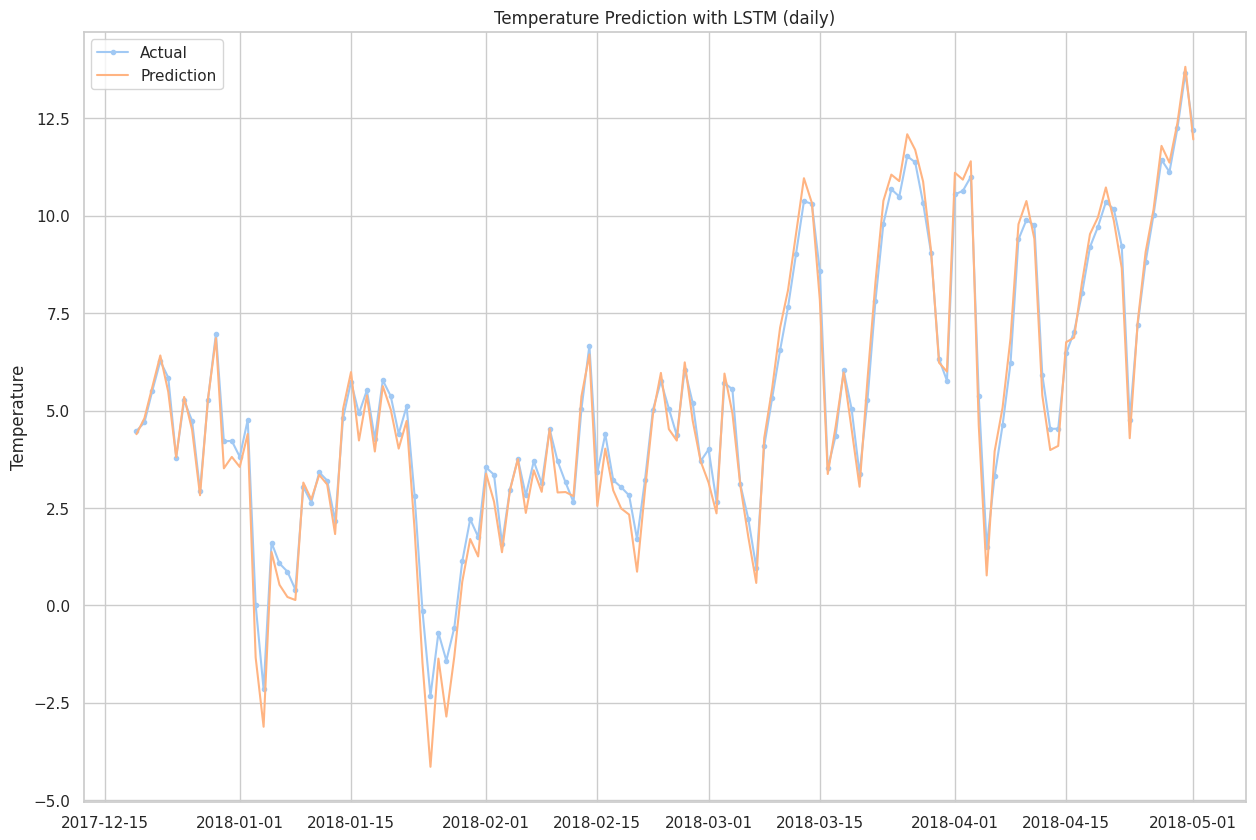

In [ ]:
len_y_pred = len(y_pred_lstm)
len_y_test = len(y_test_DL)

if len_y_pred > len_y_test:
    y_pred_lstm = y_pred_lstm[:len_y_test]
elif len_y_test > len_y_pred:
    y_test_DL = y_test_DL[:len_y_pred]

if y_pred_lstm.ndim > 1:
    y_pred_lstm = y_pred_lstm.flatten()

y_test_lstm_series = pd.Series(y_pred_lstm, index=y_test_DL.index)

y_test_daily = y_test_ML.resample('D').mean()
y_test_lstm_daily = y_test_lstm_series.resample('D').mean()

common_index = y_test_daily.index.intersection(y_test_lstm_daily.index)
y_test_daily = y_test_daily.reindex(common_index)
y_test_lstm_daily = y_test_lstm_daily.reindex(common_index)

plt.figure(figsize=(15, 10))
plt.plot(y_test_daily.index, y_test_daily, marker='.', label="Actual")
plt.plot(y_test_daily.index, y_test_lstm_daily, label="Prediction")
plt.ylabel('Temperature')
plt.title('Temperature Prediction with LSTM (daily)')
plt.legend()
plt.show()

## 4. ARIMA

In [ ]:
train_arima = train[['Temperature']].copy()
test_arima = test[['Temperature']].copy()

In [ ]:
train_arima

Temperature
date                            
2016-07-01 03:00:00    25.044001
2016-07-01 03:15:00    24.551001
2016-07-01 03:30:00    23.566000
2016-07-01 03:45:00    21.525999
2016-07-01 04:00:00    21.948000
...                          ...
2017-12-18 22:45:00     4.643000
2017-12-18 23:00:00     4.713000
2017-12-18 23:15:00     4.713000
2017-12-18 23:30:00     4.784000
2017-12-18 23:45:00     4.643000

[51444 rows x 1 columns]

In [ ]:
test_arima

Temperature
date                            
2017-12-19 00:00:00        4.362
2017-12-19 00:15:00        4.573
2017-12-19 00:30:00        4.502
2017-12-19 00:45:00        4.291
2017-12-19 01:00:00        4.432
...                          ...
2018-05-01 22:45:00       10.622
2018-05-01 23:00:00       10.482
2018-05-01 23:15:00       10.271
2018-05-01 23:30:00       10.341
2018-05-01 23:45:00       10.833

[12864 rows x 1 columns]

In [ ]:
result_arima = adfuller(train_arima)
print('ADF Statistic: %f' % result_arima[0])
print('p-value: %f' % result_arima[1])
print('Critical Values:')
for key, value in result_arima[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.001087
p-value: 0.001405
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
if result_arima[1] > 0.05:
    print("Data is non-stationary, applying differencing...")
    train_arima_diff = train_arima.diff().dropna()
    result_arima_diff = adfuller(train_arima_diff)
    print('ADF Statistic after differencing: %f' % result_arima_diff[0])
    print('p-value after differencing: %f' % result_arima_diff[1])
else:
    print("Data is stationary, no differencing needed.")
    train_arima_diff = train_arima

Data is stationary, no differencing needed.


In [ ]:
# Define the p, d, q ranges to search
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model_arima = ARIMA(train_arima, order=param)
        model_arima_fit = model_arima.fit()
        forecast_arima = model_arima_fit.forecast(steps=len(test_arima))

        mse = mean_squared_error(test_arima, forecast_arima)
        if mse < best_score:
            best_score, best_cfg = mse, param
        print(f'ARIMA{param} MSE={mse:.3f}')
    except:
        continue

print(f'Best ARIMA{best_cfg} MSE={best_score:.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) MSE=119.841


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 1) MSE=119.836


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE=119.831


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0) MSE=12.530


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1) MSE=12.548


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) MSE=12.544


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 0) MSE=1100172.450


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 1) MSE=43.948


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2) MSE=44.144


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0) MSE=110.998


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) MSE=112.410


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) MSE=111.880


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) MSE=12.547


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) MSE=12.546


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) MSE=12.539


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 0) MSE=326349.005


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(1, 2, 1) MSE=44.210


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) MSE=43.905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 0) MSE=112.488


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) MSE=113.634


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2) MSE=111.482


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 0) MSE=12.543


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) MSE=12.542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) MSE=12.539


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 0) MSE=153947.042


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 1) MSE=43.907


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


ARIMA(2, 2, 2) MSE=40.171
Best ARIMA(0, 1, 0) MSE=12.530


In [ ]:
model_arima = ARIMA(train_arima_diff, order=(0, 1, 0))
results_arima = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


In [ ]:
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                51444
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -35500.449
Date:                Sun, 26 May 2024   AIC                          71002.898
Time:                        18:59:43   BIC                          71011.746
Sample:                    07-01-2016   HQIC                         71005.666
                         - 12-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2328      0.000    477.036      0.000       0.232       0.234
Ljung-Box (L1) (Q):                 375.28   Jarque-Bera (JB):            538519.50
Prob(Q):                              0.00   Pr

In [ ]:
forecast_arima = results_arima.get_forecast(steps=len(test_arima))
forecast_arima_df = forecast_arima.summary_frame()
forecast_arima_index = test_arima.index
forecast_arima_df = forecast_arima_df.set_index(forecast_arima_index)

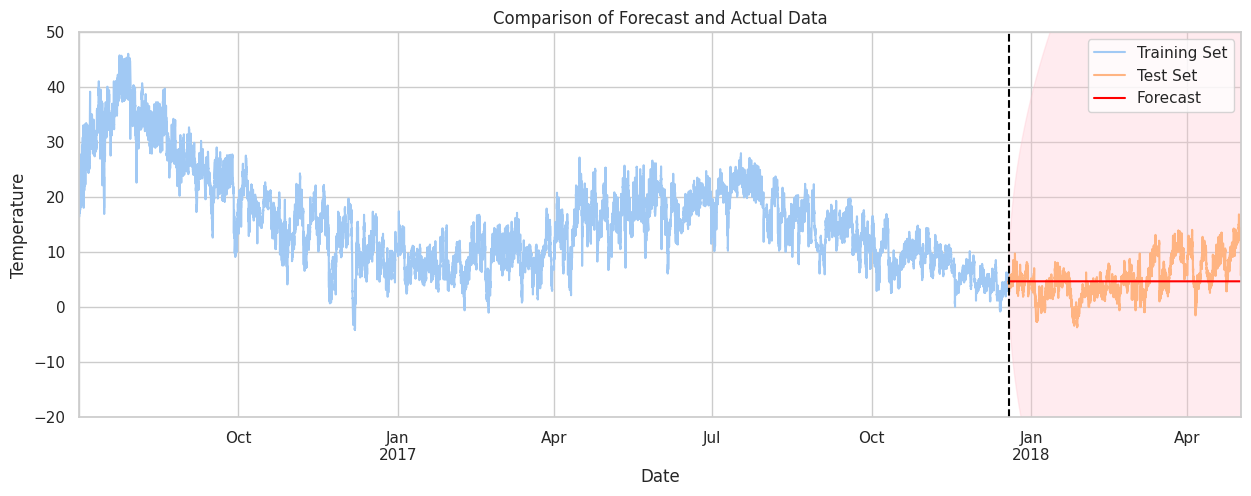

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_arima.plot(ax=ax, label='Training Set')
test_arima.plot(ax=ax, label='Test Set')
forecast_arima_df['mean'].plot(ax=ax, label='Forecast', color='red')
ax.fill_between(forecast_arima_index,
                forecast_arima_df['mean_ci_lower'],
                forecast_arima_df['mean_ci_upper'],
                color='pink', alpha=0.3)
ax.axvline('19-12-2017', color='black', ls='--')
ax.set_title('Comparison of Forecast and Actual Data')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend(['Training Set', 'Test Set', 'Forecast'])
plt.ylim([-20, 50])
plt.show()

In [ ]:
# Calculate evaluation metrics
rscore_arima = r2_score(test_arima, forecast_arima_df['mean'])
mae_arima = mean_absolute_error(test_arima, forecast_arima_df['mean'])
mse_arima = mean_squared_error(test_arima, forecast_arima_df['mean'])
rmse_arima = mean_squared_error(test_arima, forecast_arima_df['mean'], squared=False)

print('ARIMA')
print(f'Mean Squared Error                  : {mse_arima:,.2f}')
print(f'Root Mean Squared Error             : {rmse_arima:,.2f}')
print(f'Mean Absolute Error                 : {mae_arima:,.2f}')
print(f'R-squared                           : {rscore_arima:.2f}')

ARIMA
Mean Squared Error                  : 12.53
Root Mean Squared Error             : 3.54
Mean Absolute Error                 : 2.71
R-squared                           : -0.04


## 5. SARIMA

In [ ]:
train_sarima = train[['Temperature']].copy()
test_sarima = test[['Temperature']].copy()

In [ ]:
train_sarima

Temperature
date                            
2016-07-01 03:00:00    25.044001
2016-07-01 03:15:00    24.551001
2016-07-01 03:30:00    23.566000
2016-07-01 03:45:00    21.525999
2016-07-01 04:00:00    21.948000
...                          ...
2017-12-18 22:45:00     4.643000
2017-12-18 23:00:00     4.713000
2017-12-18 23:15:00     4.713000
2017-12-18 23:30:00     4.784000
2017-12-18 23:45:00     4.643000

[51444 rows x 1 columns]

In [ ]:
test_sarima

Temperature
date                            
2017-12-19 00:00:00        4.362
2017-12-19 00:15:00        4.573
2017-12-19 00:30:00        4.502
2017-12-19 00:45:00        4.291
2017-12-19 01:00:00        4.432
...                          ...
2018-05-01 22:45:00       10.622
2018-05-01 23:00:00       10.482
2018-05-01 23:15:00       10.271
2018-05-01 23:30:00       10.341
2018-05-01 23:45:00       10.833

[12864 rows x 1 columns]

In [ ]:
result_sarima = adfuller(train_sarima)
print('ADF Statistic: %f' % result_sarima[0])
print('p-value: %f' % result_sarima[1])
print('Critical Values:')
for key, value in result_sarima[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.001087
p-value: 0.001405
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
if result_sarima[1] > 0.05:
    print("Data is non-stationary, applying differencing...")
    train_sarima_diff = train_sarima.diff().dropna()
    result_sarima_diff = adfuller(train_sarima_diff)
    print('ADF Statistic after differencing: %f' % result_sarima_diff[0])
    print('p-value after differencing: %f' % result_sarima_diff[1])
else:
    print("Data is stationary, no differencing needed.")
    train_sarima_diff = train_sarima

Data is stationary, no differencing needed.


In [ ]:
model_sarima = SARIMAX(train_sarima_diff,
                       order=(1, 0, 1),
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
results_sarima = model_sarima.fit(disp=False)

sarima_path = '/content/drive/My Drive/models/sarima_model.pkl'

results_sarima.save(sarima_path)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


In [ ]:
sarima_path = '/content/drive/My Drive/models/sarima_model.pkl'

results_sarima = SARIMAXResults.load(sarima_path)

In [ ]:
print(results_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Temperature   No. Observations:                51444
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood              -35180.505
Date:                            Sun, 26 May 2024   AIC                          70369.010
Time:                                    19:03:47   BIC                          70404.401
Sample:                                07-01-2016   HQIC                         70380.082
                                     - 12-18-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9915      0.001   1892.068      0.000       0.990       0.993
ma.L1          0.0952      0.002   

In [ ]:
forecast_sarima = results_sarima.get_forecast(steps=len(test_sarima))
forecast_sarima_df = forecast_sarima.summary_frame()
forecast_sarima_index = test_sarima.index
forecast_sarima_df = forecast_sarima_df.set_index(forecast_sarima_index)

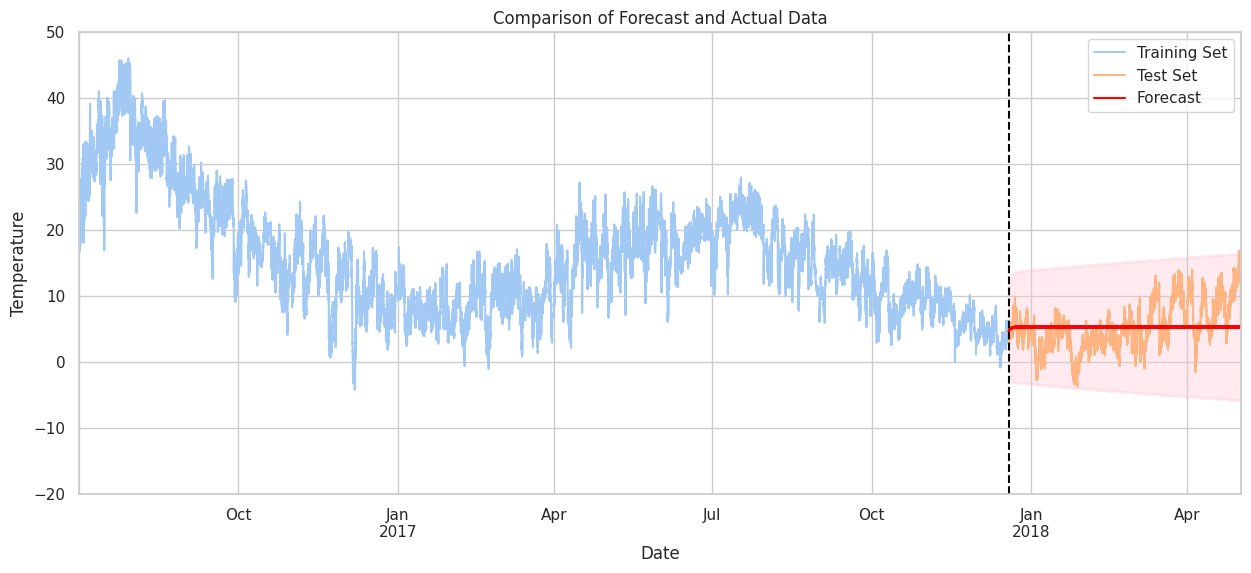

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
train_sarima.plot(ax=ax, label='Training Set')
test_sarima.plot(ax=ax, label='Test Set')
forecast_sarima_df['mean'].plot(ax=ax, label='Forecast', color='red')
ax.fill_between(forecast_sarima_index,
                forecast_sarima_df['mean_ci_lower'],
                forecast_sarima_df['mean_ci_upper'],
                color='pink', alpha=0.3)
ax.axvline('19-12-2017', color='black', ls='--')
ax.set_title('Comparison of Forecast and Actual Data')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend(['Training Set', 'Test Set', 'Forecast'])
plt.ylim([-20, 50])
plt.show()

In [ ]:
rscore_sarima = r2_score(test_sarima, forecast_sarima_df['mean'])
mae_sarima = mean_absolute_error(test_sarima, forecast_sarima_df['mean'])
mse_sarima = mean_squared_error(test_sarima, forecast_sarima_df['mean'])
rmse_sarima = mean_squared_error(test_sarima, forecast_sarima_df['mean'], squared=False)

print('SARIMA')
print(f'Mean Squared Error                  : {mse_sarima:,.2f}')
print(f'Root Mean Squared Error             : {rmse_sarima:,.2f}')
print(f'Mean Absolute Error                 : {mae_sarima:,.2f}')
print(f'R-squared                           : {rscore_sarima:.2f}')

SARIMA
Mean Squared Error                  : 12.09
Root Mean Squared Error             : 3.48
Mean Absolute Error                 : 2.73
R-squared                           : 0.00


## 6. Prophet

In [ ]:
train_reset = train.reset_index()
test_reset = test.reset_index()

In [ ]:
train_reset

date     Iws     Ir   pm2.5   PRES   cbwd   DEWP  \
0     2016-07-01 03:00:00   5.090  1.942   1.279  0.391  3.807  1.279   
1     2016-07-01 03:15:00   5.224  2.009   1.457  0.533  3.807  1.249   
2     2016-07-01 03:30:00   5.291  1.808   1.457  0.426  3.777  1.218   
3     2016-07-01 03:45:00   5.358  1.942   1.492  0.462  3.807  1.310   
4     2016-07-01 04:00:00   5.358  1.942   1.492  0.462  3.868  1.279   
...                   ...     ...    ...     ...    ...    ...    ...   
51439 2017-12-18 22:45:00  14.401  4.689  10.838  2.736  3.320  1.157   
51440 2017-12-18 23:00:00  14.803  4.756  11.691  3.056  3.350  1.066   
51441 2017-12-18 23:15:00  14.602  4.622  11.549  2.878  3.290  0.853   
51442 2017-12-18 23:30:00  14.736  4.354  11.371  2.701  3.076  0.761   
51443 2017-12-18 23:45:00  15.673  5.492  11.478  3.092  3.594  1.036   

       Temperature       WVP  Feels Like  ...  Temperature3  Temperature4  \
0        25.044001  6.702388   19.692788  ...     27.506001     27.787001   
1        24.551001  6.687981   19.101234  ...     27.857000     27.506001   
2        23.566000  6.673123   18.064431  ...     27.013000     27.857000   
3        21.525999  6.717304   15.992109  ...     25.044001     27.013000   
4        21.948000  6.702388   16.409188  ...     24.551001     25.044001   
...            ...       ...         ...  ...           ...           ...   
51439     4.643000  6.643971   -7.245189  ...      5.135000      5.135000   
51440     4.713000  6.600693   -7.470872  ...      5.206000      5.135000   
51441     4.713000  6.500367   -7.363279  ...      4.854000      5.206000   
51442     4.784000  6.457454   -7.400240  ...      4.643000      4.854000   
51443     4.643000  6.586480   -8.154562  ...      4.713000      4.643000   

       Temperature5  Temperature6  Temperature7  Temperature8  Temperature9  \
0         27.084000     27.646000     27.716999     27.787001     27.013000   
1         27.787001     27.084000     27.646000     27.716999     27.787001   
2         27.506001     27.787001     27.084000     27.646000     27.716999   
3         27.857000     27.506001     27.787001     27.084000     27.646000   
4         27.013000     27.857000     27.506001     27.787001     27.084000   
...             ...           ...           ...           ...           ...   
51439      5.135000      5.276000      5.417000      5.417000      5.206000   
51440      5.135000      5.135000      5.276000      5.417000      5.417000   
51441      5.135000      5.135000      5.135000      5.276000      5.417000   
51442      5.206000      5.135000      5.135000      5.135000      5.276000   
51443      4.854000      5.206000      5.135000      5.135000      5.135000   

       Temperature10  Temperature11  Temperature12  
0          30.038000      30.459999      30.531000  
1          27.013000      30.038000      30.459999  
2          27.787001      27.013000      30.038000  
3          27.716999      27.787001      27.013000  
4          27.646000      27.716999      27.787001  
...              ...            ...            ...  
51439       5.135000       4.995000       5.065000  
51440       5.206000       5.135000       4.995000  
51441       5.417000       5.206000       5.135000  
51442       5.417000       5.417000       5.206000  
51443       5.276000       5.417000       5.417000  

[51444 rows x 22 columns]

In [ ]:
test_reset

date        Iws     Ir   pm2.5   PRES   cbwd   DEWP  \
0     2017-12-19 00:00:00  16.007999  5.693  12.757  3.518  3.411  0.944   
1     2017-12-19 00:15:00  14.468000  4.689  10.945  2.843  3.259  1.036   
2     2017-12-19 00:30:00  14.937000  4.957  12.117  3.340  3.076  1.218   
3     2017-12-19 00:45:00  14.535000  4.823  11.158  3.127  2.924  1.097   
4     2017-12-19 01:00:00  14.535000  4.555  11.229  2.701  2.833  1.036   
...                   ...        ...    ...     ...    ...    ...    ...   
12859 2018-05-01 22:45:00  12.458000  1.407   7.889 -0.746  4.843  1.523   
12860 2018-05-01 23:00:00  14.200000  1.541   9.310  0.284  4.752  1.249   
12861 2018-05-01 23:15:00  12.659000  1.474   7.924 -0.959  4.569  1.310   
12862 2018-05-01 23:30:00  13.329000  1.541   8.671 -0.533  4.630  1.371   
12863 2018-05-01 23:45:00  11.588000  0.871   7.214 -0.426  4.691  1.310   

       Temperature       WVP  Feels Like  ...  Temperature3  Temperature4  \
0            4.362  6.543063   -8.684389  ...         4.713         4.713   
1            4.573  6.586480   -7.381062  ...         4.784         4.713   
2            4.502  6.673123   -7.751770  ...         4.643         4.784   
3            4.291  6.615408   -7.700415  ...         4.362         4.643   
4            4.432  6.586480   -7.568961  ...         4.573         4.362   
...            ...       ...         ...  ...           ...           ...   
12859       10.622  6.820587    0.152193  ...        10.833        10.763   
12860       10.482  6.687981   -1.250966  ...        10.693        10.833   
12861       10.271  6.717304   -0.373590  ...        10.482        10.693   
12862       10.341  6.746740   -0.762877  ...        10.622        10.482   
12863       10.833  6.717304    0.938110  ...        10.482        10.622   

       Temperature5  Temperature6  Temperature7  Temperature8  Temperature9  \
0             4.643         4.854         5.206         5.135         5.135   
1             4.713         4.643         4.854         5.206         5.135   
2             4.713         4.713         4.643         4.854         5.206   
3             4.784         4.713         4.713         4.643         4.854   
4             4.643         4.784         4.713         4.713         4.643   
...             ...           ...           ...           ...           ...   
12859        10.552        10.271         9.778         9.849         9.919   
12860        10.763        10.552        10.271         9.778         9.849   
12861        10.833        10.763        10.552        10.271         9.778   
12862        10.693        10.833        10.763        10.552        10.271   
12863        10.482        10.693        10.833        10.763        10.552   

       Temperature10  Temperature11  Temperature12  
0              5.135          5.276          5.417  
1              5.135          5.135          5.276  
2              5.135          5.135          5.135  
3              5.206          5.135          5.135  
4              4.854          5.206          5.135  
...              ...            ...            ...  
12859          9.426          8.020          6.824  
12860          9.919          9.426          8.020  
12861          9.849          9.919          9.426  
12862          9.778          9.849          9.919  
12863         10.271          9.778          9.849  

[12864 rows x 22 columns]

In [ ]:
train_prophet = train_reset[['date', 'Temperature']].copy().rename(columns={'date': 'ds', 'Temperature': 'y'})
test_prophet = test_reset[['date', 'Temperature']].copy().rename(columns={'date': 'ds', 'Temperature': 'y'})

In [ ]:
train_prophet

ds          y
0     2016-07-01 03:00:00  25.044001
1     2016-07-01 03:15:00  24.551001
2     2016-07-01 03:30:00  23.566000
3     2016-07-01 03:45:00  21.525999
4     2016-07-01 04:00:00  21.948000
...                   ...        ...
51439 2017-12-18 22:45:00   4.643000
51440 2017-12-18 23:00:00   4.713000
51441 2017-12-18 23:15:00   4.713000
51442 2017-12-18 23:30:00   4.784000
51443 2017-12-18 23:45:00   4.643000

[51444 rows x 2 columns]

In [ ]:
test_prophet

ds       y
0     2017-12-19 00:00:00   4.362
1     2017-12-19 00:15:00   4.573
2     2017-12-19 00:30:00   4.502
3     2017-12-19 00:45:00   4.291
4     2017-12-19 01:00:00   4.432
...                   ...     ...
12859 2018-05-01 22:45:00  10.622
12860 2018-05-01 23:00:00  10.482
12861 2018-05-01 23:15:00  10.271
12862 2018-05-01 23:30:00  10.341
12863 2018-05-01 23:45:00  10.833

[12864 rows x 2 columns]

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7z_qq4j/dyp8drz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7z_qq4j/w_yt667j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17261', 'data', 'file=/tmp/tmpk7z_qq4j/dyp8drz4.json', 'init=/tmp/tmpk7z_qq4j/w_yt667j.json', 'output', 'file=/tmp/tmpk7z_qq4j/prophet_modelnndv14sl/prophet_model-20240526190527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='15T')

In [ ]:
forecast_prophet = model_prophet.predict(future)

In [ ]:
forecast_prophet

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2016-07-01 03:00:00  24.403355   19.745191   27.420801    24.403355   
1     2016-07-01 03:15:00  24.410789   19.763556   27.697625    24.410789   
2     2016-07-01 03:30:00  24.418223   19.985287   27.310743    24.418223   
3     2016-07-01 03:45:00  24.425657   19.744254   27.218475    24.425657   
4     2016-07-01 04:00:00  24.433091   19.641742   27.239135    24.433091   
...                   ...        ...         ...         ...          ...   
64303 2018-05-01 22:45:00  -9.905235  -63.965384   49.477067   -63.299652   
64304 2018-05-01 23:00:00  -9.906283  -64.513934   49.214020   -63.306383   
64305 2018-05-01 23:15:00  -9.907331  -64.010914   49.822928   -63.313115   
64306 2018-05-01 23:30:00  -9.908379  -64.980562   48.478699   -63.319846   
64307 2018-05-01 23:45:00  -9.909427  -64.185383   50.043214   -63.326577   

       trend_upper  additive_terms  additive_terms_lower  \
0        24.403355       -0.825960             -0.825960   
1        24.410789       -0.864170             -0.864170   
2        24.418223       -0.903941             -0.903941   
3        24.425657       -0.944403             -0.944403   
4        24.433091       -0.984449             -0.984449   
...            ...             ...                   ...   
64303    50.221386       -1.001476             -1.001476   
64304    50.225876       -1.046359             -1.046359   
64305    50.230366       -1.089388             -1.089388   
64306    50.234857       -1.130296             -1.130296   
64307    50.239347       -1.168870             -1.168870   

       additive_terms_upper     daily  daily_lower  daily_upper    weekly  \
0                 -0.825960 -0.846569    -0.846569    -0.846569  0.020609   
1                 -0.864170 -0.883774    -0.883774    -0.883774  0.019604   
2                 -0.903941 -0.922513    -0.922513    -0.922513  0.018572   
3                 -0.944403 -0.961917    -0.961917    -0.961917  0.017514   
4                 -0.984449 -1.000884    -1.000884    -1.000884  0.016435   
...                     ...       ...          ...          ...       ...   
64303             -1.001476 -0.330780    -0.330780    -0.330780 -0.670696   
64304             -1.046359 -0.371240    -0.371240    -0.371240 -0.675119   
64305             -1.089388 -0.409982    -0.409982    -0.409982 -0.679406   
64306             -1.130296 -0.446739    -0.446739    -0.446739 -0.683557   
64307             -1.168870 -0.481302    -0.481302    -0.481302 -0.687568   

       weekly_lower  weekly_upper  multiplicative_terms  \
0          0.020609      0.020609                   0.0   
1          0.019604      0.019604                   0.0   
2          0.018572      0.018572                   0.0   
3          0.017514      0.017514                   0.0   
4          0.016435      0.016435                   0.0   
...             ...           ...                   ...   
64303     -0.670696     -0.670696                   0.0   
64304     -0.675119     -0.675119                   0.0   
64305     -0.679406     -0.679406                   0.0   
64306     -0.683557     -0.683557                   0.0   
64307     -0.687568     -0.687568                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                             0.0                         0.0  23.577395  
1                             0.0                         0.0  23.546619  
2                             0.0                         0.0  23.514282  
3                             0.0                         0.0  23.481254  
4                             0.0                         0.0  23.448642  
...                           ...                         ...        ...  
64303                         0.0                         0.0 -10.906711  
64304                         0.0                         0.0 -10.952642  
64305                         0.0                         0.0 -10.99

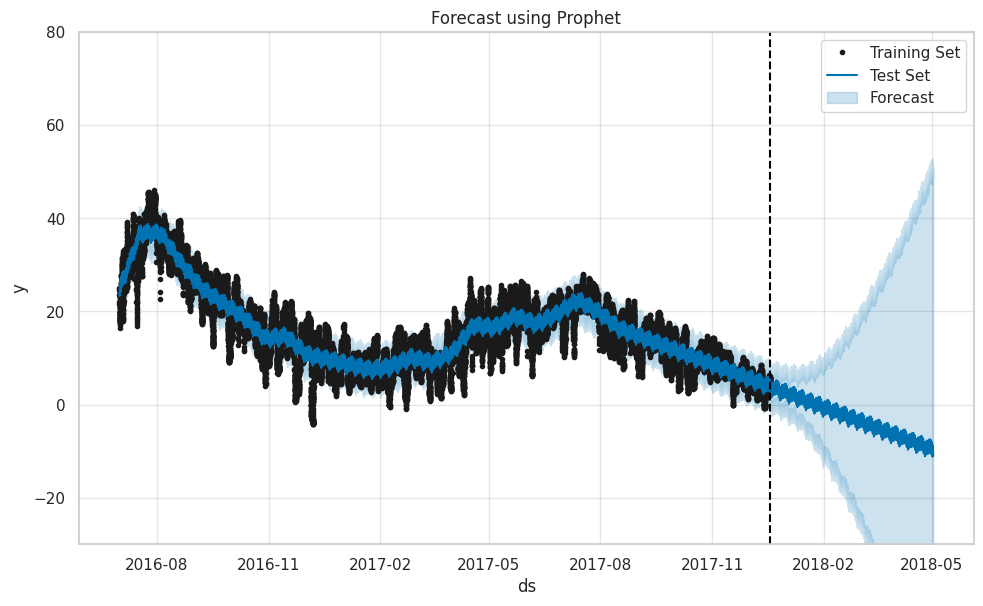

In [ ]:
fig_prophet = model_prophet.plot(forecast_prophet)
plt.axvline(pd.Timestamp('19-12-2017'), color='black', ls='--')
plt.title('Forecast using Prophet')
plt.legend(['Training Set', 'Test Set', 'Forecast'])
plt.ylim([-30, 80])  # Ubah rentang sumbu y sesuai kebutuhan Anda
plt.show()

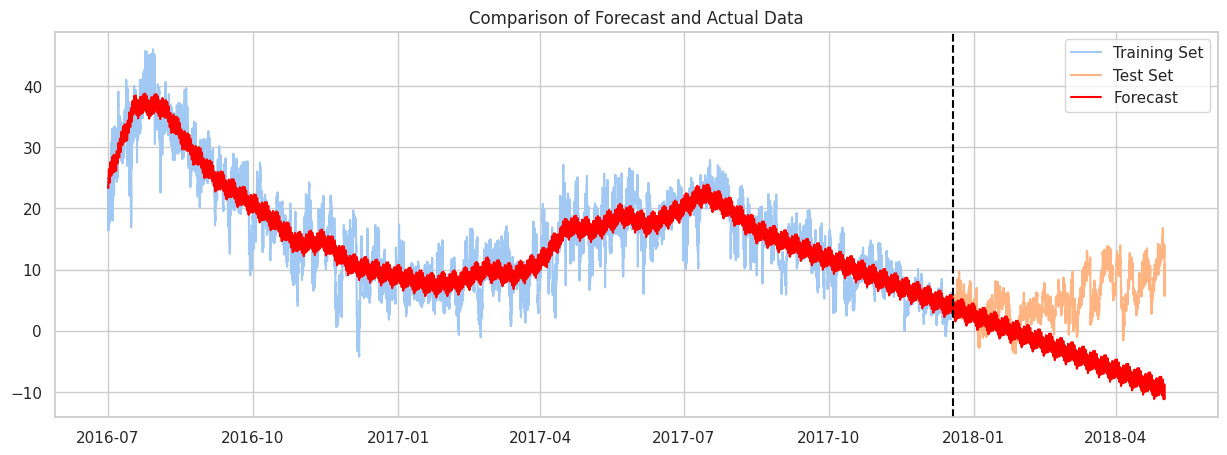

In [ ]:
# Membandingkan hasil prediksi dengan data test
plt.figure(figsize=(15, 5))
plt.plot(train['Temperature'], label='Training Set')
plt.plot(test['Temperature'], label='Test Set')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Forecast', color='red')  # Menggunakan forecast_test['ds'] sebagai sumbu x
plt.axvline(pd.Timestamp('19-12-2017'), color='black', ls='--')  # Garis vertikal pada tanggal pembagian data
plt.title('Comparison of Forecast and Actual Data')
plt.legend()
plt.show()

In [ ]:
rscore_prophet = r2_score(test_prophet['y'], forecast_prophet.loc[test_prophet.index]['yhat'])
mae_prophet = mean_absolute_error(test_prophet['y'], forecast_prophet.loc[test_prophet.index]['yhat'])
mse_prophet = mean_squared_error(test_prophet['y'], forecast_prophet.loc[test_prophet.index]['yhat'])
rmse_prophet = mean_squared_error(test_prophet['y'], forecast_prophet.loc[test_prophet.index]['yhat'], squared=False)

print('Prophet')
print(f'Mean Squared Error                  : {mse_prophet:,.2f}')
print(f'Root Mean Squared Error             : {rmse_prophet:,.2f}')
print(f'Mean Absolute Error                 : {mae_prophet:,.2f}')
print(f'R-squared                           : {rscore_prophet:.2f}')

Prophet
Mean Squared Error                  : 508.03
Root Mean Squared Error             : 22.54
Mean Absolute Error                 : 20.04
R-squared                           : -41.02


# Model Comparison

In [ ]:
metrics_rf_random = {
    'Model': 'Random Forest Random Search CV',
    'R2 Score': rscore_rf_random,
    'MAE': mae_rf_random,
    'MSE': mse_rf_random,
    'RMSE': rmse_rf_random
}

metrics_rf_grid = {
    'Model': 'Random Forest Grid Search CV',
    'R2 Score': rscore_rf_grid,
    'MAE': mae_rf_grid,
    'MSE': mse_rf_grid,
    'RMSE': rmse_rf_grid
}

metrics_xgb_random = {
    'Model': 'XGBoost Random Search CV',
    'R2 Score': rscore_xgb_random,
    'MAE': mae_xgb_random,
    'MSE': mse_xgb_random,
    'RMSE': rmse_xgb_random
}

metrics_xgb_grid = {
    'Model': 'XGBoost Grid Search CV',
    'R2 Score': rscore_xgb_grid,
    'MAE': mae_xgb_grid,
    'MSE': mse_xgb_grid,
    'RMSE': rmse_xgb_grid
}

metrics_lstm = {
    'Model': 'LSTM',
    'R2 Score': rscore_lstm,
    'MAE': mae_lstm,
    'MSE': mse_lstm,
    'RMSE': rmse_lstm
}

metrics_arima = {
    'Model': 'ARIMA',
    'R2 Score': rscore_arima,
    'MAE': mae_arima,
    'MSE': mse_arima,
    'RMSE': rmse_arima
}

metrics_sarima = {
    'Model': 'SARIMA',
    'R2 Score': rscore_sarima,
    'MAE': mae_sarima,
    'MSE': mse_sarima,
    'RMSE': rmse_sarima
}

metrics_prophet = {
    'Model': 'Prophet',
    'R2 Score': rscore_prophet,
    'MAE': mae_prophet,
    'MSE': mse_prophet,
    'RMSE': rmse_prophet
}

df_metrics = pd.DataFrame([metrics_rf_random, metrics_rf_grid, metrics_xgb_random, metrics_xgb_grid, metrics_lstm, metrics_arima, metrics_sarima, metrics_prophet])
df_metrics

Model   R2 Score        MAE         MSE       RMSE
0  Random Forest Random Search CV   0.990722   0.233432    0.112168   0.334914
1    Random Forest Grid Search CV   0.990664   0.233450    0.112867   0.335957
2        XGBoost Random Search CV   0.979872   0.322875    0.243350   0.493305
3          XGBoost Grid Search CV   0.979861   0.326422    0.243488   0.493445
4                            LSTM   0.961033   0.532684    0.471524   0.686676
5                           ARIMA  -0.036376   2.708186   12.529853   3.539753
6                          SARIMA   0.000333   2.728602   12.086035   3.476498
7                         Prophet -41.020392  20.044678  508.029353  22.539506

# Re-Train Model

## Prepare Data Re-Train

In [ ]:
df_retrain = pd.read_csv('/content/drive/MyDrive/Tim 7A Final Project Drive/Dataset/train.csv')

def hitung_tekanan_uapair(DEWP):
  E = 6.112 * np.exp((17.62 * DEWP) / (243.12 + DEWP))
  return E


df_retrain['WVP'] = hitung_tekanan_uapair(df_retrain['DEWP'])
df_retrain.head()

id                 date    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0   0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340   
1   1  2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401   
2   2  2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310   
3   3  2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310   
4   4  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371   

   Temperature       WVP  
0    30.531000  6.731766  
1    30.459999  6.761259  
2    30.038000  6.717304  
3    27.013000  6.717304  
4    27.787001  6.746740

In [ ]:
df_retrain['date'] = pd.to_datetime(df_retrain['date'])
df_retrain.set_index('date', inplace = True)
df_retrain.head()

id    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
date                                                                
2016-07-01 00:00:00   0  5.827  2.009  1.599  0.462  4.203  1.340   
2016-07-01 00:15:00   1  5.760  2.076  1.492  0.426  4.264  1.401   
2016-07-01 00:30:00   2  5.760  1.942  1.492  0.391  4.234  1.310   
2016-07-01 00:45:00   3  5.760  1.942  1.492  0.426  4.234  1.310   
2016-07-01 01:00:00   4  5.693  2.076  1.492  0.426  4.142  1.371   

                     Temperature       WVP  
date                                        
2016-07-01 00:00:00    30.531000  6.731766  
2016-07-01 00:15:00    30.459999  6.761259  
2016-07-01 00:30:00    30.038000  6.717304  
2016-07-01 00:45:00    27.013000  6.717304  
2016-07-01 01:00:00    27.787001  6.746740

In [ ]:
for i in range(1,36):
    df_retrain[f'Temperature{i}'] = df_retrain[f'Temperature'].shift(i)

df_retrain.head()

id    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
date                                                                
2016-07-01 00:00:00   0  5.827  2.009  1.599  0.462  4.203  1.340   
2016-07-01 00:15:00   1  5.760  2.076  1.492  0.426  4.264  1.401   
2016-07-01 00:30:00   2  5.760  1.942  1.492  0.391  4.234  1.310   
2016-07-01 00:45:00   3  5.760  1.942  1.492  0.426  4.234  1.310   
2016-07-01 01:00:00   4  5.693  2.076  1.492  0.426  4.142  1.371   

                     Temperature       WVP  Temperature1  ...  Temperature26  \
date                                                      ...                  
2016-07-01 00:00:00    30.531000  6.731766           NaN  ...            NaN   
2016-07-01 00:15:00    30.459999  6.761259     30.531000  ...            NaN   
2016-07-01 00:30:00    30.038000  6.717304     30.459999  ...            NaN   
2016-07-01 00:45:00    27.013000  6.717304     30.038000  ...            NaN   
2016-07-01 01:00:00    27.787001  6.746740     27.013000  ...            NaN   

                     Temperature27  Temperature28  Temperature29  \
date                                                               
2016-07-01 00:00:00            NaN            NaN            NaN   
2016-07-01 00:15:00            NaN            NaN            NaN   
2016-07-01 00:30:00            NaN            NaN            NaN   
2016-07-01 00:45:00            NaN            NaN            NaN   
2016-07-01 01:00:00            NaN            NaN            NaN   

                     Temperature30  Temperature31  Temperature32  \
date                                                               
2016-07-01 00:00:00            NaN            NaN            NaN   
2016-07-01 00:15:00            NaN            NaN            NaN   
2016-07-01 00:30:00            NaN            NaN            NaN   
2016-07-01 00:45:00            NaN            NaN            NaN   
2016-07-01 01:00:00            NaN            NaN            NaN   

                     Temperature33  Temperature34  Temperature35  
date                                                              
2016-07-01 00:00:00            NaN            NaN            NaN  
2016-07-01 00:15:00            NaN            NaN            NaN  
2016-07-01 00:30:00            NaN            NaN            NaN  
2016-07-01 00:45:00            NaN            NaN            NaN  
2016-07-01 01:00:00            NaN            NaN            NaN  

[5 rows x 44 columns]

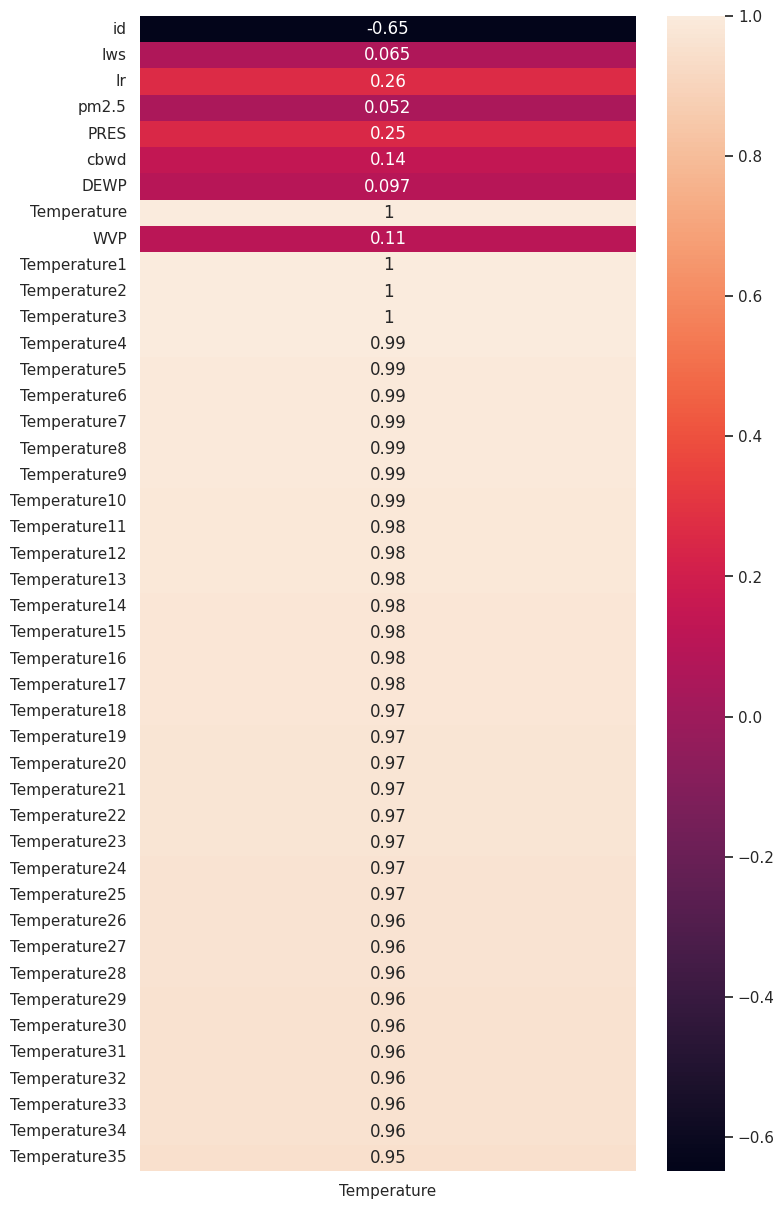

In [ ]:
corr = df_retrain.corr()

plt.figure(figsize=(8,15))
sns.heatmap(corr[['Temperature']], annot=True, fmt ='.2g')
plt.show()

In [ ]:
df_retrain = df_retrain.dropna()
df_retrain = df_retrain.reset_index()
df_retrain.head()

date  id    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0 2016-07-01 08:45:00  35  5.090  2.411  1.812  0.888  2.741  1.462   
1 2016-07-01 09:00:00  36  4.555  2.545  1.919  0.817  2.680  1.371   
2 2016-07-01 09:15:00  37  4.555  2.344  1.777  0.782  2.711  1.401   
3 2016-07-01 09:30:00  38  4.689  2.545  1.883  0.853  2.802  1.462   
4 2016-07-01 09:45:00  39  4.689  2.411  1.919  0.888  2.802  1.371   

   Temperature       WVP  ...  Temperature26  Temperature27  Temperature28  \
0    16.391001  6.790866  ...      27.506001      27.787001      27.084000   
1    17.445999  6.746740  ...      27.857000      27.506001      27.787001   
2    17.726999  6.761259  ...      27.013000      27.857000      27.506001   
3    18.500999  6.790866  ...      25.044001      27.013000      27.857000   
4    19.275000  6.746740  ...      24.551001      25.044001      27.013000   

   Temperature29  Temperature30  Temperature31  Temperature32  Temperature33  \
0      27.646000      27.716999      27.787001      27.013000      30.038000   
1      27.084000      27.646000      27.716999      27.787001      27.013000   
2      27.787001      27.084000      27.646000      27.716999      27.787001   
3      27.506001      27.787001      27.084000      27.646000      27.716999   
4      27.857000      27.506001      27.787001      27.084000      27.646000   

   Temperature34  Temperature35  
0      30.459999      30.531000  
1      30.038000      30.459999  
2      27.013000      30.038000  
3      27.787001      27.013000  
4      27.716999      27.787001  

[5 rows x 45 columns]

In [ ]:
df_retrain['month'] = df_retrain['date'].dt.month
df_retrain['day'] = df_retrain['date'].dt.day
df_retrain['hour'] = df_retrain['date'].dt.hour

def get_season(month):
    if month in [3, 4, 5]:
        return float(1)
    elif month in [6, 7, 8]:
        return float(2)
    elif month in [9, 10, 11]:
        return float(3)
    else:
        return float(4)

df_retrain['season'] = df_retrain['month'].apply(get_season)
df_retrain

df_retrain.head()

date  id    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0 2016-07-01 08:45:00  35  5.090  2.411  1.812  0.888  2.741  1.462   
1 2016-07-01 09:00:00  36  4.555  2.545  1.919  0.817  2.680  1.371   
2 2016-07-01 09:15:00  37  4.555  2.344  1.777  0.782  2.711  1.401   
3 2016-07-01 09:30:00  38  4.689  2.545  1.883  0.853  2.802  1.462   
4 2016-07-01 09:45:00  39  4.689  2.411  1.919  0.888  2.802  1.371   

   Temperature       WVP  ...  Temperature30  Temperature31  Temperature32  \
0    16.391001  6.790866  ...      27.716999      27.787001      27.013000   
1    17.445999  6.746740  ...      27.646000      27.716999      27.787001   
2    17.726999  6.761259  ...      27.084000      27.646000      27.716999   
3    18.500999  6.790866  ...      27.787001      27.084000      27.646000   
4    19.275000  6.746740  ...      27.506001      27.787001      27.084000   

   Temperature33  Temperature34  Temperature35  month  day  hour  season  
0      30.038000      30.459999      30.531000      7    1     8     2.0  
1      27.013000      30.038000      30.459999      7    1     9     2.0  
2      27.787001      27.013000      30.038000      7    1     9     2.0  
3      27.716999      27.787001      27.013000      7    1     9     2.0  
4      27.646000      27.716999      27.787001      7    1     9     2.0  

[5 rows x 49 columns]

In [ ]:
df_retrain = df_retrain.drop('id', axis=1).set_index('date')
df_retrain.head()

Iws     Ir  pm2.5   PRES   cbwd   DEWP  Temperature  \
date                                                                         
2016-07-01 08:45:00  5.090  2.411  1.812  0.888  2.741  1.462    16.391001   
2016-07-01 09:00:00  4.555  2.545  1.919  0.817  2.680  1.371    17.445999   
2016-07-01 09:15:00  4.555  2.344  1.777  0.782  2.711  1.401    17.726999   
2016-07-01 09:30:00  4.689  2.545  1.883  0.853  2.802  1.462    18.500999   
2016-07-01 09:45:00  4.689  2.411  1.919  0.888  2.802  1.371    19.275000   

                          WVP  Temperature1  Temperature2  ...  Temperature30  \
date                                                       ...                  
2016-07-01 08:45:00  6.790866     22.370001     22.089001  ...      27.716999   
2016-07-01 09:00:00  6.746740     16.391001     22.370001  ...      27.646000   
2016-07-01 09:15:00  6.761259     17.445999     16.391001  ...      27.084000   
2016-07-01 09:30:00  6.790866     17.726999     17.445999  ...      27.787001   
2016-07-01 09:45:00  6.746740     18.500999     17.726999  ...      27.506001   

                     Temperature31  Temperature32  Temperature33  \
date                                                               
2016-07-01 08:45:00      27.787001      27.013000      30.038000   
2016-07-01 09:00:00      27.716999      27.787001      27.013000   
2016-07-01 09:15:00      27.646000      27.716999      27.787001   
2016-07-01 09:30:00      27.084000      27.646000      27.716999   
2016-07-01 09:45:00      27.787001      27.084000      27.646000   

                     Temperature34  Temperature35  month  day  hour  season  
date                                                                         
2016-07-01 08:45:00      30.459999      30.531000      7    1     8     2.0  
2016-07-01 09:00:00      30.038000      30.459999      7    1     9     2.0  
2016-07-01 09:15:00      27.013000      30.038000      7    1     9     2.0  
2016-07-01 09:30:00      27.787001      27.013000      7    1     9     2.0  
2016-07-01 09:45:00      27.716999      27.787001      7    1     9     2.0  

[5 rows x 47 columns]

In [ ]:
train = df_retrain[df_retrain.index < '19-12-2017']
test = df_retrain[df_retrain.index >= '19-12-2017']

FEATURES2 = ['Iws', 'Ir', 'pm2.5', 'PRES', 'cbwd', 'DEWP', 'WVP'] + [f'Temperature{i}' for i in range(1, 36)] + ['month','day','hour','season']
TARGET2 = 'Temperature'

X_retrain_ML = train[FEATURES2]
y_retrain_ML = train[TARGET2]

X_retest_ML = test[FEATURES2]
y_retest_ML = test[TARGET2]

## Modeling with Random Forest

In [ ]:
params = {
    'n_estimators': 250,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'max_depth': 10
}

rf_model2 = RandomForestRegressor(**params)

In [ ]:
rf_model2.fit(X_retrain_ML, y_retrain_ML)

rf_path2 = '/content/drive/My Drive/models/rf_fix.pkl'

joblib.dump(rf_model2, rf_path2)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


['/content/drive/My Drive/models/rf_fix.pkl']

In [ ]:
rf_path2 = '/content/drive/My Drive/models/rf_fix.pkl'

rf_model2 = joblib.load(rf_path2)

In [ ]:
y_retest_rf = rf_model2.predict(X_retest_ML)

rscore_rf_retest = r2_score(y_retest_ML, y_retest_rf)
mae_rf_retest = mean_absolute_error(y_retest_ML, y_retest_rf)
mse_rf_retest = mean_squared_error(y_retest_ML, y_retest_rf)
rmse_rf_retest = mean_squared_error(y_retest_ML, y_retest_rf, squared=False)

print('Random Forest Retrain')
print(f'Mean Squared Error                  : {mse_rf_retest:,.2f}')
print(f'Root Mean Squared Error             : {rmse_rf_retest:,.2f}')
print(f'Mean Absolute Error                 : {mae_rf_retest:,.2f}')
print(f'R-squared                           : {rscore_rf_retest:.2f}')

Random Forest Retrain
Mean Squared Error                  : 0.11
Root Mean Squared Error             : 0.34
Mean Absolute Error                 : 0.24
R-squared                           : 0.99


## Modelling with XGBoost

In [ ]:
from xgboost import XGBRegressor

params = {'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 70,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.8}

xgb_model2 = XGBRegressor(**params)

In [ ]:
import joblib
xgb_model2.fit(X_retrain_ML, y_retrain_ML)

xgb_path2 = '/content/drive/My Drive/models/xgb_fix.pkl'

joblib.dump(xgb_model2, xgb_path2)

['/content/drive/My Drive/models/xgb_fix.pkl']

In [ ]:
xgb_path2 = '/content/drive/My Drive/models/xgb_fix.pkl'

xgb_model2 = joblib.load(xgb_path2)

In [ ]:
y_retest_xgb = xgb_model2.predict(X_retest_ML)

rscore_xgb_retest = r2_score(y_retest_ML, y_retest_xgb)
mae_xgb_retest = mean_absolute_error(y_test_ML, y_retest_xgb)
mse_xgb_retest = mean_squared_error(y_test_ML, y_retest_xgb)
rmse_xgb_retest = mean_squared_error(y_test_ML, y_retest_xgb, squared=False)

print('XGBoost Retrain')
print(f'Mean Squared Error                  : {mse_xgb_retest:,.2f}')
print(f'Root Mean Squared Error             : {rmse_xgb_retest:,.2f}')
print(f'Mean Absolute Error                 : {mae_xgb_retest:,.2f}')
print(f'R-squared                           : {rscore_xgb_retest:.2f}')

XGBoost Retrain
Mean Squared Error                  : 0.27
Root Mean Squared Error             : 0.52
Mean Absolute Error                 : 0.34
R-squared                           : 0.98


## Compare Prediction RF & XGB

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Tim 7A Final Project Drive/Dataset/train.csv')
df_train = df_train[-36:]
df_test = pd.read_csv('/content/drive/MyDrive/Tim 7A Final Project Drive/Dataset/test.csv')

In [ ]:
df_combined = pd.concat([df_train, df_test], axis=0)
df_combined['WVP'] = hitung_tekanan_uapair(df_combined['DEWP'])
df_combined.head()

id                 date    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
64284  64284  2018-05-01 15:00:00 -6.162  0.000 -8.742 -2.061  2.894  1.401   
64285  64285  2018-05-01 15:15:00 -5.492 -0.402 -9.239 -2.132  2.833  1.371   
64286  64286  2018-05-01 15:30:00 -2.545 -0.938 -5.259 -2.452  2.772  1.371   
64287  64287  2018-05-01 15:45:00 -4.086 -0.603 -7.107 -1.670  2.559  1.157   
64288  64288  2018-05-01 16:00:00 -0.737 -0.536 -3.269 -1.954  2.650  1.188   

       Temperature       WVP  
64284       13.507  6.761259  
64285       13.858  6.746740  
64286       13.999  6.746740  
64287       13.647  6.643971  
64288       13.436  6.658772

In [ ]:
for i in range(1,36):
    df_combined[f'Temperature{i}'] = df_combined[f'Temperature'].shift(i)

df_combined = df_combined[35:]
df_combined.head()

id                 date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
64319  64319  2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   
0      64320  2018-05-02 00:00:00  14.133  2.076  9.346 -0.036  4.538  1.279   
1      64321  2018-05-02 00:15:00  12.123  1.541  7.818 -0.746  4.538  1.249   
2      64322  2018-05-02 00:30:00  12.525  1.741  8.209 -0.284  4.477  1.279   
3      64323  2018-05-02 00:45:00  12.324  1.942  7.747  0.249  4.630  1.371   

       Temperature       WVP  ...  Temperature26  Temperature27  \
64319       10.833  6.717304  ...         13.507         13.647   
0              NaN  6.702388  ...         13.225         13.507   
1              NaN  6.687981  ...          7.668         13.225   
2              NaN  6.702388  ...          7.527          7.668   
3              NaN  6.746740  ...          7.809          7.527   

       Temperature28  Temperature29  Temperature30  Temperature31  \
64319         13.647         13.647         13.718         13.436   
0             13.647         13.647         13.647         13.718   
1             13.507         13.647         13.647         13.647   
2             13.225         13.507         13.647         13.647   
3              7.668         13.225         13.507         13.647   

       Temperature32  Temperature33  Temperature34  Temperature35  
64319         13.647         13.999         13.858         13.507  
0             13.436         13.647         13.999         13.858  
1             13.718         13.436         13.647         13.999  
2             13.647         13.718         13.436         13.647  
3             13.647         13.647         13.718         13.436  

[5 rows x 45 columns]

In [ ]:
df_combined = df_combined.reset_index()
df_combined.drop(['index'], axis = 1, inplace = True)

df_combined['date'] = pd.to_datetime(df_combined['date'])
df_combined['month'] = df_combined['date'].dt.month
df_combined['day'] = df_combined['date'].dt.day
df_combined['hour'] = df_combined['date'].dt.hour

def get_season(month):
    if month in [3, 4, 5]:
        return float(1)
    elif month in [6, 7, 8]:
        return float(2)
    elif month in [9, 10, 11]:
        return float(3)
    else:
        return float(4)

df_combined['season'] = df_combined['month'].apply(get_season)
df_combined.head()

id                date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0  64319 2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   
1  64320 2018-05-02 00:00:00  14.133  2.076  9.346 -0.036  4.538  1.279   
2  64321 2018-05-02 00:15:00  12.123  1.541  7.818 -0.746  4.538  1.249   
3  64322 2018-05-02 00:30:00  12.525  1.741  8.209 -0.284  4.477  1.279   
4  64323 2018-05-02 00:45:00  12.324  1.942  7.747  0.249  4.630  1.371   

   Temperature       WVP  ...  Temperature30  Temperature31  Temperature32  \
0       10.833  6.717304  ...         13.718         13.436         13.647   
1          NaN  6.702388  ...         13.647         13.718         13.436   
2          NaN  6.687981  ...         13.647         13.647         13.718   
3          NaN  6.702388  ...         13.647         13.647         13.647   
4          NaN  6.746740  ...         13.507         13.647         13.647   

   Temperature33  Temperature34  Temperature35  month  day  hour  season  
0         13.999         13.858         13.507      5    1    23     1.0  
1         13.647         13.999         13.858      5    2     0     1.0  
2         13.436         13.647         13.999      5    2     0     1.0  
3         13.718         13.436         13.647      5    2     0     1.0  
4         13.647         13.718         13.436      5    2     0     1.0  

[5 rows x 49 columns]

In [ ]:
FEATURES_ML_pred = ['Iws', 'Ir', 'pm2.5', 'PRES', 'cbwd', 'DEWP', 'WVP'] + [f'Temperature{i}' for i in range(1, 36)] + ['month','day','hour','season']
df_rf_predict = df_combined.copy()

for index, row in df_rf_predict.iterrows():
    if index > 0 :
      for i in range (36,1,-1):
          df_rf_predict.at[index, f'Temperature{i}'] = df_rf_predict.at[index-1, f'Temperature{i-1}']
      df_rf_predict.at[index, f'Temperature1'] = df_rf_predict.at[index-1, f'Temperature']
      df_rf_predict.at[index, f'Temperature'] = rf_model2.predict(df_rf_predict.loc[index, FEATURES_ML_pred].to_frame().T.astype('float'))

In [ ]:
df_rf = df_rf_predict.copy()
columns_to_drop = [f'Temperature{i}' for i in range(1, 37)] + ['month','day','hour','season']
df_rf = df_rf.drop(columns=columns_to_drop)
df_rf['Feels Like'] = calculate_feels_like(df_rf['Temperature'], df_rf['Iws'], df_rf['WVP'])
df_rf.head()

id                date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0  64319 2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   
1  64320 2018-05-02 00:00:00  14.133  2.076  9.346 -0.036  4.538  1.279   
2  64321 2018-05-02 00:15:00  12.123  1.541  7.818 -0.746  4.538  1.249   
3  64322 2018-05-02 00:30:00  12.525  1.741  8.209 -0.284  4.477  1.279   
4  64323 2018-05-02 00:45:00  12.324  1.942  7.747  0.249  4.630  1.371   

   Temperature       WVP  Feels Like  
0    10.833000  6.717304    0.938110  
1    10.658776  6.702388   -1.022536  
2    10.624094  6.687981    0.345027  
3    10.589281  6.702388    0.033569  
4    10.590323  6.746740    0.189947

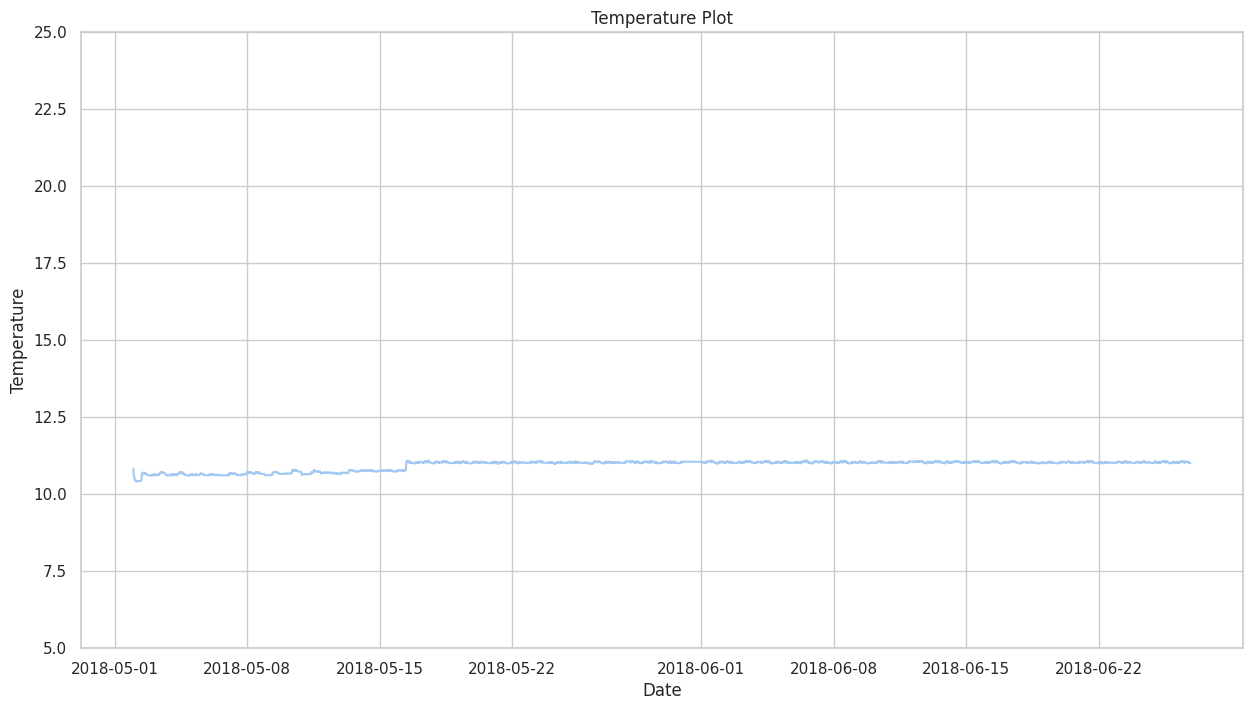

In [ ]:
df_rf['date'] = pd.to_datetime(df_rf['date'])
df_rf.set_index('date', inplace=True)

plt.figure(figsize=(15,8))
plt.plot(df_rf.index, df_rf['Temperature'])
plt.ylim(5, 25)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()

In [ ]:
df_xgb_predict = df_combined.copy()

for index, row in df_xgb_predict.iterrows():
    if index > 0 :
      for i in range (36,1,-1):
          df_xgb_predict.at[index, f'Temperature{i}'] = df_xgb_predict.at[index-1, f'Temperature{i-1}']
      df_xgb_predict.at[index, f'Temperature1'] = df_xgb_predict.at[index-1, f'Temperature']
      df_xgb_predict.at[index, f'Temperature'] = xgb_model2.predict(df_xgb_predict.loc[index, FEATURES_ML_pred].to_frame().T.astype('float'))

In [ ]:
df_xgb = df_xgb_predict.copy()
columns_to_drop = [f'Temperature{i}' for i in range(1, 37)] + ['month','day','hour','season']
df_xgb = df_xgb.drop(columns=columns_to_drop)
df_xgb['Feels Like'] = calculate_feels_like(df_xgb['Temperature'], df_xgb['Iws'], df_xgb['WVP'])
df_xgb.head()

id                date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0  64319 2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   
1  64320 2018-05-02 00:00:00  14.133  2.076  9.346 -0.036  4.538  1.279   
2  64321 2018-05-02 00:15:00  12.123  1.541  7.818 -0.746  4.538  1.249   
3  64322 2018-05-02 00:30:00  12.525  1.741  8.209 -0.284  4.477  1.279   
4  64323 2018-05-02 00:45:00  12.324  1.942  7.747  0.249  4.630  1.371   

   Temperature       WVP  Feels Like  
0    10.833000  6.717304    0.938110  
1    10.473646  6.702388   -1.207666  
2    10.452809  6.687981    0.173743  
3    10.521667  6.702388   -0.034045  
4    10.676612  6.746740    0.276236

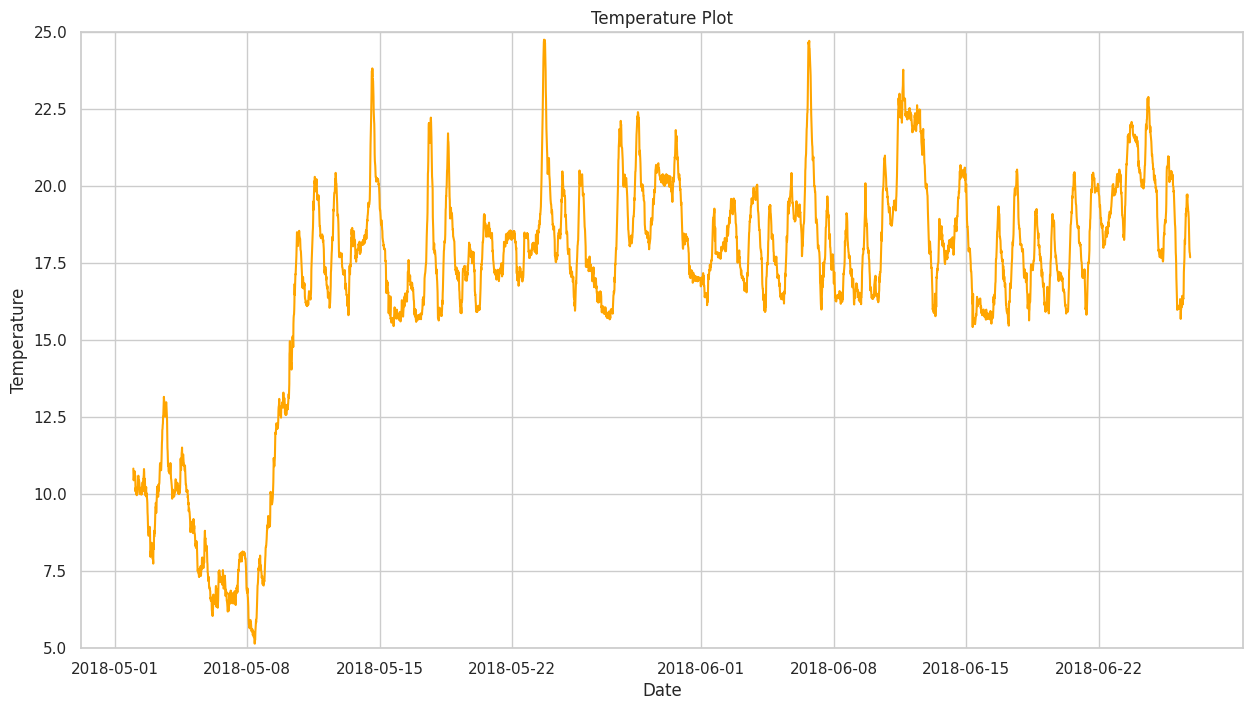

In [ ]:
df_xgb_plot = df_xgb.copy()
df_xgb_plot['date'] = pd.to_datetime(df_xgb_plot['date'])
df_xgb_plot.set_index('date', inplace=True)


plt.figure(figsize=(15,8))
plt.plot(df_xgb_plot.index, df_xgb_plot['Temperature'], color = 'orange')
plt.ylim(5, 25)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()

# Final Model

1. Training: Model yang dilatih menunjukkan error sebesar **0,34** pada **Random Forest** dengan Metric RMSE, sedangkan pada **XGBoost** model menunjukkan error sebesar **0,52** dengan Metric RMSE. Akurasi terbaik terdapat pada model XGBoost sehingga pemilihan model diputuskan menggunakan XGBoost. Dalam hal training model Random Forest menunjukkan Error yang lebih kecil.

2. Predict: Dalam melakukan prediksi, model **Random Forest** sangat kurang. Hasil prediksinya untuk musim panas hanya berkisar pada suhu 9-11 derajat dimana sangat tidak sesuai dengan temperature-temperature sebelumnya ketika musim panas. Sedangkan model **XGBoost** berhasil memprediksi temperature yang hampir menyerupai temperature musim panas di tahun-tahun sebelumnya yang berkisar dari 5-25 derajat.

Kesimpulan: Setelah kami pertimbangkan, kami memilih Model **XGBoost** sebagai final model kami, karena meskipun dalam training errornya masih sedikit lebih besar dibanding Random Forest, namun dalam prediksi XGBoost bisa melakukannya dengan baik dibanding Random Forest yang mungkin mengalami overtraining pada musim dingin.

# Export Dataset

In [ ]:
df_ori = pd.read_csv('/content/drive/MyDrive/Tim 7A Final Project Drive/Dataset/train.csv')
df_ori['WVP'] = hitung_tekanan_uapair(df_ori['DEWP'])
df_ori['Feels Like'] = calculate_feels_like(df_ori['Temperature'], df_ori['Iws'], df_ori['WVP'])
df_ori.head()

id                 date    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0   0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340   
1   1  2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401   
2   2  2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310   
3   3  2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310   
4   4  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371   

   Temperature       WVP  Feels Like  
0    30.531000  6.731766   24.673583  
1    30.459999  6.761259   24.659214  
2    30.038000  6.717304   24.222710  
3    27.013000  6.717304   21.197710  
4    27.787001  6.746740   22.028325

In [ ]:
df_ori.to_csv('/content/drive/MyDrive/Spreadsheets/Dataset Actual.xlsx', index=False)

In [ ]:
df_xgb.head()

id                date     Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0  64319 2018-05-01 23:45:00  11.588  0.871  7.214 -0.426  4.691  1.310   
1  64320 2018-05-02 00:00:00  14.133  2.076  9.346 -0.036  4.538  1.279   
2  64321 2018-05-02 00:15:00  12.123  1.541  7.818 -0.746  4.538  1.249   
3  64322 2018-05-02 00:30:00  12.525  1.741  8.209 -0.284  4.477  1.279   
4  64323 2018-05-02 00:45:00  12.324  1.942  7.747  0.249  4.630  1.371   

   Temperature       WVP  Feels Like  
0    10.833000  6.717304    0.938110  
1    10.473646  6.702388   -1.207666  
2    10.452809  6.687981    0.173743  
3    10.521667  6.702388   -0.034045  
4    10.676612  6.746740    0.276236

In [ ]:
df_xgb.to_csv('/content/drive/MyDrive/Spreadsheets/Dataset Prediction.xlsx', index=False)

In [ ]:
df_complete = pd.concat([df_ori, df_xgb], axis=0)
df_complete.head()

id                 date    Iws     Ir  pm2.5   PRES   cbwd   DEWP  \
0   0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340   
1   1  2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401   
2   2  2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310   
3   3  2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310   
4   4  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371   

   Temperature       WVP  Feels Like  
0    30.531000  6.731766   24.673583  
1    30.459999  6.761259   24.659214  
2    30.038000  6.717304   24.222710  
3    27.013000  6.717304   21.197710  
4    27.787001  6.746740   22.028325

In [ ]:
df_complete.to_csv('/content/drive/MyDrive/Spreadsheets/Dataset Gabungan.xlsx', index=False)